In [1]:
import os
import struct
import numpy as np
import tensorflow as tf
from tensorflow.python.estimator.export.export_output import PredictOutput

tf.logging.set_verbosity(tf.logging.INFO)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#load MNIST data from files

fname_img_train = os.path.join(os.getcwd(), 'MNIST-data/train-images.idx3-ubyte')
fname_lbl_train = os.path.join(os.getcwd(), 'MNIST-data/train-labels.idx1-ubyte')

fname_img_eval = os.path.join(os.getcwd(), 'MNIST-data/t10k-images.idx3-ubyte')
fname_lbl_eval = os.path.join(os.getcwd(), 'MNIST-data/t10k-labels.idx1-ubyte')


with open(fname_lbl_train, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    train_labels = np.fromfile(flbl, dtype=np.int8).astype(dtype=np.int32)
    
with open(fname_lbl_eval, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    eval_labels = np.fromfile(flbl, dtype=np.int8).astype(dtype=np.int32)
    
with open(fname_img_train, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    train_data = np.fromfile(fimg, dtype=np.uint8).reshape(len(train_labels), rows, cols, 1).astype(dtype=np.float32)
    train_data = np.true_divide(train_data, 256)
    
with open(fname_img_eval, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    eval_data = np.fromfile(fimg, dtype=np.uint8).reshape(len(eval_labels), rows, cols, 1).astype(dtype=np.float32)
    eval_data = np.true_divide(eval_data, 256)
    
print('train_data shape:   ' + str(train_data.shape))
print('train_labels shape: ' + str(train_labels.shape))

print('eval_data shape:    ' + str(eval_data.shape))
print('eval_labels shape:  ' + str(eval_labels.shape))

train_data shape:   (60000, 28, 28, 1)
train_labels shape: (60000,)
eval_data shape:    (10000, 28, 28, 1)
eval_labels shape:  (10000,)


In [3]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=features["x"],
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    export_outputs={"SIGNATURE_NAME": PredictOutput({
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="final_result")
    })}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,export_outputs=export_outputs)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [4]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="./logdir")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f89f58cef50>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './logdir', '_global_id_in_cluster': 0, '_save_summary_steps': 100}


In [5]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "final_result"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [6]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=50,
    num_epochs=None,
    shuffle=True)

mnist_classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./logdir/model.ckpt-54601
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 54602 into ./logdir/model.ckpt.
INFO:tensorflow:probabilities = [[0.00221258 0.00296263 0.00182138 0.4288098  0.00024743 0.53675395
  0.02275554 0.00000025 0.00350809 0.00092829]
 [0.00000386 0.00007034 0.00125481 0.00015445 0.00000008 0.00000009
  0.         0.99813473 0.00037707 0.00000463]
 [0.00004676 0.00419911 0.00023734 0.00410056 0.00006005 0.0093428
  0.00004991 0.00000154 0.9812785  0.00068349]
 [0.00014109 0.00005548 0.00002141 0.00032824 0.00004408 0.9881442
  0.00100896 0.00000064 0.01010187 0.000154  ]
 [0.00000795 0.00001103 0.00000121 0.0071078  0.00000047 0.9912111
  0.00000294 0.00000002 0.00097748 0.00067997]
 [0.9985347  0.00000

INFO:tensorflow:global_step/sec: 126.303
INFO:tensorflow:probabilities = [[0.00000108 0.00000001 0.00000001 0.00003607 0.00000022 0.99910307
  0.0008458  0.00000002 0.00000683 0.00000684]
 [0.00000287 0.00000427 0.00052027 0.84229636 0.00003436 0.00032052
  0.00000005 0.00016076 0.00119811 0.15546244]
 [0.00003431 0.9944952  0.00037468 0.00001407 0.0003318  0.00000026
  0.00001524 0.00002248 0.00460262 0.00010935]
 [0.00000314 0.00023973 0.99906427 0.00046761 0.00000153 0.00000214
  0.00000002 0.00001915 0.00020216 0.00000028]
 [0.00000034 0.00000213 0.00001461 0.00000072 0.9997187  0.00000091
  0.00002066 0.00000367 0.00010852 0.00012972]
 [0.00012842 0.00165212 0.94388545 0.04443913 0.00000256 0.00009391
  0.00000093 0.00061702 0.00912526 0.00005528]
 [0.00000097 0.0000006  0.00225993 0.0000155  0.         0.00000007
  0.         0.997612   0.00000097 0.0001099 ]
 [0.00000974 0.00000001 0.00000205 0.         0.00000146 0.00029164
  0.9996123  0.         0.00008248 0.0000004 ]
 [0.000

INFO:tensorflow:global_step/sec: 153.601
INFO:tensorflow:probabilities = [[0.00000101 0.00003386 0.00662443 0.12325856 0.0000198  0.00032698
  0.00000069 0.00000001 0.86955947 0.00017519]
 [0.03077986 0.00010342 0.02316422 0.0385106  0.05291072 0.804313
  0.02014641 0.00001733 0.00513073 0.02492369]
 [0.9917802  0.00000003 0.00034722 0.00000044 0.00006475 0.000036
  0.00662063 0.         0.00047708 0.00067363]
 [0.00000001 0.00000113 0.00002004 0.99908054 0.00000001 0.00034516
  0.         0.         0.00051421 0.00003887]
 [0.9992193  0.00000037 0.00000097 0.         0.00000017 0.00000014
  0.00077879 0.         0.00000018 0.00000005]
 [0.00000005 0.         0.00000002 0.         0.9999926  0.00000001
  0.00000095 0.         0.00000013 0.00000613]
 [0.0033399  0.00000002 0.00013694 0.00000472 0.00002379 0.00000632
  0.00000045 0.00104894 0.00109422 0.9943447 ]
 [0.99986446 0.0000009  0.000065   0.00000012 0.00000005 0.00000091
  0.00002385 0.00000135 0.00001215 0.00003129]
 [0.0000073

INFO:tensorflow:global_step/sec: 155.658
INFO:tensorflow:probabilities = [[0.         0.00000077 0.999997   0.00000145 0.         0.
  0.         0.00000033 0.00000048 0.00000002]
 [0.00010395 0.00018546 0.00055733 0.00019355 0.0000307  0.00050021
  0.00026204 0.00000022 0.9979061  0.00026036]
 [0.00007481 0.00004395 0.00008917 0.00038579 0.06343394 0.00003395
  0.00000374 0.00036069 0.00068134 0.9348926 ]
 [0.00010299 0.00000103 0.00009362 0.00162045 0.00006149 0.98819077
  0.00195216 0.00000015 0.00782994 0.0001475 ]
 [0.00001509 0.00012187 0.00000675 0.00000052 0.9989943  0.00000085
  0.000022   0.00000175 0.00026484 0.00057217]
 [0.00015406 0.00050106 0.00055878 0.03865179 0.00008114 0.00209249
  0.00004826 0.00000001 0.9567925  0.00111994]
 [0.0000343  0.00001315 0.02659257 0.02135971 0.0000004  0.00015424
  0.00000047 0.00007266 0.9512359  0.00053659]
 [0.00000229 0.00000165 0.00019643 0.00015947 0.00024323 0.0000128
  0.00000254 0.99807113 0.00004928 0.00126129]
 [0.00000231 0.0

INFO:tensorflow:global_step/sec: 156.187
INFO:tensorflow:probabilities = [[0.0000123  0.00000557 0.00000715 0.00000223 0.98904294 0.00000248
  0.00000887 0.00000301 0.00069084 0.01022463]
 [0.00000148 0.9998517  0.00004717 0.00000038 0.00006886 0.00000007
  0.00001627 0.00000036 0.00001193 0.00000173]
 [0.00031181 0.00054176 0.00008967 0.00001365 0.00334479 0.00000789
  0.00000173 0.97987354 0.00007573 0.0157394 ]
 [0.00003493 0.00001348 0.00022916 0.0008785  0.00678792 0.00015572
  0.00000138 0.0115741  0.00070141 0.9796234 ]
 [0.000598   0.00206918 0.00119798 0.0000689  0.01457535 0.00019339
  0.0037559  0.00025657 0.9769183  0.00036637]
 [0.00005887 0.00016648 0.22272794 0.00832393 0.00000002 0.00000014
  0.         0.7683905  0.00031682 0.00001532]
 [0.00033217 0.76260823 0.00058979 0.01329814 0.00726427 0.05830216
  0.03526174 0.         0.12071656 0.0016269 ]
 [0.00000014 0.00000007 0.9994073  0.00056652 0.         0.00000001
  0.00000001 0.00002499 0.000001   0.        ]
 [0.000

INFO:tensorflow:global_step/sec: 153.725
INFO:tensorflow:probabilities = [[0.00000283 0.00000705 0.0001541  0.0187331  0.00000543 0.00031124
  0.00000003 0.00001422 0.9768902  0.00388179]
 [0.00000005 0.         0.00000011 0.00000193 0.00025409 0.00000049
  0.         0.00005678 0.00002333 0.99966323]
 [0.00124151 0.00002354 0.99693346 0.00044248 0.00005315 0.00004206
  0.00000206 0.00009762 0.00019615 0.00096796]
 [0.         0.         0.         0.00000974 0.         0.99994993
  0.00000009 0.         0.00004003 0.00000013]
 [0.94702816 0.00000018 0.00011569 0.00002327 0.00000457 0.03242241
  0.00034178 0.00000015 0.01941016 0.00065356]
 [0.00033566 0.00000005 0.00032399 0.06682869 0.00001543 0.0690928
  0.00028997 0.00000002 0.8462723  0.01684111]
 [0.00000154 0.00004056 0.00011672 0.0000247  0.00044827 0.00000145
  0.00008399 0.00000224 0.9992786  0.00000189]
 [0.00000001 0.00000087 0.9999924  0.000005   0.         0.
  0.         0.00000039 0.00000143 0.        ]
 [0.99905795 0.0

INFO:tensorflow:global_step/sec: 155.021
INFO:tensorflow:probabilities = [[0.00000321 0.99962056 0.00000223 0.00000041 0.00036992 0.00000008
  0.00000061 0.00000018 0.00000124 0.00000153]
 [0.0000006  0.00006077 0.0000028  0.9868314  0.00000735 0.01276125
  0.00000933 0.         0.00023942 0.00008704]
 [0.00007148 0.0000008  0.00001548 0.00001106 0.00006731 0.00515918
  0.9836284  0.         0.01101678 0.00002946]
 [0.9998864  0.00000218 0.00001081 0.00000037 0.00000352 0.00000167
  0.0000898  0.00000002 0.00000515 0.00000015]
 [0.99743634 0.00000005 0.0019185  0.00000073 0.00000001 0.00059114
  0.00001178 0.         0.00003893 0.00000252]
 [0.00000595 0.00000568 0.00085871 0.00020262 0.00029674 0.00008995
  0.00000019 0.00510013 0.00297848 0.9904615 ]
 [0.00057517 0.00000074 0.00147281 0.00015522 0.00000518 0.00008592
  0.00014822 0.00000003 0.99713194 0.00042469]
 [0.00004148 0.00041374 0.00032185 0.00824758 0.00006121 0.00401727
  0.0000301  0.00000035 0.9809254  0.00594103]
 [0.000

INFO:tensorflow:global_step/sec: 154.99
INFO:tensorflow:probabilities = [[0.00000539 0.0000008  0.00055563 0.00034582 0.00093501 0.00056157
  0.00000377 0.0000229  0.7810399  0.21652928]
 [0.0067413  0.00004713 0.00001067 0.         0.00003125 0.00000263
  0.99305844 0.         0.00010733 0.0000012 ]
 [0.00010914 0.00000774 0.00322842 0.99647886 0.00000001 0.00006965
  0.00000002 0.0000008  0.00000192 0.00010345]
 [0.00000002 0.00000079 0.00000072 0.00000021 0.99995244 0.00000027
  0.00002714 0.00000001 0.00000429 0.00001403]
 [0.00002123 0.00017511 0.00175017 0.00171406 0.00000038 0.00653431
  0.00001103 0.00008091 0.9887212  0.00099158]
 [0.00043066 0.98758113 0.00318813 0.00044778 0.00079513 0.00006551
  0.00008199 0.00273475 0.00420628 0.00046867]
 [0.00104361 0.00155935 0.90710044 0.04786471 0.00023433 0.00011237
  0.00017591 0.00000436 0.04148914 0.00041591]
 [0.00000001 0.00000005 0.00000002 0.         0.99999857 0.
  0.0000001  0.         0.00000013 0.00000111]
 [0.00000015 0. 

INFO:tensorflow:global_step/sec: 154.242
INFO:tensorflow:probabilities = [[0.00000008 0.00000161 0.00000017 0.00000003 0.9996698  0.00000001
  0.00000108 0.         0.00000465 0.00032262]
 [0.00003693 0.00000768 0.00000934 0.00000532 0.88031685 0.00170044
  0.00128802 0.00000007 0.00036042 0.11627488]
 [0.00000015 0.00000002 0.00000153 0.00009633 0.00000004 0.00011502
  0.00000004 0.00000002 0.99974746 0.00003943]
 [0.0000003  0.00001242 0.00000651 0.00001519 0.00001768 0.00000014
  0.         0.998453   0.00000031 0.00149442]
 [0.00000242 0.00006906 0.00001917 0.99379516 0.00000124 0.00475728
  0.00000161 0.         0.00031068 0.00104344]
 [0.00002981 0.9997254  0.00001051 0.00000088 0.00013107 0.00000041
  0.00004027 0.00000738 0.00004671 0.00000757]
 [0.00000002 0.00000001 0.00000027 0.00000945 0.         0.00000001
  0.         0.99998724 0.         0.00000292]
 [0.00011713 0.0000293  0.00005854 0.01003089 0.00461449 0.00046594
  0.00000375 0.1623636  0.00011304 0.8222034 ]
 [0.846

INFO:tensorflow:global_step/sec: 155.822
INFO:tensorflow:probabilities = [[0.00013041 0.01182744 0.0185882  0.09640063 0.00003225 0.00001884
  0.00000039 0.7636132  0.10860576 0.00078293]
 [0.00127585 0.05583737 0.01244287 0.00150158 0.00084102 0.00688047
  0.00044755 0.0052127  0.8804116  0.03514896]
 [0.00000815 0.00000079 0.00000173 0.00003433 0.00000012 0.9990877
  0.00000318 0.         0.00083914 0.00002484]
 [0.00000021 0.00000108 0.00205301 0.00032126 0.00000107 0.00000181
  0.0000001  0.         0.997603   0.00001849]
 [0.00151018 0.00000315 0.9333581  0.0631342  0.00000001 0.00007187
  0.00000001 0.0018382  0.00007513 0.00000916]
 [0.00000001 0.00000004 0.00000409 0.9968532  0.00000043 0.00196014
  0.00000001 0.         0.00054648 0.00063585]
 [0.00043267 0.0006691  0.0009196  0.0000258  0.9923415  0.00008706
  0.00497557 0.00010582 0.00003281 0.00041007]
 [0.00000005 0.00000019 0.00000014 0.00000006 0.0000011  0.
  0.         0.99996495 0.00000001 0.00003349]
 [0.00000177 0.0

INFO:tensorflow:global_step/sec: 154.052
INFO:tensorflow:probabilities = [[0.00002378 0.9990928  0.000059   0.00000155 0.00007827 0.00000017
  0.00022597 0.00000086 0.00051416 0.0000034 ]
 [0.00007685 0.00000553 0.00366111 0.03584799 0.00003191 0.03672132
  0.00258025 0.00000102 0.9191459  0.00192812]
 [0.00002107 0.99889046 0.00019848 0.00014232 0.00013664 0.00000507
  0.00001333 0.00005451 0.00037967 0.00015844]
 [0.00003513 0.99751365 0.000264   0.00010662 0.00128121 0.0000002
  0.00000373 0.00012166 0.00062577 0.00004806]
 [0.00000321 0.0000129  0.00008209 0.9883809  0.00000041 0.00030147
  0.00000014 0.         0.01097164 0.00024727]
 [0.00884377 0.00005245 0.76006013 0.17668504 0.00000015 0.00001119
  0.00000023 0.00006169 0.05274228 0.00154299]
 [0.00000011 0.00000022 0.00000073 0.00000166 0.9889853  0.00000343
  0.00000038 0.00000001 0.00000362 0.01100463]
 [0.00000019 0.         0.00000027 0.         0.00000065 0.00000421
  0.9999912  0.         0.00000348 0.        ]
 [0.0000

INFO:tensorflow:global_step/sec: 154.003
INFO:tensorflow:probabilities = [[0.00000019 0.00003269 0.00008598 0.00001439 0.00000011 0.00000002
  0.         0.99985003 0.00000308 0.00001348]
 [0.04455788 0.00040415 0.00122129 0.00389142 0.00157374 0.77821904
  0.0267297  0.09386265 0.00457177 0.04496838]
 [0.         0.00000001 0.0000003  0.9999944  0.         0.0000035
  0.         0.         0.00000181 0.00000014]
 [0.00000044 0.         0.         0.00003774 0.00000002 0.9998154
  0.00000457 0.         0.0000038  0.00013819]
 [0.00000014 0.00003435 0.00012318 0.00000136 0.9997882  0.00000006
  0.00001435 0.00003504 0.0000011  0.00000241]
 [0.0000056  0.00000003 0.00000034 0.00000004 0.99449    0.00000107
  0.00009494 0.         0.00004525 0.00536259]
 [0.00003299 0.00049525 0.00203945 0.0032267  0.00126465 0.00002318
  0.00000086 0.12836161 0.00552073 0.85903454]
 [0.00073309 0.00417451 0.00121946 0.00000366 0.00032011 0.00067799
  0.9925822  0.00000011 0.00028449 0.00000437]
 [0.99978

INFO:tensorflow:global_step/sec: 154.668
INFO:tensorflow:probabilities = [[0.00000009 0.00000001 0.00000274 0.00007548 0.0000002  0.00002822
  0.00000008 0.         0.9998252  0.00006809]
 [0.0000001  0.00000234 0.0000967  0.00005574 0.         0.00000001
  0.         0.9998337  0.00000127 0.00001009]
 [0.00000044 0.00000014 0.0002421  0.00222829 0.00000001 0.0075604
  0.00000024 0.00000078 0.989645   0.0003226 ]
 [0.9995389  0.00000037 0.000265   0.00000807 0.0000001  0.00003556
  0.00001709 0.00000043 0.00000204 0.00013243]
 [0.99681926 0.00000044 0.00002001 0.00000303 0.00000097 0.00119909
  0.00135225 0.00000014 0.00060363 0.00000104]
 [0.0000085  0.9989427  0.00003216 0.0000061  0.00080686 0.00000009
  0.00007676 0.00000166 0.00012424 0.00000102]
 [0.         0.00000041 0.00001123 0.9997466  0.00000001 0.00000377
  0.         0.         0.000238   0.00000005]
 [0.00000572 0.00000003 0.00004032 0.         0.00000122 0.00000003
  0.9999455  0.         0.00000725 0.        ]
 [0.0000

INFO:tensorflow:global_step/sec: 153.214
INFO:tensorflow:probabilities = [[0.         0.00000021 0.         0.         0.9999839  0.
  0.00000013 0.         0.00000015 0.0000156 ]
 [0.00002766 0.00001279 0.00026581 0.00004274 0.00001731 0.00000027
  0.00000001 0.99601364 0.00005648 0.0035634 ]
 [0.00000412 0.00000001 0.00000016 0.0000039  0.00120425 0.00000337
  0.00000006 0.00002013 0.0000049  0.99875915]
 [0.00000007 0.00000585 0.9999771  0.00000168 0.00000007 0.00000002
  0.00000002 0.00000962 0.00000541 0.00000005]
 [0.00000199 0.00000192 0.00002429 0.00000001 0.00060882 0.00000024
  0.9993461  0.         0.00001664 0.00000003]
 [0.00000084 0.00000049 0.00000441 0.00001315 0.00000017 0.00000226
  0.         0.9998702  0.00000142 0.00010713]
 [0.00086775 0.00001619 0.00090791 0.0000863  0.0000009  0.00005964
  0.00002114 0.00000051 0.99796677 0.00007293]
 [0.00001987 0.         0.00000079 0.         0.0000079  0.00000003
  0.9999714  0.         0.00000003 0.00000001]
 [0.00000507 0.

INFO:tensorflow:global_step/sec: 155.841
INFO:tensorflow:probabilities = [[0.00000176 0.00012112 0.00013358 0.00003185 0.00000224 0.00000012
  0.         0.9993273  0.00001367 0.00036841]
 [0.00000144 0.00008121 0.00019748 0.00022281 0.00000072 0.00000004
  0.         0.9991505  0.00003048 0.00031543]
 [0.00000439 0.9999807  0.00000244 0.00000002 0.00000867 0.
  0.00000106 0.00000103 0.00000158 0.00000012]
 [0.99999964 0.         0.00000026 0.         0.         0.
  0.00000013 0.         0.00000001 0.        ]
 [0.00000323 0.9999633  0.00000737 0.00000011 0.00001834 0.00000004
  0.00000583 0.00000075 0.00000104 0.00000006]
 [0.00000442 0.00000044 0.0000004  0.00000015 0.00000508 0.00000134
  0.         0.99652916 0.00000024 0.00345885]
 [0.00000007 0.00001352 0.00010799 0.00040839 0.00000961 0.00000002
  0.         0.99944943 0.0000069  0.00000411]
 [0.00001197 0.99932134 0.00006099 0.0000052  0.00049134 0.00000023
  0.00000389 0.00006781 0.0000241  0.00001309]
 [0.00000007 0.00000001

INFO:tensorflow:global_step/sec: 155.465
INFO:tensorflow:probabilities = [[0.00000268 0.00000024 0.00000326 0.00000001 0.00005002 0.00000042
  0.9999428  0.         0.00000058 0.        ]
 [0.00000005 0.00001445 0.00000875 0.00000543 0.00000011 0.00000001
  0.         0.9999676  0.00000038 0.00000317]
 [0.00001428 0.00012853 0.00022306 0.007126   0.0000087  0.00086489
  0.00001384 0.00000002 0.99120694 0.00041377]
 [0.99738306 0.00000002 0.00019299 0.00000334 0.00000444 0.00005411
  0.00025727 0.00000003 0.0000186  0.0020862 ]
 [0.00001914 0.99289834 0.0004034  0.00072756 0.0036343  0.00009492
  0.00046737 0.00034417 0.00110219 0.00030861]
 [0.00000001 0.         0.         0.00000081 0.         0.99996626
  0.00002516 0.         0.00000057 0.00000721]
 [0.99946505 0.         0.00000177 0.00000029 0.00000003 0.00000717
  0.00023231 0.         0.00002856 0.0002649 ]
 [0.         0.00000001 0.         0.         0.9999999  0.
  0.00000002 0.         0.00000001 0.00000013]
 [0.00000231 0.

INFO:tensorflow:global_step/sec: 154.729
INFO:tensorflow:probabilities = [[0.00004684 0.9987602  0.00007196 0.0000035  0.00032342 0.00000187
  0.00020558 0.00000401 0.00057729 0.00000535]
 [0.99943155 0.00000951 0.0004975  0.00000172 0.00000001 0.00001045
  0.00000252 0.00000003 0.0000059  0.00004083]
 [0.00007934 0.00001436 0.00000315 0.00000061 0.00002606 0.00045908
  0.9991321  0.         0.00028509 0.00000026]
 [0.00008702 0.0006499  0.02079732 0.58737034 0.00001846 0.00089314
  0.00000081 0.00054078 0.3484441  0.04119811]
 [0.00002389 0.00000002 0.00000933 0.         0.00000059 0.00000017
  0.9999089  0.         0.00005712 0.00000001]
 [0.00007632 0.00037182 0.00026377 0.00008992 0.00002205 0.00019376
  0.00003449 0.00000013 0.9985391  0.00040864]
 [0.00000891 0.9995503  0.00005911 0.00000622 0.00025979 0.00000241
  0.00001349 0.00005631 0.00002603 0.00001741]
 [0.0000005  0.         0.00000118 0.00001052 0.0000036  0.00000474
  0.         0.9953478  0.00000055 0.00463118]
 [0.   

INFO:tensorflow:global_step/sec: 153.955
INFO:tensorflow:probabilities = [[0.0000001  0.         0.0000005  0.00018098 0.00000001 0.99845564
  0.00124496 0.         0.00011689 0.00000077]
 [0.00000002 0.000013   0.00042693 0.9987921  0.00000011 0.00004625
  0.         0.00006661 0.00016401 0.00049097]
 [0.00000097 0.00001208 0.00005047 0.00000998 0.00113879 0.00000117
  0.00006168 0.00000002 0.9987198  0.00000503]
 [0.00000011 0.00000006 0.00000952 0.9976629  0.00000001 0.0006679
  0.00000001 0.         0.00154333 0.00011622]
 [0.00000025 0.00000001 0.00000005 0.00004253 0.00000001 0.99989235
  0.00000138 0.         0.00005004 0.00001332]
 [0.00000992 0.00000063 0.00002639 0.         0.00012162 0.00000016
  0.9998373  0.         0.00000392 0.        ]
 [0.02774043 0.00223218 0.84457755 0.00147736 0.00009964 0.00011684
  0.00000468 0.01390626 0.08878979 0.02105523]
 [0.00000288 0.00000085 0.0000443  0.00061081 0.00000119 0.9343333
  0.00346001 0.         0.06146649 0.00008014]
 [0.     

INFO:tensorflow:global_step/sec: 153.539
INFO:tensorflow:probabilities = [[0.00000004 0.00000013 0.00000017 0.         0.99988556 0.00000016
  0.00000392 0.         0.00000005 0.00011002]
 [0.00011023 0.0003581  0.00290554 0.00243133 0.00000505 0.00002799
  0.00002231 0.00000006 0.99406767 0.00007173]
 [0.00035178 0.00045286 0.99699366 0.00150329 0.00000017 0.00000079
  0.00000083 0.00000008 0.00069337 0.00000309]
 [0.00000001 0.         0.         0.00000395 0.00000001 0.9999608
  0.0000006  0.         0.00002985 0.00000488]
 [0.00006234 0.99629885 0.00051104 0.00017438 0.00169994 0.00001748
  0.00005863 0.0003754  0.00030028 0.00050164]
 [0.99997556 0.0000001  0.00001229 0.00000014 0.00000001 0.00000245
  0.00000884 0.         0.00000053 0.00000004]
 [0.00005085 0.         0.00000001 0.         0.00000579 0.00000503
  0.99985313 0.         0.00008505 0.        ]
 [0.9271222  0.00019069 0.00137591 0.00006591 0.00004785 0.03266035
  0.0355575  0.00000782 0.00105982 0.00191196]
 [0.9803

INFO:tensorflow:global_step/sec: 154.827
INFO:tensorflow:probabilities = [[0.8339554  0.00041111 0.15256396 0.00068658 0.00008878 0.00050058
  0.00639954 0.00002774 0.00167967 0.00368667]
 [0.00000047 0.         0.00000004 0.         0.00000015 0.00000375
  0.99999547 0.         0.00000017 0.00000001]
 [0.0000003  0.0000001  0.00000005 0.         0.9999682  0.
  0.00002769 0.         0.00000007 0.00000366]
 [0.00000072 0.0000461  0.00001026 0.00001647 0.8825869  0.00000084
  0.00000056 0.00009655 0.0003761  0.11686552]
 [0.00000438 0.9994368  0.00010017 0.00000181 0.00020322 0.00000003
  0.00000886 0.00015319 0.00008754 0.00000392]
 [0.00000002 0.         0.00000004 0.00000003 0.99983585 0.0000001
  0.00000024 0.00000017 0.00000321 0.00016035]
 [0.0000002  0.00006993 0.00001068 0.00000341 0.9997688  0.00000335
  0.00001608 0.00003035 0.00001366 0.00008343]
 [0.00002345 0.00000566 0.00000395 0.00000042 0.89736974 0.00000046
  0.00001921 0.00000023 0.00000322 0.10257363]
 [0.00000065 0. 

INFO:tensorflow:global_step/sec: 154.179
INFO:tensorflow:probabilities = [[0.00000102 0.00000278 0.00002904 0.00008864 0.00000264 0.00002987
  0.00000026 0.         0.9993813  0.0004644 ]
 [0.99934167 0.00000496 0.00014351 0.00000062 0.00001352 0.00000098
  0.00029477 0.00000012 0.00014615 0.00005365]
 [0.00015192 0.9915473  0.00476878 0.00004933 0.00058856 0.00002893
  0.00098545 0.00002046 0.00184116 0.00001815]
 [0.00006696 0.00037936 0.00001929 0.0039431  0.00772071 0.00195951
  0.00000826 0.00454309 0.00056131 0.9807984 ]
 [0.00000504 0.00000085 0.00000365 0.0000294  0.000577   0.00015424
  0.00000047 0.0011466  0.00014376 0.99793905]
 [0.00000868 0.00100298 0.00011013 0.9845717  0.00001955 0.01182844
  0.00000659 0.         0.00186248 0.00058949]
 [0.00000077 0.00000859 0.00000975 0.00005345 0.00002445 0.00000016
  0.         0.9945867  0.00000167 0.00531436]
 [0.00135382 0.01515312 0.11325241 0.04003193 0.00098746 0.00399721
  0.00013805 0.62438214 0.1501008  0.05060303]
 [0.000

INFO:tensorflow:global_step/sec: 155.531
INFO:tensorflow:probabilities = [[0.00000005 0.00000055 0.00000006 0.00000039 0.9958586  0.00000028
  0.00000009 0.00000025 0.00000485 0.00413487]
 [0.00003417 0.99786276 0.00015467 0.00001974 0.00183987 0.00000051
  0.00000347 0.00001195 0.00005543 0.00001744]
 [0.00003753 0.00000684 0.00015681 0.00113563 0.00017463 0.00202904
  0.00000125 0.965217   0.00022568 0.03101558]
 [0.00032315 0.00533496 0.00053821 0.03684645 0.14418443 0.00864719
  0.0001337  0.01597103 0.07887489 0.709146  ]
 [0.00000002 0.00000001 0.00000001 0.         0.99995935 0.
  0.0000002  0.00000002 0.00000087 0.00003958]
 [0.0000005  0.00000001 0.00011533 0.00006917 0.         0.00003826
  0.00000001 0.         0.9997249  0.00005167]
 [0.02721092 0.00013632 0.00034583 0.00008967 0.00280648 0.00370342
  0.00013882 0.9332228  0.00095741 0.03138833]
 [0.9998747  0.00000022 0.00010506 0.0000006  0.00000006 0.00000877
  0.0000087  0.         0.0000012  0.0000007 ]
 [0.00000038 0.

INFO:tensorflow:global_step/sec: 153.566
INFO:tensorflow:probabilities = [[0.00000056 0.00000387 0.00114267 0.00053953 0.00000358 0.00001729
  0.00000124 0.00010864 0.9981218  0.00006079]
 [0.0000018  0.00025201 0.00000602 0.00000181 0.97587705 0.00000233
  0.00000791 0.00000286 0.00032991 0.0235183 ]
 [0.00015205 0.9911014  0.00109114 0.00015304 0.00420594 0.00000421
  0.0006399  0.0017616  0.0006394  0.00025138]
 [0.00025043 0.00007262 0.00218395 0.00118293 0.00067124 0.00049034
  0.00001082 0.00455844 0.0009767  0.9896026 ]
 [0.00000003 0.00000002 0.00000003 0.00000003 0.9960341  0.00000003
  0.         0.00000002 0.00001014 0.00395562]
 [0.00000077 0.00000259 0.00000147 0.0000111  0.99775094 0.00000139
  0.000002   0.00000003 0.00001575 0.00221393]
 [0.000046   0.99561596 0.00031627 0.00029767 0.00074859 0.00031543
  0.00018359 0.00059605 0.00169856 0.00018175]
 [0.         0.         0.         0.00000174 0.         0.99999785
  0.         0.         0.00000033 0.00000003]
 [0.000

INFO:tensorflow:global_step/sec: 153.911
INFO:tensorflow:probabilities = [[0.         0.00000008 0.00000003 0.         0.9999268  0.
  0.00000005 0.00000032 0.00001375 0.00005898]
 [0.00020628 0.99956244 0.00002493 0.00000293 0.00007735 0.00000083
  0.0000147  0.00004868 0.00005897 0.00000291]
 [0.00000001 0.00000009 0.         0.0000822  0.00000001 0.99989617
  0.00001611 0.         0.00000012 0.00000535]
 [0.00057106 0.00030859 0.6691694  0.30008173 0.00008248 0.00103055
  0.00000672 0.00021768 0.00054003 0.0279917 ]
 [0.06759977 0.00073854 0.09958854 0.00264333 0.00076347 0.08208678
  0.00807214 0.02974952 0.6756916  0.03306626]
 [0.00001221 0.00000764 0.00034566 0.0005329  0.0000003  0.0000014
  0.00000001 0.99704736 0.00002058 0.00203199]
 [0.99871194 0.00000528 0.00113318 0.00000004 0.00000511 0.00000005
  0.00003828 0.00000004 0.00009894 0.0000072 ]
 [0.00004238 0.00000055 0.00007351 0.00575636 0.00006907 0.00004901
  0.00000004 0.70099944 0.00028809 0.29272154]
 [0.9186304  0.0

INFO:tensorflow:global_step/sec: 155.131
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.99999654 0.
  0.00000007 0.         0.00000001 0.00000328]
 [0.00000779 0.00000001 0.00000003 0.00000214 0.00005816 0.00021996
  0.00000006 0.9922186  0.00001084 0.00748239]
 [0.00000036 0.9967307  0.00009245 0.00020018 0.00010154 0.00024298
  0.00001864 0.00000183 0.0025433  0.00006801]
 [0.00000954 0.9946536  0.00002216 0.00029248 0.00140035 0.00009505
  0.0000081  0.00043125 0.00061223 0.00247523]
 [0.0023607  0.00053971 0.02848831 0.00027104 0.00000176 0.00046764
  0.00002519 0.00000661 0.9678056  0.00003346]
 [0.00000145 0.00000025 0.00001375 0.00001242 0.0150846  0.00019514
  0.00000011 0.00008984 0.00306253 0.9815399 ]
 [0.0001216  0.9648081  0.00753035 0.00018967 0.02473153 0.00000373
  0.00006687 0.00000235 0.00252798 0.00001788]
 [0.         0.00000011 0.00000001 0.00000002 0.99995255 0.
  0.00000003 0.         0.00000127 0.000046  ]
 [0.9998958  0.00000001

INFO:tensorflow:global_step/sec: 154.999
INFO:tensorflow:probabilities = [[0.         0.00001349 0.9999051  0.00005742 0.00000003 0.
  0.         0.00000366 0.00002015 0.00000008]
 [0.99963    0.0000005  0.00003157 0.00001313 0.00000021 0.00005994
  0.00000392 0.00000051 0.00020548 0.00005481]
 [0.00000267 0.00002814 0.00001796 0.00138084 0.00184131 0.00056704
  0.0000007  0.00002267 0.00093281 0.9952058 ]
 [0.00000318 0.9991184  0.00029443 0.0000073  0.00045961 0.00000009
  0.00000308 0.00000527 0.00010376 0.00000487]
 [0.9995347  0.00000021 0.00000081 0.00000246 0.00000013 0.00022061
  0.00007809 0.00000011 0.00001022 0.00015265]
 [0.00000005 0.00000043 0.04056868 0.95034224 0.00000003 0.00000235
  0.         0.00000097 0.00907787 0.00000736]
 [0.00000009 0.00001412 0.00001299 0.9995372  0.00000001 0.00013968
  0.00000001 0.         0.00024663 0.00004941]
 [0.00000079 0.00000079 0.00019546 0.00001497 0.00000057 0.00000004
  0.         0.99916244 0.00001105 0.00061388]
 [0.00000287 0.

INFO:tensorflow:global_step/sec: 156.075
INFO:tensorflow:probabilities = [[0.00000003 0.         0.00000004 0.00000043 0.         0.9999076
  0.00000614 0.         0.00008574 0.00000009]
 [0.00023784 0.00000001 0.00006526 0.00000001 0.00000241 0.00001091
  0.99967945 0.         0.00000363 0.00000042]
 [0.00000003 0.00000014 0.00000001 0.         0.99977154 0.00000002
  0.00000025 0.         0.00000165 0.00022631]
 [0.99960107 0.00000127 0.00017435 0.00000095 0.0000038  0.00000136
  0.00001181 0.         0.00010573 0.00009969]
 [0.00000065 0.         0.00000014 0.         0.00000045 0.00000003
  0.9999982  0.         0.0000005  0.        ]
 [0.00018908 0.8701524  0.00002202 0.00047076 0.08083986 0.00049183
  0.01314998 0.00000003 0.03278212 0.00190187]
 [0.00000004 0.00000014 0.00028681 0.99970406 0.         0.00000424
  0.         0.00000002 0.00000394 0.00000066]
 [0.00001911 0.00000002 0.00008234 0.00150195 0.00000263 0.00025987
  0.00000026 0.00000011 0.9464138  0.05171984]
 [0.0004

INFO:tensorflow:global_step/sec: 155.06
INFO:tensorflow:probabilities = [[0.00000046 0.00000084 0.00000333 0.         0.00011217 0.00000016
  0.9998816  0.         0.0000014  0.        ]
 [0.00068495 0.00080037 0.00062601 0.0118796  0.01113358 0.00127126
  0.00002145 0.42040563 0.00010222 0.55307496]
 [0.00000384 0.00235699 0.997255   0.00038054 0.         0.00000002
  0.         0.00000305 0.00000046 0.        ]
 [0.0000035  0.00000107 0.00320346 0.99648106 0.00000003 0.00006004
  0.00000001 0.00000084 0.00012336 0.00012668]
 [0.00000001 0.0000013  0.00000001 0.00000002 0.9999926  0.00000001
  0.00000038 0.         0.00000122 0.00000455]
 [0.00000461 0.00000389 0.00015707 0.00019922 0.00109165 0.00001385
  0.00000018 0.00289803 0.00017923 0.99545234]
 [0.00000235 0.00002566 0.00016629 0.00008026 0.00000051 0.00000038
  0.         0.9993617  0.00000968 0.00035313]
 [0.00000006 0.         0.00000001 0.00000042 0.00000005 0.99992514
  0.00000993 0.         0.00004883 0.00001561]
 [0.0000

INFO:tensorflow:global_step/sec: 153.373
INFO:tensorflow:probabilities = [[0.00004219 0.00048996 0.00252029 0.9786876  0.00000544 0.00819534
  0.00000272 0.00027145 0.00685525 0.00292984]
 [0.9999387  0.         0.00000055 0.00000001 0.         0.00000363
  0.00005548 0.         0.00000106 0.00000044]
 [0.99998784 0.         0.00000557 0.00000005 0.00000001 0.00000055
  0.00000333 0.         0.00000048 0.00000211]
 [0.00201762 0.1161369  0.00480771 0.00329093 0.00052284 0.00476902
  0.01656143 0.00004656 0.85144144 0.00040555]
 [0.0003655  0.00000455 0.00004382 0.9712272  0.00000594 0.00826807
  0.00000143 0.00000044 0.00091016 0.01917296]
 [0.0000003  0.00004296 0.9976273  0.0021257  0.00000135 0.00000104
  0.00000001 0.00007346 0.00010656 0.00002125]
 [0.00006735 0.00000004 0.00000511 0.00000002 0.0000035  0.00001935
  0.999902   0.         0.00000248 0.0000001 ]
 [0.00030632 0.00000003 0.00000024 0.         0.00000711 0.00000024
  0.999683   0.         0.00000285 0.00000008]
 [0.000

INFO:tensorflow:global_step/sec: 154.241
INFO:tensorflow:probabilities = [[0.00000002 0.         0.00002287 0.00008825 0.0000001  0.00000058
  0.         0.         0.99986935 0.00001879]
 [0.00000535 0.00000015 0.00001029 0.0000064  0.00002531 0.00019293
  0.00005256 0.         0.99846786 0.00123902]
 [0.00000086 0.00000089 0.00000052 0.00006145 0.00213213 0.00000134
  0.00000004 0.00000573 0.0000165  0.9977805 ]
 [0.00003463 0.00008191 0.00000194 0.00000627 0.99349517 0.00000254
  0.00030088 0.00000009 0.000004   0.00607274]
 [0.00018232 0.00008303 0.00029105 0.00001013 0.00041724 0.00000182
  0.00000039 0.97885865 0.00015135 0.02000416]
 [0.00000001 0.00000994 0.00000484 0.99952877 0.00000007 0.00034579
  0.00000013 0.         0.00010133 0.00000901]
 [0.01503122 0.00002003 0.35085738 0.04082448 0.00000781 0.00110178
  0.00009873 0.00014271 0.5838705  0.00804542]
 [0.00007718 0.00000033 0.00000352 0.16810086 0.00010449 0.70334846
  0.00003665 0.         0.00313114 0.12519734]
 [0.000

INFO:tensorflow:global_step/sec: 152.532
INFO:tensorflow:probabilities = [[0.00020786 0.00000003 0.00000037 0.         0.00000611 0.00000642
  0.9997693  0.         0.00000777 0.00000225]
 [0.00000396 0.00001502 0.00002076 0.00049421 0.00939292 0.00001904
  0.00000025 0.00000346 0.00051903 0.9895314 ]
 [0.00000088 0.00000049 0.00085875 0.99187136 0.00006407 0.00058309
  0.0000002  0.00632358 0.00017947 0.00011804]
 [0.00016629 0.99587005 0.00008238 0.00000015 0.00017717 0.00000567
  0.00125515 0.00000009 0.00242785 0.00001506]
 [0.00000025 0.00000016 0.00000181 0.9986792  0.         0.00129291
  0.         0.         0.00000702 0.00001875]
 [0.00176655 0.48854536 0.42091188 0.06454039 0.00001587 0.00609395
  0.0091587  0.00000617 0.0087322  0.00022889]
 [0.00094338 0.00000147 0.00007198 0.00000018 0.0001481  0.00006035
  0.9986753  0.         0.00009788 0.00000133]
 [0.00060949 0.00000008 0.00028373 0.00004168 0.00000976 0.25483793
  0.7252201  0.         0.01771885 0.00127835]
 [0.000

INFO:tensorflow:global_step/sec: 153.728
INFO:tensorflow:probabilities = [[0.0000004  0.00000075 0.00001444 0.00013594 0.00000307 0.00002259
  0.00000269 0.         0.9998066  0.00001355]
 [0.00000023 0.00000094 0.00115309 0.9950069  0.00000046 0.0018729
  0.00000012 0.00001245 0.00190036 0.00005252]
 [0.99853134 0.000001   0.00005179 0.00000062 0.00000139 0.00014239
  0.00096353 0.00000001 0.0002795  0.00002854]
 [0.00010636 0.00043465 0.06967653 0.01882778 0.00002132 0.00010476
  0.000004   0.90773904 0.00076513 0.00232045]
 [0.00002085 0.9039845  0.00013564 0.0001185  0.00008624 0.00006434
  0.00119144 0.00000061 0.09424141 0.00015649]
 [0.00001312 0.00000231 0.00002752 0.00000534 0.99365145 0.0000226
  0.0020108  0.00000123 0.00001965 0.00424596]
 [0.00001393 0.00000079 0.00000055 0.00000028 0.00002122 0.00000367
  0.00000002 0.9981036  0.00000075 0.00185517]
 [0.00021199 0.00003812 0.9680742  0.00248295 0.0000003  0.00000743
  0.00000234 0.00148505 0.02764914 0.00004848]
 [0.00002

INFO:tensorflow:global_step/sec: 154.52
INFO:tensorflow:probabilities = [[0.01122242 0.00023367 0.00020027 0.00324795 0.00000732 0.9812413
  0.00300029 0.00000048 0.00002982 0.00081647]
 [0.99987507 0.00000029 0.0000229  0.00000011 0.00000006 0.00000025
  0.00010018 0.         0.00000033 0.00000086]
 [0.99999285 0.00000064 0.00000556 0.00000004 0.00000019 0.00000001
  0.00000021 0.00000001 0.00000027 0.00000024]
 [0.99974185 0.00000131 0.00017266 0.00000051 0.00000006 0.00001427
  0.00005399 0.00000108 0.00000553 0.0000088 ]
 [0.00000064 0.9998652  0.00000137 0.00000062 0.00010774 0.00000009
  0.00001273 0.00000002 0.00001065 0.00000086]
 [0.00000009 0.00000532 0.00000007 0.00000002 0.9998449  0.00000053
  0.00000028 0.00000257 0.00000062 0.00014569]
 [0.00001185 0.00000001 0.00004066 0.0001681  0.00000011 0.0001561
  0.00000301 0.00001365 0.998346   0.00126058]
 [0.0000194  0.00005089 0.00007404 0.00000002 0.00347576 0.00003661
  0.99631715 0.         0.00002579 0.00000033]
 [0.000004

INFO:tensorflow:global_step/sec: 154.025
INFO:tensorflow:probabilities = [[0.00000048 0.00000079 0.00001056 0.00000001 0.9999478  0.00000003
  0.00003297 0.00000004 0.00000386 0.00000349]
 [0.0000117  0.9996706  0.00003063 0.00003398 0.0000938  0.00000139
  0.00002171 0.00004486 0.00007884 0.00001261]
 [0.00001064 0.00011537 0.00000443 0.00063158 0.01061299 0.0004184
  0.00000129 0.00274549 0.00004316 0.9854167 ]
 [0.00005535 0.00000004 0.00000774 0.0000237  0.00052645 0.00004406
  0.00000013 0.00029784 0.00002041 0.9990243 ]
 [0.00397403 0.00002961 0.00237391 0.20551398 0.00000086 0.7805097
  0.00003138 0.00000798 0.00644127 0.0011173 ]
 [0.0000018  0.00000021 0.00000701 0.00007088 0.00133466 0.00003277
  0.00000016 0.00006708 0.00019212 0.99829334]
 [0.00252897 0.00006321 0.00173673 0.0119871  0.00000404 0.9730206
  0.00089678 0.00003368 0.00931957 0.00040925]
 [0.9999038  0.         0.00004989 0.         0.00000006 0.00000007
  0.00004574 0.         0.00000021 0.00000019]
 [0.000005

INFO:tensorflow:global_step/sec: 153.042
INFO:tensorflow:probabilities = [[0.00000173 0.00000523 0.00005991 0.9558556  0.00000457 0.00290155
  0.00000001 0.00000186 0.03454326 0.00662616]
 [0.00000011 0.00000019 0.00004086 0.9999211  0.00000001 0.00001739
  0.         0.         0.00001705 0.00000318]
 [0.00000009 0.00000001 0.00000001 0.         0.9998419  0.00000001
  0.00000221 0.         0.00000509 0.00015059]
 [0.9891348  0.00000011 0.00010966 0.00000017 0.0000107  0.00001313
  0.01047108 0.         0.00000985 0.00025056]
 [0.99944264 0.00000278 0.00003614 0.00000203 0.00000613 0.00003041
  0.00024092 0.00000084 0.00007069 0.00016746]
 [0.         0.00001862 0.00003402 0.99951327 0.00000008 0.00000298
  0.         0.00000026 0.00008829 0.00034243]
 [0.00000062 0.00000336 0.9999937  0.00000046 0.00000001 0.
  0.00000005 0.00000085 0.00000093 0.00000002]
 [0.00000208 0.00040227 0.00026431 0.02725454 0.0001454  0.00013582
  0.00000047 0.00000121 0.9473849  0.02440899]
 [0.00003322 0.

INFO:tensorflow:global_step/sec: 153.025
INFO:tensorflow:probabilities = [[0.00000025 0.9993892  0.00002581 0.00000374 0.00047586 0.00000008
  0.00006577 0.00000075 0.00003608 0.00000254]
 [0.000077   0.99760205 0.00001985 0.00002534 0.00054889 0.00002816
  0.00009238 0.00000713 0.00155539 0.00004385]
 [0.00081969 0.00000092 0.00000346 0.0000013  0.00010264 0.0003119
  0.99865294 0.         0.00010631 0.00000084]
 [0.00017158 0.00000355 0.00003981 0.00000033 0.00042565 0.00000375
  0.99933916 0.         0.00001594 0.00000029]
 [0.00377474 0.00008303 0.8973873  0.00520197 0.00001029 0.00288907
  0.00003073 0.03644628 0.05238697 0.00178955]
 [0.00000034 0.00000015 0.00000377 0.00000236 0.00003356 0.00000292
  0.         0.998643   0.00006527 0.00124871]
 [0.00001777 0.00001711 0.00000161 0.00074845 0.00021771 0.9873728
  0.00021446 0.00000007 0.00293181 0.00847805]
 [0.09389351 0.00034556 0.02344641 0.01106009 0.00638091 0.26690814
  0.08321324 0.00248772 0.1201488  0.39211562]
 [0.00029

INFO:tensorflow:global_step/sec: 156.269
INFO:tensorflow:probabilities = [[0.9997532  0.00000002 0.00000381 0.00000004 0.00000003 0.0000085
  0.00023341 0.         0.00000051 0.0000006 ]
 [0.00000095 0.00000577 0.00014104 0.9995061  0.00000006 0.00031576
  0.00000002 0.         0.00002131 0.0000089 ]
 [0.9999783  0.00000001 0.00001795 0.         0.         0.00000053
  0.00000243 0.         0.00000072 0.00000003]
 [0.00077224 0.00000361 0.0043482  0.00033819 0.00047157 0.00116321
  0.02490859 0.00000009 0.96710783 0.00088641]
 [0.9995653  0.         0.00000188 0.         0.00000001 0.00000015
  0.00043158 0.         0.00000101 0.00000011]
 [0.00000065 0.00000007 0.00000291 0.         0.00000566 0.00000011
  0.9999889  0.         0.00000173 0.        ]
 [0.00000039 0.00009828 0.99865437 0.00006399 0.00000139 0.00000001
  0.00000015 0.00019063 0.00098791 0.00000277]
 [0.00000278 0.00000165 0.00000022 0.00000025 0.00001528 0.00000002
  0.00000001 0.99995303 0.00000009 0.0000267 ]
 [0.0000

INFO:tensorflow:global_step/sec: 153.747
INFO:tensorflow:probabilities = [[0.00004144 0.99841595 0.00012979 0.00000026 0.00014276 0.00000137
  0.00107102 0.00000438 0.00018967 0.00000333]
 [0.00036158 0.99329937 0.00408466 0.00001297 0.00021583 0.00000096
  0.00011535 0.00008572 0.00178912 0.00003443]
 [0.00000799 0.00000175 0.0000113  0.         0.00005347 0.00000011
  0.9999238  0.         0.00000156 0.00000002]
 [0.00000034 0.00000002 0.00000026 0.00003083 0.00008001 0.00005619
  0.00000002 0.00038711 0.00000292 0.9994423 ]
 [0.00000172 0.00000002 0.00000137 0.         0.00001194 0.00000025
  0.9999846  0.         0.00000011 0.        ]
 [0.00008383 0.00120208 0.00059421 0.00000831 0.9961169  0.00001013
  0.00061013 0.00002493 0.0000195  0.00133   ]
 [0.00006858 0.00082538 0.00861406 0.00281798 0.00000015 0.00000343
  0.00000004 0.987613   0.00000907 0.00004839]
 [0.00088408 0.99748945 0.00037359 0.00001664 0.00067161 0.00002381
  0.00010595 0.00014042 0.00024125 0.00005312]
 [0.000

INFO:tensorflow:global_step/sec: 153.811
INFO:tensorflow:probabilities = [[0.02794755 0.00173707 0.70146614 0.26505315 0.0000446  0.00027153
  0.00001717 0.00006682 0.00176383 0.00163213]
 [0.00003621 0.00000624 0.9981079  0.00143262 0.00017924 0.00000015
  0.00002076 0.00000144 0.0001966  0.00001891]
 [0.0002612  0.8230815  0.14093038 0.01259984 0.01050428 0.00100985
  0.00268956 0.00080619 0.00666913 0.0014481 ]
 [0.00020446 0.         0.00001138 0.00000001 0.00000049 0.00003081
  0.99974877 0.         0.00000396 0.00000005]
 [0.98799264 0.00001872 0.00551751 0.00012309 0.00055975 0.00066547
  0.00062873 0.00059926 0.00073642 0.00315835]
 [0.00004418 0.00018544 0.00016459 0.00699516 0.00005128 0.9656502
  0.00096966 0.         0.02558595 0.00035358]
 [0.00000132 0.00030935 0.00019094 0.99618137 0.0000118  0.00015726
  0.00000004 0.00142407 0.00134725 0.00037655]
 [0.00000033 0.00000658 0.00515605 0.01225904 0.00000037 0.00000099
  0.         0.98244816 0.00005553 0.00007292]
 [0.    

INFO:tensorflow:global_step/sec: 154.59
INFO:tensorflow:probabilities = [[0.0000446  0.00002965 0.01683378 0.04747243 0.00000425 0.0000356
  0.00000319 0.00000751 0.93474215 0.00082677]
 [0.00000099 0.00003723 0.0000022  0.00033993 0.02743724 0.00011902
  0.00000044 0.00000145 0.00010753 0.9719539 ]
 [0.00000706 0.00000317 0.00001532 0.00014334 0.00498433 0.00004262
  0.00000026 0.00042439 0.00017101 0.99420846]
 [0.9999316  0.0000004  0.00003411 0.00000002 0.         0.00000014
  0.00003181 0.00000001 0.00000188 0.00000019]
 [0.         0.00039556 0.99933857 0.00026527 0.         0.
  0.         0.00000004 0.00000053 0.00000008]
 [0.         0.00000044 0.00000026 0.00000003 0.9972638  0.00000014
  0.00000008 0.00000117 0.00000129 0.00273276]
 [0.00000029 0.00000067 0.0000001  0.00000962 0.00000003 0.9998123
  0.00008086 0.00000012 0.00000361 0.00009246]
 [0.         0.00000006 0.00000046 0.99995315 0.         0.00004413
  0.         0.         0.0000021  0.00000021]
 [0.04731781 0.492

INFO:tensorflow:global_step/sec: 154.717
INFO:tensorflow:probabilities = [[0.00000558 0.00000168 0.00001449 0.0001065  0.00946676 0.00004614
  0.00000049 0.00057733 0.00032001 0.989461  ]
 [0.00000678 0.00004282 0.0000038  0.00001167 0.0002176  0.00000282
  0.00000003 0.99777883 0.00000652 0.00192919]
 [0.00012552 0.00000015 0.00000709 0.         0.00005478 0.00000084
  0.99981016 0.         0.00000128 0.00000009]
 [0.0000001  0.00000238 0.11659357 0.86963075 0.00000001 0.00000109
  0.         0.0004944  0.01325873 0.00001891]
 [0.99986887 0.00000528 0.00006195 0.00000017 0.00000389 0.00000082
  0.00003464 0.00000024 0.0000214  0.0000028 ]
 [0.00000072 0.00000001 0.99992895 0.00006399 0.         0.
  0.         0.00000592 0.00000016 0.00000025]
 [0.00002154 0.00108235 0.00005109 0.01072265 0.02037495 0.04380465
  0.00003199 0.00013782 0.00104135 0.9227316 ]
 [0.00000024 0.00000329 0.00002587 0.00004119 0.00000001 0.00000008
  0.         0.99992526 0.00000078 0.00000321]
 [0.00019152 0.

INFO:tensorflow:global_step/sec: 153.886
INFO:tensorflow:probabilities = [[0.00000084 0.00000052 0.0000008  0.0000024  0.00000145 0.00000482
  0.00000001 0.9989672  0.00000374 0.00101822]
 [0.99965537 0.00000409 0.00003172 0.00001618 0.00000123 0.00010444
  0.00002932 0.0000586  0.00002317 0.00007587]
 [0.00000861 0.00011737 0.00033089 0.00003516 0.998863   0.00000303
  0.0005614  0.00000018 0.00000519 0.00007533]
 [0.         0.00000001 0.00000037 0.9999621  0.         0.00001029
  0.         0.         0.00000098 0.00002632]
 [0.00002392 0.0000003  0.0000005  0.00016605 0.00000658 0.9984862
  0.00073543 0.00000002 0.00004136 0.00053957]
 [0.00000009 0.00000409 0.9988445  0.0008074  0.         0.
  0.         0.00028352 0.00006029 0.00000005]
 [0.00000016 0.         0.00000001 0.00005634 0.00000051 0.99921
  0.0000002  0.         0.00054648 0.00018627]
 [0.00000161 0.00000113 0.00000647 0.00000921 0.00002574 0.00000019
  0.00000001 0.9996809  0.00000069 0.00027398]
 [0.00000006 0.0000

INFO:tensorflow:global_step/sec: 153.982
INFO:tensorflow:probabilities = [[0.         0.00002656 0.9999652  0.00000695 0.00000024 0.
  0.         0.         0.00000096 0.00000008]
 [0.00000387 0.00001551 0.00010993 0.00000477 0.00005605 0.00005016
  0.00002107 0.00000025 0.99900466 0.00073371]
 [0.9991197  0.00000062 0.0004589  0.00000005 0.00000015 0.00000132
  0.00041178 0.         0.00000695 0.00000059]
 [0.00636765 0.00005149 0.03338184 0.95980674 0.00000003 0.00038495
  0.00000018 0.00000045 0.00000152 0.00000507]
 [0.00014274 0.90125555 0.00436496 0.00380252 0.01343949 0.0249707
  0.01785826 0.00005917 0.03374567 0.00036101]
 [0.0000139  0.99858296 0.00006435 0.00000605 0.0012143  0.00000015
  0.00002206 0.00004767 0.00003883 0.00000978]
 [0.00000172 0.         0.         0.         0.00000009 0.00000002
  0.9999982  0.         0.00000005 0.        ]
 [0.00000175 0.00000478 0.99971753 0.00000705 0.00000008 0.00000001
  0.00000003 0.00026536 0.0000022  0.00000113]
 [0.00001869 0.0

INFO:tensorflow:global_step/sec: 154.265
INFO:tensorflow:probabilities = [[0.0000016  0.         0.00000027 0.00031721 0.         0.9957541
  0.00001766 0.00000003 0.00379655 0.00011261]
 [0.00000002 0.         0.         0.00357424 0.00000002 0.98112476
  0.00000002 0.         0.01488413 0.00041686]
 [0.00005624 0.01664307 0.7996595  0.00312983 0.00067955 0.00003734
  0.00009922 0.17694575 0.00265273 0.00009664]
 [0.00064267 0.04928158 0.066926   0.00060684 0.00011736 0.0038528
  0.14979544 0.00000773 0.72870624 0.00006334]
 [0.00064477 0.00225749 0.53993356 0.11014616 0.00050822 0.00555356
  0.00414277 0.31555194 0.02073726 0.00052426]
 [0.99928683 0.00000001 0.00001739 0.         0.00000031 0.00000763
  0.00062279 0.         0.00000605 0.000059  ]
 [0.00000034 0.00049266 0.99930215 0.00000352 0.0000171  0.00000003
  0.00010487 0.00000006 0.00007919 0.00000001]
 [0.00001303 0.9996618  0.00003334 0.00000065 0.00015442 0.00000005
  0.00009594 0.00000096 0.00003639 0.00000357]
 [0.     

INFO:tensorflow:global_step/sec: 151.486
INFO:tensorflow:probabilities = [[0.00000259 0.00000707 0.00000065 0.00081039 0.00000622 0.99695396
  0.00007407 0.         0.00149312 0.00065187]
 [0.         0.         0.         0.00000054 0.         0.9998103
  0.00000012 0.         0.00000434 0.00018463]
 [0.00044281 0.00028049 0.00317571 0.00590571 0.00000576 0.00029512
  0.00001417 0.00000014 0.9869783  0.00290173]
 [0.99999774 0.         0.00000195 0.         0.         0.
  0.00000036 0.         0.00000002 0.00000001]
 [0.         0.00002508 0.9982658  0.00169207 0.         0.
  0.         0.000004   0.00001297 0.00000001]
 [0.00005079 0.00006065 0.00000151 0.00000006 0.9989907  0.00000005
  0.00000068 0.00000053 0.0000016  0.00089344]
 [0.00000607 0.00000257 0.00017607 0.00012385 0.00160259 0.00055106
  0.00005875 0.00001382 0.99636024 0.00110496]
 [0.00000135 0.00000016 0.00000014 0.00001854 0.00000017 0.9998355
  0.00002974 0.         0.0000888  0.00002562]
 [0.00000011 0.00000089 0

INFO:tensorflow:global_step/sec: 153.281
INFO:tensorflow:probabilities = [[0.00000003 0.00000081 0.00000192 0.999966   0.         0.00002433
  0.         0.         0.00000135 0.00000552]
 [0.00001237 0.00015084 0.00007678 0.00569412 0.01217004 0.00037031
  0.00002616 0.00001639 0.00380649 0.9776765 ]
 [0.00000057 0.00007744 0.00002579 0.00000131 0.9997714  0.00000023
  0.00000478 0.00000027 0.00002355 0.00009465]
 [0.00000232 0.00000865 0.998092   0.00000249 0.00008838 0.00000038
  0.00179218 0.         0.00001355 0.        ]
 [0.00000034 0.00000176 0.00000334 0.01046802 0.00001818 0.98408264
  0.00018043 0.         0.00463973 0.00060551]
 [0.00236599 0.00163583 0.9710035  0.02351075 0.00000178 0.00001706
  0.00001143 0.00005233 0.00108217 0.00031909]
 [0.00000054 0.00000362 0.00000979 0.00233202 0.9505786  0.00002108
  0.00000041 0.00000985 0.00003115 0.047013  ]
 [0.00133085 0.9681728  0.0034305  0.00447813 0.00591698 0.00466461
  0.00140105 0.00382566 0.00295298 0.00382645]
 [0.000

INFO:tensorflow:global_step/sec: 153.305
INFO:tensorflow:probabilities = [[0.00150691 0.38250273 0.043913   0.00564314 0.00372619 0.00005601
  0.00023716 0.00101003 0.5608866  0.0005182 ]
 [0.9792869  0.00000692 0.01413747 0.00011088 0.00000182 0.00302901
  0.00215817 0.00000135 0.00112582 0.0001416 ]
 [0.00004812 0.44599068 0.53242123 0.00090388 0.0071014  0.00001373
  0.01271017 0.00000045 0.00080526 0.0000051 ]
 [0.00000679 0.00000005 0.0000008  0.00115867 0.00000026 0.99609655
  0.00122984 0.         0.00134041 0.00016674]
 [0.00000832 0.00000337 0.0000039  0.00040457 0.00540107 0.02398477
  0.00000557 0.00162    0.00219657 0.96637195]
 [0.00000137 0.00195619 0.00085547 0.00187293 0.98562926 0.00001886
  0.00014276 0.00753745 0.00134617 0.00063956]
 [0.00022188 0.00000031 0.00000564 0.00043632 0.00000443 0.99663574
  0.00006098 0.00000083 0.00251423 0.0001197 ]
 [0.00000011 0.00000019 0.9993887  0.00060683 0.00000002 0.00000004
  0.00000001 0.         0.0000039  0.0000001 ]
 [0.000

INFO:tensorflow:global_step/sec: 154.689
INFO:tensorflow:probabilities = [[0.00011879 0.00000029 0.00001748 0.         0.00001563 0.00000002
  0.99984777 0.         0.00000001 0.        ]
 [0.00000819 0.99552625 0.00003762 0.00001561 0.0000631  0.00000814
  0.0000789  0.00000048 0.00424938 0.00001231]
 [0.00000654 0.9942609  0.00009949 0.00016985 0.00017686 0.00007685
  0.0000427  0.00001443 0.00502667 0.00012568]
 [0.99692386 0.0000066  0.00229681 0.00000151 0.00006921 0.00004155
  0.0001723  0.00000467 0.00025029 0.00023314]
 [0.0000306  0.00000004 0.000013   0.00000283 0.03023141 0.00000866
  0.00000071 0.00001465 0.00037531 0.96932286]
 [0.00000203 0.00000001 0.00000135 0.00006807 0.00000078 0.99953556
  0.00012067 0.00000014 0.00020167 0.00006961]
 [0.00000067 0.00000671 0.00336015 0.00276433 0.00000003 0.00000022
  0.         0.9937987  0.00006658 0.0000026 ]
 [0.00000487 0.00000001 0.0000029  0.00003194 0.00003448 0.00131555
  0.00000037 0.00002042 0.00039543 0.99819404]
 [0.000

INFO:tensorflow:global_step/sec: 155.441
INFO:tensorflow:probabilities = [[0.00000039 0.00000016 0.00013371 0.00002202 0.9972934  0.00000006
  0.00000029 0.00000121 0.00007469 0.00247399]
 [0.00001155 0.00041943 0.00027842 0.0001235  0.00018709 0.00000708
  0.00000014 0.9792675  0.00009889 0.01960641]
 [0.00017851 0.00000961 0.00044151 0.43494    0.00016439 0.00871808
  0.00000523 0.00033165 0.1374091  0.4178019 ]
 [0.00001645 0.9996772  0.00008276 0.00000042 0.00004999 0.00000014
  0.00006911 0.00001878 0.00008284 0.00000235]
 [0.00008486 0.99765944 0.00048896 0.00134373 0.00005351 0.00011213
  0.00001361 0.00000643 0.00018464 0.00005274]
 [0.00000055 0.00000196 0.00000312 0.00000016 0.99892527 0.00000025
  0.00005255 0.00000182 0.00016041 0.00085386]
 [0.0000001  0.0000001  0.00001053 0.9965211  0.00000001 0.00160213
  0.00000001 0.         0.00158361 0.00028224]
 [0.00000177 0.00000429 0.0000526  0.9941772  0.00000033 0.00436486
  0.00000017 0.00000005 0.00005391 0.00134482]
 [0.000

INFO:tensorflow:global_step/sec: 153.58
INFO:tensorflow:probabilities = [[0.00001422 0.00000908 0.00016612 0.00047763 0.00000025 0.00410937
  0.00002303 0.         0.9951014  0.00009897]
 [0.00000001 0.         0.         0.00000204 0.         0.99995506
  0.00000722 0.         0.00000273 0.00003289]
 [0.00000533 0.00000029 0.00007953 0.00060512 0.00498994 0.0000091
  0.00000004 0.00023034 0.0001374  0.9939428 ]
 [0.00002721 0.9958782  0.00015148 0.00010771 0.00061553 0.00078058
  0.00025726 0.00005507 0.0016467  0.00048029]
 [0.00000864 0.00002887 0.998665   0.00030152 0.00000146 0.00000436
  0.00001701 0.00004808 0.00092496 0.00000006]
 [0.00000109 0.00001415 0.00001283 0.00000041 0.9999391  0.00000003
  0.00000728 0.00000357 0.00000428 0.00001735]
 [0.00000149 0.01163328 0.00002325 0.0000006  0.98777986 0.00000094
  0.00029023 0.00000057 0.00025914 0.0000106 ]
 [0.99987876 0.00000002 0.00002333 0.00000038 0.00000006 0.00000231
  0.00007649 0.         0.00000103 0.00001754]
 [0.00008

INFO:tensorflow:global_step/sec: 153.995
INFO:tensorflow:probabilities = [[0.00001039 0.999871   0.00000512 0.00000197 0.000065   0.00000013
  0.00003667 0.00000566 0.00000336 0.00000073]
 [0.00000056 0.         0.00000008 0.00234741 0.00000056 0.9919046
  0.0000002  0.         0.00564075 0.00010568]
 [0.00092341 0.00000211 0.00003844 0.00000001 0.00024597 0.00000026
  0.99877995 0.         0.0000097  0.00000012]
 [0.00023136 0.00001397 0.0000349  0.00291299 0.00001309 0.9942022
  0.00042983 0.00000319 0.00054912 0.00160932]
 [0.9854137  0.00475401 0.00396982 0.00001004 0.00350966 0.00000102
  0.00190225 0.00000589 0.0002071  0.00022651]
 [0.8870286  0.00001283 0.0003942  0.00008982 0.0000384  0.00101768
  0.00015116 0.00002036 0.09937475 0.01187237]
 [0.00011232 0.9982186  0.00005628 0.00000362 0.00045923 0.00000181
  0.00087768 0.0000007  0.00026579 0.00000395]
 [0.9999708  0.         0.0000019  0.00000004 0.         0.00000752
  0.00000086 0.         0.00000745 0.00001156]
 [0.00000

INFO:tensorflow:global_step/sec: 154.377
INFO:tensorflow:probabilities = [[0.00004    0.00000001 0.00003745 0.         0.00000019 0.0000066
  0.99991167 0.         0.00000402 0.        ]
 [0.0000004  0.00000022 0.00066006 0.96839046 0.00000008 0.00012583
  0.         0.00000067 0.02638166 0.00444066]
 [0.00206032 0.00047599 0.48267585 0.2084585  0.00001702 0.01369098
  0.00000083 0.23943481 0.01468661 0.03849906]
 [0.         0.         0.00000275 0.999959   0.         0.00000047
  0.         0.         0.00003757 0.00000019]
 [0.9998759  0.00000001 0.00002458 0.00000004 0.00000016 0.00000019
  0.0000237  0.         0.00000006 0.00007536]
 [0.00000526 0.0002753  0.00017925 0.9985359  0.00000108 0.00039986
  0.00000391 0.00000089 0.0005002  0.00009832]
 [0.00028601 0.00006343 0.0001987  0.00000001 0.99764144 0.0000002
  0.00170845 0.         0.00001531 0.00008651]
 [0.9996137  0.0000002  0.00006905 0.00000002 0.00000005 0.00000045
  0.00026822 0.         0.00004599 0.00000232]
 [0.00000

INFO:tensorflow:global_step/sec: 153.792
INFO:tensorflow:probabilities = [[0.00000046 0.         0.00000855 0.         0.00000297 0.
  0.99998796 0.         0.         0.        ]
 [0.0000214  0.00000217 0.00002866 0.00000001 0.00019013 0.00000417
  0.99971634 0.         0.00003719 0.00000001]
 [0.00000141 0.00000005 0.00000032 0.00003159 0.00023865 0.00005445
  0.00000004 0.00005076 0.00003187 0.99959093]
 [0.00000035 0.0000152  0.9920249  0.00147722 0.00000001 0.00000005
  0.00000009 0.00647498 0.00000715 0.00000007]
 [0.00000008 0.00000115 0.00008695 0.00246047 0.00000018 0.00000002
  0.         0.99743843 0.00000035 0.00001224]
 [0.00000009 0.00000625 0.00005617 0.00005598 0.         0.
  0.         0.99988055 0.00000021 0.00000072]
 [0.00003383 0.00006089 0.00012081 0.99905044 0.00000001 0.00070887
  0.00000269 0.         0.00001114 0.00001134]
 [0.00000022 0.00000004 0.00000043 0.00221225 0.00000002 0.9974457
  0.00000057 0.         0.00028192 0.00005886]
 [0.00000643 0.00011567 

INFO:tensorflow:global_step/sec: 154.533
INFO:tensorflow:probabilities = [[0.00002326 0.0000002  0.00000217 0.00000119 0.00000346 0.0000014
  0.00000001 0.9990396  0.00000058 0.00092809]
 [0.00000012 0.00000005 0.00000004 0.00000625 0.00000782 0.0000003
  0.         0.9995827  0.00000033 0.00040247]
 [0.0003881  0.00007934 0.9804432  0.00763383 0.00001284 0.0001474
  0.00000605 0.00002601 0.01023684 0.00102651]
 [0.00000089 0.99991846 0.00000963 0.00000001 0.00004317 0.
  0.00002358 0.00000001 0.00000414 0.0000001 ]
 [0.00001244 0.00000038 0.00885315 0.01619216 0.00000048 0.00210987
  0.00001588 0.00000036 0.9727374  0.00007794]
 [0.00000025 0.00001415 0.00071622 0.00848964 0.00009479 0.00000329
  0.00000004 0.9902097  0.00038588 0.00008603]
 [0.00000266 0.00000018 0.00002367 0.00094159 0.00000006 0.97383344
  0.00003265 0.00000001 0.02511963 0.00004622]
 [0.00000093 0.00003041 0.9365921  0.00004453 0.063237   0.0000005
  0.00009099 0.         0.0000026  0.00000085]
 [0.0000002  0.0000

INFO:tensorflow:global_step/sec: 153.643
INFO:tensorflow:probabilities = [[0.002365   0.00932883 0.0058668  0.06403807 0.16874585 0.00338746
  0.00141175 0.00145144 0.34378558 0.39961928]
 [0.00000011 0.00000001 0.00000016 0.0000483  0.         0.99441046
  0.00000056 0.         0.00553043 0.00000988]
 [0.00000615 0.00001747 0.00000671 0.00000834 0.00006806 0.00004085
  0.9998331  0.         0.00001931 0.00000001]
 [0.00000105 0.         0.         0.00000001 0.         0.9999373
  0.0000044  0.         0.00005718 0.        ]
 [0.00000272 0.00000501 0.00000008 0.         0.99995077 0.
  0.00000332 0.         0.00000186 0.00003618]
 [0.00000015 0.00054632 0.00062611 0.99854124 0.00000013 0.00000314
  0.         0.00000537 0.00011812 0.00015935]
 [0.00000047 0.00000316 0.00000017 0.00000012 0.999858   0.
  0.00000039 0.00000004 0.00000018 0.00013732]
 [0.         0.         0.00000002 0.9999914  0.         0.00000772
  0.         0.         0.00000014 0.00000073]
 [0.00000148 0.00000012 

INFO:tensorflow:global_step/sec: 153.704
INFO:tensorflow:probabilities = [[0.         0.         0.00000002 0.9999534  0.         0.0000007
  0.         0.         0.00003277 0.00001315]
 [0.00000004 0.00000003 0.00000074 0.99991906 0.         0.00003578
  0.         0.00000008 0.0000049  0.00003933]
 [0.9929201  0.00000494 0.00234528 0.00006649 0.00011115 0.00031595
  0.00279336 0.00000153 0.00067448 0.00076664]
 [0.00000012 0.00001459 0.00381794 0.00007176 0.         0.00000001
  0.         0.9960924  0.0000009  0.00000227]
 [0.00014805 0.00000001 0.00000162 0.00000074 0.00000121 0.00822016
  0.9890137  0.         0.0026116  0.00000288]
 [0.00001936 0.00010085 0.00010535 0.00005117 0.99375784 0.00005452
  0.00003514 0.00023835 0.00017545 0.00546194]
 [0.00000009 0.         0.         0.00007311 0.00000004 0.9990589
  0.00000004 0.         0.00071336 0.00015449]
 [0.0004695  0.00000158 0.00088357 0.00000538 0.00002863 0.00029239
  0.9980702  0.         0.00024705 0.00000172]
 [0.00000

INFO:tensorflow:global_step/sec: 154.984
INFO:tensorflow:probabilities = [[0.         0.00000002 0.00000016 0.9999857  0.         0.00000165
  0.         0.         0.0000015  0.00001099]
 [0.0000121  0.00000008 0.00002216 0.00046013 0.00028657 0.04280036
  0.00000065 0.00004957 0.00088386 0.95548445]
 [0.00009104 0.00000031 0.00002156 0.00000646 0.00000004 0.03548978
  0.94382775 0.         0.02056262 0.00000036]
 [0.00014393 0.00092928 0.9824608  0.01361983 0.00081449 0.00083219
  0.00004524 0.00053251 0.00055103 0.00007079]
 [0.         0.         0.00000003 0.         0.9999993  0.
  0.00000001 0.         0.         0.00000073]
 [0.99998486 0.00000007 0.00000883 0.00000024 0.00000002 0.00000131
  0.00000018 0.00000007 0.00000097 0.00000345]
 [0.00000044 0.         0.00000016 0.0000153  0.00000016 0.99438053
  0.00000896 0.         0.00539727 0.00019724]
 [0.00000001 0.         0.         0.00009044 0.         0.99971586
  0.         0.         0.00007877 0.00011493]
 [0.00000001 0.

INFO:tensorflow:global_step/sec: 154.499
INFO:tensorflow:probabilities = [[0.00004074 0.00009451 0.0002029  0.00113044 0.00002394 0.0001639
  0.00001872 0.         0.99826187 0.00006295]
 [0.00000002 0.00000001 0.00000002 0.00050087 0.00000006 0.9989826
  0.00000223 0.         0.00005345 0.00046075]
 [0.         0.00000002 0.00000009 0.         0.9999994  0.
  0.00000034 0.00000001 0.00000001 0.00000012]
 [0.00001496 0.03941356 0.00101294 0.89512044 0.00116779 0.00371253
  0.00004865 0.00008997 0.0055408  0.05387827]
 [0.01209977 0.00040959 0.00066013 0.00440077 0.00029774 0.892778
  0.04276874 0.0000077  0.04042347 0.00615394]
 [0.00000069 0.00000487 0.00000805 0.00010425 0.00011075 0.00007347
  0.00000013 0.00002477 0.0001876  0.9994854 ]
 [0.00000002 0.         0.         0.00002449 0.         0.9999502
  0.00000008 0.         0.00000119 0.00002397]
 [0.9947917  0.00000127 0.00015191 0.00000026 0.000004   0.00000568
  0.00499085 0.         0.0000492  0.0000051 ]
 [0.00000004 0.00000

INFO:tensorflow:global_step/sec: 154.255
INFO:tensorflow:probabilities = [[0.00681483 0.0000001  0.00000151 0.00000001 0.00000171 0.00019239
  0.99297297 0.         0.00001636 0.00000009]
 [0.00001274 0.99650025 0.00007479 0.00002278 0.00088579 0.00021183
  0.00035825 0.0000237  0.00186948 0.00004049]
 [0.00187334 0.00001387 0.00037396 0.00016508 0.00268866 0.00003946
  0.00002908 0.00017257 0.00083781 0.9938061 ]
 [0.00000264 0.00000294 0.00001279 0.00000022 0.0000112  0.0000017
  0.9999573  0.         0.00001121 0.00000001]
 [0.00117881 0.00000041 0.00004697 0.00001254 0.         0.99617285
  0.0009702  0.         0.0016181  0.0000002 ]
 [0.00000084 0.00042807 0.99561864 0.00314389 0.         0.00000006
  0.         0.00075284 0.00005297 0.00000255]
 [0.00000022 0.00003678 0.99978477 0.00003967 0.00000006 0.
  0.         0.00011626 0.0000223  0.00000003]
 [0.0000328  0.00009051 0.00048983 0.00490061 0.00001728 0.00025193
  0.00070627 0.         0.99346006 0.00005063]
 [0.00027494 0.0

INFO:tensorflow:global_step/sec: 152.805
INFO:tensorflow:probabilities = [[0.99985754 0.00000088 0.00001635 0.00000001 0.00000276 0.00000023
  0.00011887 0.00000015 0.00000056 0.00000267]
 [0.00000088 0.00000013 0.00094955 0.00046547 0.00000017 0.00007318
  0.00000033 0.         0.99833006 0.0001802 ]
 [0.00017355 0.00050678 0.00017762 0.00026152 0.00016321 0.00018593
  0.00000066 0.97391313 0.00017495 0.02444269]
 [0.00000258 0.00000002 0.00002903 0.00017559 0.00000011 0.00081081
  0.0000006  0.         0.9989605  0.0000207 ]
 [0.00000001 0.00000202 0.00000051 0.00000001 0.9999635  0.
  0.00000028 0.00000002 0.00000024 0.00003349]
 [0.9999     0.00000011 0.00000214 0.00000001 0.00000008 0.00000005
  0.00009678 0.         0.00000078 0.00000009]
 [0.00000019 0.000009   0.00000507 0.00930304 0.00000855 0.9698083
  0.0000036  0.00000018 0.02082452 0.00003759]
 [0.00009951 0.00867294 0.00255431 0.00250411 0.00053631 0.01507043
  0.00083114 0.00000286 0.9688959  0.00083242]
 [0.00000014 0.0

INFO:tensorflow:global_step/sec: 153.128
INFO:tensorflow:probabilities = [[0.00136816 0.79733056 0.04256717 0.03527806 0.00306533 0.00351677
  0.00208734 0.00945153 0.09807497 0.0072602 ]
 [0.00001194 0.00535179 0.0018138  0.00001891 0.00638606 0.00000781
  0.98622024 0.         0.00018915 0.00000022]
 [0.00000373 0.00000221 0.00010376 0.00000003 0.00077255 0.00008836
  0.99901795 0.         0.00001119 0.00000029]
 [0.00000067 0.00000133 0.00003069 0.00000062 0.9998535  0.00000008
  0.00000548 0.00000079 0.00005717 0.00004949]
 [0.00002336 0.00002373 0.11494758 0.01049432 0.00000036 0.00000328
  0.00000016 0.00002344 0.87427664 0.00020717]
 [0.00123514 0.00051651 0.03619353 0.08964068 0.00005631 0.00036391
  0.00000301 0.00056805 0.8663998  0.00502291]
 [0.00008103 0.9988005  0.00012877 0.00000933 0.0004232  0.00000411
  0.00036514 0.00008145 0.00008048 0.00002582]
 [0.00018791 0.97125655 0.00097398 0.00407452 0.00370654 0.00114129
  0.0022734  0.00256096 0.01212705 0.00169777]
 [0.000

INFO:tensorflow:global_step/sec: 158.111
INFO:tensorflow:probabilities = [[0.00000126 0.00001711 0.00006532 0.00002027 0.00000399 0.00000009
  0.00000001 0.9989967  0.00001079 0.00088447]
 [0.00000227 0.00000018 0.00000056 0.00000009 0.00000725 0.00000006
  0.         0.99994004 0.00000092 0.00004871]
 [0.00041479 0.9967867  0.00010767 0.00000364 0.00042949 0.00000201
  0.00062648 0.0000005  0.00161493 0.00001366]
 [0.00001103 0.00000232 0.00001236 0.00123389 0.0009599  0.00042746
  0.00000054 0.00012137 0.00017178 0.9970594 ]
 [0.         0.00000002 0.         0.         1.         0.
  0.00000001 0.         0.         0.00000005]
 [0.0000138  0.00001465 0.00007579 0.00000835 0.00007426 0.00003512
  0.00000003 0.9814339  0.00002434 0.01831979]
 [0.00000109 0.00000014 0.0001391  0.95851964 0.00000011 0.01355611
  0.00000011 0.         0.0019089  0.02587483]
 [0.00000008 0.00000007 0.00000145 0.00084299 0.         0.9991284
  0.00000022 0.         0.0000103  0.00001648]
 [0.00053801 0.0

INFO:tensorflow:global_step/sec: 152.152
INFO:tensorflow:probabilities = [[0.00000251 0.9996221  0.00000713 0.00001303 0.00012963 0.00000814
  0.00000549 0.00000319 0.0001338  0.00007504]
 [0.0022088  0.00000001 0.00000651 0.00000001 0.00000937 0.0000046
  0.9977514  0.         0.00001859 0.00000074]
 [0.00017398 0.00000001 0.0000011  0.         0.00002444 0.00000004
  0.9998004  0.         0.00000009 0.        ]
 [0.9996886  0.00000001 0.00000022 0.00000008 0.00000016 0.00001491
  0.00029306 0.         0.0000013  0.00000162]
 [0.00000003 0.00000003 0.         0.         0.99998224 0.
  0.00000001 0.         0.00000016 0.00001749]
 [0.00000483 0.00004515 0.00030893 0.00013235 0.00000003 0.00000041
  0.         0.9993831  0.00003748 0.00008758]
 [0.00001449 0.00000039 0.00000188 0.00000074 0.0000002  0.00303709
  0.00000192 0.         0.99684453 0.0000988 ]
 [0.00002288 0.00001306 0.0000699  0.00000002 0.00000582 0.00000436
  0.9998747  0.         0.00000932 0.00000001]
 [0.         0. 

INFO:tensorflow:global_step/sec: 154.443
INFO:tensorflow:probabilities = [[0.00007899 0.         0.0000001  0.00000261 0.00000019 0.9038993
  0.09589131 0.         0.0000993  0.00002812]
 [0.0000402  0.00000026 0.00029249 0.00000337 0.00002448 0.00033125
  0.999233   0.         0.00007486 0.00000016]
 [0.03285342 0.00002016 0.00618187 0.00066387 0.2397841  0.09808758
  0.20681438 0.00020014 0.00848331 0.40691113]
 [0.0000863  0.00000555 0.00000143 0.00000062 0.00026552 0.00008475
  0.00000056 0.9904751  0.0000363  0.00904377]
 [0.00000034 0.00000037 0.00001633 0.00054499 0.00037571 0.00001002
  0.00000002 0.00002705 0.0003756  0.99864954]
 [0.00001472 0.00023371 0.00054174 0.00010754 0.0000959  0.00000253
  0.00000013 0.9942796  0.0012991  0.00342499]
 [0.00000008 0.00000182 0.00037781 0.9990294  0.00000005 0.00012522
  0.00000004 0.00000003 0.00045539 0.00001029]
 [0.9965353  0.00000012 0.00224572 0.00000208 0.00000064 0.0007301
  0.00030336 0.00000004 0.0000929  0.00008979]
 [0.00008

INFO:tensorflow:global_step/sec: 152.656
INFO:tensorflow:probabilities = [[0.00000015 0.00001178 0.00000312 0.00000334 0.00000355 0.00001189
  0.00000001 0.9978581  0.00000134 0.00210674]
 [0.00000657 0.00000029 0.00000182 0.00006482 0.00069022 0.0001325
  0.00000039 0.00001389 0.00023324 0.9988562 ]
 [0.00000045 0.00126101 0.99831116 0.00006276 0.00005359 0.00000023
  0.00000593 0.00000012 0.00030448 0.0000003 ]
 [0.00000378 0.99969697 0.00007836 0.0000026  0.00002445 0.00000025
  0.00004152 0.00008449 0.00006701 0.00000055]
 [0.00003406 0.00006174 0.00017222 0.00001539 0.82197124 0.0003395
  0.00001477 0.00007585 0.01073852 0.1665767 ]
 [0.00063244 0.0000149  0.00111582 0.00410607 0.00014653 0.00530311
  0.00006019 0.9009129  0.0806646  0.00704341]
 [0.00000698 0.99988854 0.00002134 0.00000057 0.0000499  0.00000006
  0.0000039  0.00002305 0.00000468 0.00000095]
 [0.00000016 0.00000013 0.00010782 0.998744   0.00000004 0.00000488
  0.         0.00000005 0.00067326 0.00046962]
 [0.00004

INFO:tensorflow:global_step/sec: 152.948
INFO:tensorflow:probabilities = [[0.00027566 0.00000002 0.00000133 0.0005994  0.00000056 0.9966953
  0.00006992 0.         0.00019866 0.00215918]
 [0.00002902 0.9997714  0.00003024 0.00000205 0.00008441 0.00000059
  0.00003836 0.00000148 0.00004066 0.00000188]
 [0.00000511 0.00000938 0.6161789  0.00784248 0.         0.00000001
  0.         0.37596315 0.00000077 0.00000026]
 [0.9999863  0.00000015 0.00000861 0.         0.00000002 0.00000055
  0.00000385 0.         0.00000039 0.00000024]
 [0.00000189 0.00002299 0.00360961 0.00078162 0.00000006 0.00000001
  0.         0.9949831  0.00000141 0.0005992 ]
 [0.00003715 0.00000039 0.00069233 0.         0.00000927 0.00000006
  0.9992607  0.         0.00000016 0.        ]
 [0.00079807 0.00006388 0.00110885 0.00019466 0.00191031 0.00023044
  0.00010449 0.00063218 0.00234433 0.9926127 ]
 [0.00059405 0.99507576 0.00014683 0.00000044 0.00036027 0.00000114
  0.00307721 0.00000131 0.00074146 0.00000164]
 [0.0000

INFO:tensorflow:global_step/sec: 155.445
INFO:tensorflow:probabilities = [[0.00000152 0.9992539  0.00000947 0.00001928 0.00034946 0.0000416
  0.00016695 0.00000263 0.00014824 0.00000698]
 [0.00002559 0.00000001 0.00000029 0.00000003 0.00001556 0.00001478
  0.99993634 0.         0.00000681 0.00000066]
 [0.00006634 0.00001004 0.00001465 0.00696006 0.00002358 0.9703931
  0.01931414 0.         0.00315489 0.00006316]
 [0.00001579 0.9996177  0.00005302 0.00000486 0.00011367 0.00000022
  0.00002382 0.0000185  0.00012253 0.00002971]
 [0.00000443 0.00000002 0.00000052 0.         0.00000902 0.0000021
  0.9999827  0.         0.00000112 0.00000004]
 [0.00000205 0.00002937 0.0000179  0.00000009 0.9998012  0.00000025
  0.00002817 0.00001511 0.00000069 0.00010516]
 [0.00029396 0.00006661 0.00324231 0.00247577 0.00000251 0.00001323
  0.00000455 0.00001879 0.99367803 0.00020419]
 [0.00005545 0.00010075 0.00639119 0.06059811 0.00164393 0.00323422
  0.00000441 0.71347797 0.00431786 0.21017614]
 [0.000000

INFO:tensorflow:global_step/sec: 153.202
INFO:tensorflow:probabilities = [[0.00002551 0.00001375 0.0000873  0.00166549 0.00178153 0.00440848
  0.00000251 0.0007891  0.02440521 0.96682113]
 [0.00000664 0.99740916 0.00040191 0.00000586 0.0008843  0.0000002
  0.00000349 0.00082009 0.00045779 0.00001042]
 [0.00005319 0.999501   0.00008608 0.00000462 0.00011831 0.00000026
  0.00000523 0.00000007 0.00022485 0.00000648]
 [0.00000644 0.9997397  0.0000462  0.00000014 0.00015602 0.00000002
  0.00000248 0.00000209 0.00004584 0.00000101]
 [0.00000003 0.00000988 0.00000005 0.00000017 0.9995548  0.00000049
  0.00000349 0.00000001 0.00009733 0.00033378]
 [0.0000001  0.00000118 0.00001218 0.9944612  0.00000001 0.00476062
  0.         0.         0.00046938 0.00029528]
 [0.00000003 0.00000014 0.0000005  0.         0.99998105 0.
  0.00000008 0.00000024 0.00000093 0.00001697]
 [0.0003866  0.9922328  0.00017589 0.00000125 0.00125723 0.00000081
  0.00143836 0.00000085 0.00446049 0.00004575]
 [0.         0. 

INFO:tensorflow:global_step/sec: 153.431
INFO:tensorflow:probabilities = [[0.00007077 0.00000039 0.00000157 0.00166885 0.00002782 0.9809729
  0.0014616  0.         0.0037385  0.0120576 ]
 [0.00010905 0.00001147 0.99936765 0.00016415 0.00012094 0.00000608
  0.00001932 0.00002198 0.00016721 0.00001205]
 [0.0000204  0.00001406 0.00000542 0.0000464  0.07648636 0.00000534
  0.00000161 0.00004297 0.00010556 0.92327183]
 [0.00081705 0.00000012 0.00010695 0.00000006 0.0001019  0.0004468
  0.9984744  0.         0.00003059 0.00002217]
 [0.00005725 0.00000114 0.00008618 0.0000729  0.0192043  0.00000149
  0.00000021 0.00575754 0.00024102 0.9745779 ]
 [0.00000356 0.00000007 0.00000065 0.         0.00001031 0.00000229
  0.9999814  0.         0.00000172 0.        ]
 [0.0000005  0.00000057 0.00002048 0.00051342 0.00000049 0.00176805
  0.00000075 0.00000145 0.9952649  0.00242937]
 [0.00000816 0.         0.00000028 0.         0.0000023  0.00003169
  0.99994934 0.         0.00000817 0.00000008]
 [0.     

INFO:tensorflow:global_step/sec: 152.847
INFO:tensorflow:probabilities = [[0.99788195 0.00000006 0.00005739 0.00000004 0.00000083 0.00000842
  0.00193671 0.         0.0001135  0.00000089]
 [0.         0.         0.00000006 0.999456   0.00000001 0.00053369
  0.00000001 0.         0.00000041 0.0000097 ]
 [0.00000006 0.00000273 0.999393   0.00040089 0.00002167 0.00000039
  0.00000002 0.00000007 0.00016442 0.00001682]
 [0.00000016 0.00000409 0.00000608 0.00000646 0.9519445  0.00000008
  0.00000025 0.00001545 0.00017318 0.04784982]
 [0.99903286 0.00000279 0.00033872 0.00000126 0.00000032 0.00039405
  0.0002208  0.         0.0000089  0.00000028]
 [0.99830997 0.0000011  0.00075175 0.00000301 0.00000045 0.00077998
  0.00000458 0.00000001 0.0000933  0.00005595]
 [0.         0.00000023 0.00000019 0.         0.9999871  0.
  0.00000004 0.         0.00000008 0.0000123 ]
 [0.0000027  0.0000007  0.00000148 0.00314855 0.00189179 0.24382757
  0.00015808 0.00000796 0.00024804 0.7507131 ]
 [0.00033915 0.

INFO:tensorflow:global_step/sec: 153.628
INFO:tensorflow:probabilities = [[0.0000006  0.00006739 0.00939626 0.9883435  0.00000013 0.00005661
  0.00000026 0.         0.00211334 0.00002195]
 [0.00000008 0.00000739 0.00000001 0.         0.99998033 0.
  0.00000021 0.         0.00000003 0.00001191]
 [0.00000475 0.00000002 0.00000005 0.00000001 0.00000061 0.00004908
  0.99994385 0.         0.00000165 0.00000004]
 [0.00002521 0.1654074  0.5568819  0.25414222 0.00045048 0.00008623
  0.00002258 0.00933649 0.01360465 0.00004273]
 [0.00000049 0.00054008 0.99808997 0.00024144 0.00000018 0.00000008
  0.00000001 0.0009392  0.00018006 0.00000846]
 [0.00001209 0.00406487 0.9949968  0.00073592 0.000002   0.00000012
  0.00000074 0.00006101 0.00012173 0.00000479]
 [0.0000114  0.00000046 0.0000006  0.00000014 0.00000371 0.00044232
  0.99931216 0.         0.00022902 0.00000015]
 [0.00003082 0.00001923 0.00012727 0.75072396 0.00005339 0.00064178
  0.00000004 0.00000006 0.00085354 0.24754997]
 [0.00001454 0.

INFO:tensorflow:global_step/sec: 153.794
INFO:tensorflow:probabilities = [[0.00031476 0.00000059 0.00210903 0.38407782 0.00001218 0.00099324
  0.00000044 0.         0.13606408 0.47642794]
 [0.00004965 0.00020645 0.00166335 0.00240452 0.00000785 0.00016314
  0.00000534 0.00000946 0.9943479  0.00114227]
 [0.00000022 0.00000208 0.99997735 0.00001458 0.         0.
  0.         0.00000136 0.00000453 0.        ]
 [0.93328416 0.00000551 0.00010783 0.00055078 0.0000052  0.04852455
  0.01433111 0.00000242 0.00126052 0.001928  ]
 [0.054885   0.00003212 0.00704722 0.01144688 0.00000026 0.91470015
  0.00003584 0.00003795 0.00618358 0.00563103]
 [0.00381436 0.00003817 0.00023835 0.0000072  0.00009345 0.00003881
  0.99481744 0.         0.00094559 0.00000668]
 [0.00004691 0.00000137 0.00158518 0.00110655 0.00000349 0.00145266
  0.00001939 0.00000088 0.993638   0.00214562]
 [0.00000001 0.00000004 0.00000679 0.9999317  0.         0.00000014
  0.         0.         0.00006107 0.0000003 ]
 [0.00000019 0.

INFO:tensorflow:global_step/sec: 154.02
INFO:tensorflow:probabilities = [[0.         0.00000002 0.00000502 0.99993074 0.         0.00000174
  0.         0.         0.00006231 0.00000011]
 [0.00000264 0.93345386 0.00012941 0.00001141 0.00183936 0.00002279
  0.06416329 0.         0.00037692 0.00000043]
 [0.00005154 0.         0.00000509 0.         0.00000055 0.00000012
  0.99994206 0.         0.00000057 0.        ]
 [0.00000331 0.00000022 0.00000147 0.00005708 0.00008454 0.0000252
  0.00000004 0.00715553 0.00002149 0.99265105]
 [0.00656875 0.8999757  0.01159634 0.01939808 0.01537258 0.00820403
  0.01018359 0.00911614 0.0171565  0.00242828]
 [0.00039091 0.00010176 0.00055215 0.03758784 0.01509842 0.08574949
  0.00018178 0.0000002  0.3921603  0.46817714]
 [0.00000261 0.00000033 0.00091771 0.00011945 0.00013042 0.00000096
  0.00000001 0.99726355 0.00008054 0.00148449]
 [0.00000003 0.99953485 0.00000755 0.00026305 0.00002582 0.00002251
  0.00000217 0.00000034 0.00011076 0.00003292]
 [0.00000

INFO:tensorflow:global_step/sec: 154.191
INFO:tensorflow:probabilities = [[0.02613441 0.00000383 0.00133695 0.97074777 0.00000015 0.00114432
  0.00000649 0.00000012 0.00039759 0.00022838]
 [0.02844636 0.00448434 0.09393073 0.00108973 0.7126303  0.00343532
  0.05345713 0.00000102 0.07110624 0.03141883]
 [0.9803418  0.00007019 0.01620025 0.00170469 0.00006035 0.00000992
  0.00008271 0.00000021 0.00133503 0.00019485]
 [0.00000607 0.00000054 0.00029958 0.00007297 0.00000312 0.00268862
  0.00036464 0.00000002 0.9965579  0.00000656]
 [0.00000419 0.00000001 0.00000002 0.00002614 0.00000047 0.99871004
  0.00010929 0.         0.00006848 0.00108142]
 [0.         0.         0.         0.00165804 0.         0.9982906
  0.00000009 0.         0.00004748 0.00000369]
 [0.00081457 0.00000284 0.00607989 0.06303212 0.00036466 0.06961939
  0.00000704 0.00000011 0.16202296 0.6980564 ]
 [0.00000658 0.99907947 0.00001104 0.0000029  0.00081554 0.00000042
  0.00000283 0.00002865 0.00000703 0.00004566]
 [0.0000

INFO:tensorflow:global_step/sec: 152.604
INFO:tensorflow:probabilities = [[0.99985445 0.00000281 0.00009057 0.0000113  0.00000018 0.0000044
  0.00000221 0.00000001 0.00001152 0.00002248]
 [0.00001331 0.0000084  0.00000213 0.00105024 0.00000753 0.9789452
  0.00009179 0.         0.01964977 0.00023143]
 [0.00000001 0.         0.00000002 0.00000067 0.         0.99941707
  0.00058166 0.         0.00000049 0.0000001 ]
 [0.00014289 0.00023302 0.00009839 0.0000634  0.00025803 0.00692132
  0.986736   0.00000007 0.0055184  0.00002851]
 [0.00000385 0.0000183  0.00000627 0.00001512 0.21320988 0.00012819
  0.00000566 0.00201684 0.00014211 0.78445375]
 [0.00002806 0.00359093 0.00021988 0.00371538 0.06430352 0.00781884
  0.00006608 0.00000117 0.85138685 0.0688693 ]
 [0.00009656 0.00000111 0.00003262 0.00000002 0.00000714 0.00002984
  0.99978524 0.         0.0000473  0.00000024]
 [0.00002037 0.00006582 0.00016819 0.00000021 0.00002867 0.0001657
  0.999527   0.         0.00002402 0.00000007]
 [0.000323

INFO:tensorflow:global_step/sec: 155.415
INFO:tensorflow:probabilities = [[0.99972945 0.00000006 0.00021442 0.00000008 0.00000006 0.00000108
  0.00000773 0.00000003 0.00000813 0.00003898]
 [0.0000138  0.996521   0.00023623 0.00000521 0.00007966 0.00000078
  0.00009625 0.00002067 0.00300218 0.00002438]
 [0.00000015 0.00000017 0.00000182 0.00021926 0.000359   0.00000132
  0.00000001 0.0000161  0.00015404 0.9992481 ]
 [0.         0.00000022 0.9999529  0.00003796 0.         0.
  0.         0.00000156 0.00000738 0.00000006]
 [0.00000009 0.00000016 0.00000018 0.00000001 0.99836403 0.0000004
  0.00000251 0.00000003 0.00008808 0.00154458]
 [0.99946314 0.00000002 0.00007773 0.00000026 0.00000024 0.00000051
  0.00006597 0.         0.00027899 0.00011314]
 [0.00000064 0.00000933 0.00001696 0.00000186 0.99578553 0.00003168
  0.00408351 0.00000168 0.00005577 0.00001295]
 [0.00018817 0.00000279 0.00003829 0.0000001  0.00001016 0.00003223
  0.99969506 0.         0.0000331  0.00000002]
 [0.00000075 0.0

INFO:tensorflow:global_step/sec: 153.986
INFO:tensorflow:probabilities = [[0.00000035 0.         0.00000018 0.0000948  0.         0.9994361
  0.00000019 0.         0.0004681  0.00000023]
 [0.000035   0.99888974 0.00007112 0.00000518 0.00040469 0.00000115
  0.00000934 0.00052713 0.0000391  0.00001759]
 [0.0000002  0.00000103 0.00094483 0.14751008 0.00000011 0.00000003
  0.         0.8506278  0.00019687 0.00071912]
 [0.00000025 0.0000006  0.00000027 0.00000001 0.99987614 0.00000004
  0.00000029 0.00000072 0.00000034 0.00012137]
 [0.00006415 0.00000014 0.00000023 0.00000039 0.00005474 0.0000057
  0.00000015 0.9993345  0.00000038 0.0005396 ]
 [0.00001796 0.999546   0.00002334 0.00000182 0.00038645 0.00000011
  0.00001251 0.00000368 0.00000611 0.00000195]
 [0.00009733 0.00001282 0.00171516 0.00192742 0.00031601 0.01870072
  0.00005018 0.00001724 0.9756629  0.00150023]
 [0.90224165 0.00000115 0.00391311 0.00528534 0.00003734 0.02015891
  0.00025717 0.000137   0.00119712 0.0667711 ]
 [0.00008

INFO:tensorflow:global_step/sec: 151.889
INFO:tensorflow:probabilities = [[0.9806153  0.00000398 0.01874805 0.00000448 0.00000106 0.00000097
  0.00000762 0.00008632 0.00007404 0.00045814]
 [0.00000001 0.         0.00000002 0.00133292 0.         0.9985287
  0.00000001 0.         0.00010357 0.00003477]
 [0.00001533 0.0000076  0.00000197 0.00000004 0.00042131 0.00001216
  0.99953926 0.         0.00000228 0.00000012]
 [0.00001387 0.00002409 0.00002005 0.00008268 0.00000358 0.00000093
  0.00000002 0.9998018  0.00000135 0.00005155]
 [0.         0.         0.         0.         0.9999993  0.
  0.         0.         0.00000002 0.00000072]
 [0.0000038  0.00000403 0.00001957 0.00022508 0.00650245 0.00002339
  0.00000017 0.00032482 0.00132574 0.99157083]
 [0.00008405 0.         0.00000369 0.00000002 0.00000138 0.00002756
  0.99987745 0.         0.00000351 0.00000232]
 [0.0192365  0.00029097 0.01549989 0.00174318 0.88180226 0.00065939
  0.004316   0.00838917 0.00524153 0.06282108]
 [0.00000019 0. 

INFO:tensorflow:global_step/sec: 154.513
INFO:tensorflow:probabilities = [[0.00000025 0.999985   0.00000184 0.00000025 0.00000538 0.00000002
  0.00000337 0.00000014 0.00000364 0.00000007]
 [0.         0.         0.         0.00007344 0.         0.99990857
  0.00000003 0.         0.00000101 0.00001695]
 [0.00000216 0.00008138 0.99969184 0.00020137 0.00000001 0.00000054
  0.00000164 0.         0.00002108 0.00000001]
 [0.00000046 0.0000208  0.937303   0.06156484 0.         0.00000005
  0.         0.00007809 0.00103255 0.00000019]
 [0.00000979 0.00000659 0.0000086  0.         0.00006709 0.00000228
  0.9999012  0.         0.00000436 0.00000002]
 [0.00001944 0.00000006 0.0000112  0.0001871  0.00199304 0.00421581
  0.0000048  0.0028975  0.00014709 0.9905239 ]
 [0.0000226  0.00005156 0.9976169  0.00138475 0.00008495 0.00001591
  0.00000532 0.00050158 0.00022635 0.00009014]
 [0.         0.00000017 0.9999995  0.0000001  0.         0.
  0.         0.00000013 0.0000001  0.        ]
 [0.         0.

INFO:tensorflow:global_step/sec: 152.314
INFO:tensorflow:probabilities = [[0.00052135 0.02911384 0.00101228 0.00053673 0.0111883  0.00939723
  0.67540854 0.00000008 0.2727647  0.00005695]
 [0.00075497 0.00000919 0.00704239 0.00032995 0.000003   0.00007778
  0.00004894 0.00000055 0.9916658  0.00006748]
 [0.00241537 0.3483982  0.00053946 0.00008561 0.00004856 0.00238633
  0.16757222 0.00000066 0.47844833 0.00010529]
 [0.00000018 0.         0.00000009 0.00000205 0.00015115 0.00000548
  0.00000001 0.00000014 0.00067348 0.99916744]
 [0.0000031  0.00000004 0.00000015 0.0001735  0.00002497 0.9964683
  0.00000166 0.0000008  0.00070065 0.00262687]
 [0.00001852 0.00022353 0.00000247 0.00000166 0.00523835 0.0000002
  0.00000006 0.98824453 0.00001156 0.00625913]
 [0.0000002  0.00000031 0.00000012 0.00000092 0.92910093 0.00182007
  0.00019351 0.00000491 0.00005313 0.06882597]
 [0.00000046 0.00000015 0.00000217 0.00071276 0.00000014 0.99917763
  0.00001459 0.         0.00004034 0.00005184]
 [0.00000

INFO:tensorflow:global_step/sec: 153.989
INFO:tensorflow:probabilities = [[0.00004571 0.9983777  0.00003182 0.00000667 0.00012418 0.00000548
  0.00026711 0.00000616 0.00113162 0.00000354]
 [0.00002728 0.9975182  0.00000735 0.00002909 0.00013873 0.00015088
  0.00005376 0.0000015  0.00167664 0.00039661]
 [0.00000659 0.00001876 0.00012826 0.00005589 0.00000036 0.00000058
  0.         0.9997677  0.00000423 0.00001759]
 [0.00000258 0.00000001 0.00000499 0.00000003 0.00000747 0.00000022
  0.999984   0.         0.00000071 0.        ]
 [0.00000192 0.00000316 0.00032006 0.00001963 0.00001656 0.00000006
  0.         0.99464226 0.00011823 0.00487807]
 [0.00000407 0.0000004  0.00000128 0.00000002 0.00004756 0.00000005
  0.99994636 0.         0.00000041 0.        ]
 [0.00847936 0.00000115 0.00451645 0.00052584 0.00001376 0.36261147
  0.42282274 0.00000141 0.19948958 0.00153822]
 [0.00735291 0.00000669 0.00000641 0.00000033 0.00022066 0.00048221
  0.99171716 0.         0.00017053 0.00004307]
 [0.000

INFO:tensorflow:global_step/sec: 152.859
INFO:tensorflow:probabilities = [[0.00000001 0.         0.         0.00007624 0.         0.9999032
  0.00000004 0.00000001 0.00001068 0.00000977]
 [0.00004785 0.847984   0.01681371 0.03220237 0.00676411 0.00570269
  0.0691321  0.00000005 0.02133989 0.00001338]
 [0.00005246 0.00000566 0.00002908 0.00001239 0.00014697 0.00000412
  0.00000017 0.9802065  0.00002047 0.0195223 ]
 [0.00006705 0.00000149 0.0000001  0.00147298 0.00000027 0.9979208
  0.00000019 0.00000004 0.00015575 0.00038136]
 [0.00001092 0.00004373 0.00000223 0.00000001 0.9985996  0.00000001
  0.00092764 0.00000001 0.00034681 0.00006906]
 [0.99947613 0.00000024 0.00001038 0.00000006 0.00000801 0.00000042
  0.00050043 0.         0.00000359 0.00000069]
 [0.00000357 0.00000397 0.00029485 0.99228376 0.00000039 0.0004116
  0.00000004 0.         0.00644912 0.00055268]
 [0.00000144 0.00000015 0.00000097 0.00014457 0.00000324 0.99907136
  0.0000132  0.00000005 0.00074193 0.00002316]
 [0.000000

INFO:tensorflow:global_step/sec: 153.537
INFO:tensorflow:probabilities = [[0.00203826 0.00002138 0.00006201 0.00000262 0.00119583 0.00050598
  0.9945464  0.         0.0016079  0.00001974]
 [0.00019919 0.99555486 0.00032198 0.00001465 0.00042197 0.00004444
  0.00127638 0.00001014 0.00212455 0.00003199]
 [0.00000292 0.00000007 0.0000012  0.0000742  0.00030564 0.00002563
  0.00000009 0.00008608 0.00000286 0.99950135]
 [0.0000053  0.0000039  0.00001309 0.00079167 0.00019883 0.00153388
  0.00000015 0.00181334 0.00017177 0.99546814]
 [0.00000002 0.00000001 0.         0.         0.9996613  0.00000001
  0.00000004 0.         0.00000062 0.00033809]
 [0.9997353  0.00000001 0.00010075 0.00000008 0.         0.00001179
  0.00010492 0.00000007 0.00000332 0.0000437 ]
 [0.00000002 0.00002082 0.06040459 0.9373521  0.         0.00000025
  0.         0.         0.00222089 0.0000014 ]
 [0.00000048 0.00000046 0.00000183 0.00003063 0.00288502 0.00000517
  0.00000007 0.00000081 0.0002124  0.9968631 ]
 [0.000

INFO:tensorflow:global_step/sec: 155.005
INFO:tensorflow:probabilities = [[0.00000288 0.0000004  0.0000071  0.0003779  0.00048159 0.00048063
  0.00000025 0.00005999 0.00019678 0.9983925 ]
 [0.0000019  0.00000001 0.00000011 0.00000764 0.00000041 0.999926
  0.000007   0.00000001 0.00001686 0.00004016]
 [0.00000763 0.00000002 0.00000172 0.00010562 0.00003105 0.00096571
  0.00000243 0.00035498 0.00180115 0.9967296 ]
 [0.00000892 0.0012067  0.00376619 0.01003513 0.00000275 0.00003361
  0.00001339 0.00000018 0.98491067 0.00002253]
 [0.00006794 0.00002347 0.00015077 0.00008267 0.01547967 0.00001065
  0.00000242 0.00009725 0.00019665 0.9838885 ]
 [0.         0.00000003 0.00000249 0.9999205  0.         0.00000068
  0.         0.         0.0000606  0.00001565]
 [0.7793672  0.00007947 0.19230562 0.00016648 0.00019624 0.0002536
  0.00010596 0.00077659 0.02112451 0.00562444]
 [0.00000325 0.00000023 0.99999535 0.00000079 0.00000004 0.
  0.         0.00000004 0.00000011 0.00000012]
 [0.99822015 0.000

INFO:tensorflow:global_step/sec: 152.665
INFO:tensorflow:probabilities = [[0.99923515 0.00000055 0.00015059 0.00000281 0.00000156 0.00000261
  0.00030936 0.00000001 0.00005566 0.00024164]
 [0.         0.         0.00000001 0.00004354 0.00001714 0.00000037
  0.         0.0000001  0.00001114 0.99992776]
 [0.00071106 0.00000052 0.00360611 0.00348651 0.00014468 0.88488936
  0.00114656 0.00001714 0.0688258  0.03717207]
 [0.         0.00000008 0.00000005 0.         0.9998801  0.
  0.00000002 0.00000001 0.00000036 0.00011944]
 [0.00002262 0.00008704 0.00010406 0.00033078 0.00000229 0.00000104
  0.00000008 0.9983987  0.00007491 0.00097843]
 [0.00057452 0.00194928 0.00010177 0.21962911 0.00529278 0.4953147
  0.00032154 0.00050037 0.0002394  0.27607653]
 [0.00000069 0.00000023 0.00000352 0.00005569 0.00055522 0.00000114
  0.00000001 0.00004401 0.00045309 0.9988864 ]
 [0.00000069 0.00010848 0.00000075 0.00001295 0.9893283  0.00000171
  0.00000145 0.00000002 0.00000132 0.0105444 ]
 [0.99975663 0.0

INFO:tensorflow:global_step/sec: 154.66
INFO:tensorflow:probabilities = [[0.00000012 0.         0.00000007 0.         0.00000414 0.00000017
  0.99999535 0.         0.00000008 0.        ]
 [0.00000739 0.00001216 0.9999424  0.00001011 0.00000038 0.00000002
  0.00000016 0.00000778 0.00001179 0.00000774]
 [0.00001552 0.00000023 0.00001119 0.00028349 0.00000058 0.9970373
  0.00032458 0.00000001 0.00230707 0.00002005]
 [0.00000488 0.00000137 0.00000136 0.00000029 0.9967037  0.00000002
  0.00000107 0.         0.00000075 0.00328663]
 [0.00022841 0.00044243 0.00099695 0.00001019 0.00735202 0.00082623
  0.98931926 0.00000001 0.00082377 0.00000078]
 [0.00000542 0.00000014 0.00024885 0.9995559  0.         0.00011788
  0.         0.         0.00005913 0.00001278]
 [0.00006298 0.00058809 0.00091829 0.00001724 0.99725753 0.00004114
  0.00045929 0.00011915 0.00001447 0.00052181]
 [0.99996924 0.         0.00000353 0.00000001 0.         0.00000004
  0.00000066 0.         0.00000038 0.00002604]
 [0.00000

INFO:tensorflow:global_step/sec: 154.277
INFO:tensorflow:probabilities = [[0.00000002 0.00000135 0.00000005 0.00000088 0.9555244  0.00000025
  0.0000005  0.00008119 0.00002566 0.04436574]
 [0.0000002  0.00000001 0.00000023 0.00000199 0.00002443 0.00010061
  0.00000001 0.00009434 0.00013562 0.9996426 ]
 [0.00000708 0.00286717 0.00004436 0.0000068  0.00038191 0.00008287
  0.9961504  0.         0.00045846 0.00000094]
 [0.00000323 0.00000023 0.00016086 0.00023116 0.00003634 0.00000984
  0.00000001 0.00029966 0.00456469 0.99469393]
 [0.00002581 0.00058489 0.00026348 0.00019784 0.99311465 0.00004611
  0.00008949 0.00000075 0.00012483 0.0055523 ]
 [0.00002164 0.00000428 0.00191442 0.00000302 0.00000362 0.00002731
  0.99789643 0.         0.00012936 0.        ]
 [0.         0.00000001 0.00000001 0.         0.9999944  0.
  0.00000005 0.00000001 0.00000067 0.0000048 ]
 [0.00000005 0.00054008 0.9987363  0.00013722 0.00000087 0.00000004
  0.00000009 0.00058014 0.00000506 0.00000001]
 [0.         0.

INFO:tensorflow:global_step/sec: 153.073
INFO:tensorflow:probabilities = [[0.00054046 0.00001698 0.0000253  0.00002342 0.00000045 0.99011326
  0.00122575 0.00000027 0.00791035 0.00014375]
 [0.00001785 0.00000007 0.00000888 0.00000001 0.00001381 0.00032347
  0.99963534 0.         0.00000045 0.0000001 ]
 [0.         0.00000004 0.00000001 0.         0.99999964 0.
  0.         0.         0.         0.0000003 ]
 [0.00000476 0.00000048 0.0000025  0.00000022 0.00000097 0.00000678
  0.9999548  0.         0.00002948 0.        ]
 [0.0000002  0.99985003 0.00000405 0.00000435 0.00005911 0.00000268
  0.00000776 0.00000701 0.00004057 0.00002415]
 [0.00002659 0.00002583 0.00004009 0.00026613 0.01499876 0.00272514
  0.00000209 0.00294452 0.00006183 0.978909  ]
 [0.00000252 0.00002116 0.13097735 0.5061615  0.00000001 0.00008421
  0.00000021 0.00000011 0.36275265 0.00000018]
 [0.0000034  0.00000932 0.00000084 0.00019979 0.00080656 0.00032663
  0.00000015 0.09347597 0.00005759 0.9051197 ]
 [0.05235931 0.

INFO:tensorflow:global_step/sec: 153.213
INFO:tensorflow:probabilities = [[0.00000234 0.9999219  0.00000234 0.00000108 0.00002803 0.00000017
  0.0000309  0.00000022 0.00001113 0.00000171]
 [0.00000645 0.99965584 0.00002506 0.00000113 0.00000911 0.00000151
  0.00007801 0.00000006 0.00021658 0.00000624]
 [0.0000015  0.00000003 0.00000852 0.00074901 0.         0.9989219
  0.00000046 0.00000019 0.00029851 0.00002   ]
 [0.00001079 0.00000012 0.00163708 0.00003999 0.00000022 0.00002342
  0.00000073 0.00000001 0.9981621  0.00012557]
 [0.00033352 0.0005432  0.00065522 0.00000603 0.87196606 0.00002196
  0.12586702 0.00000328 0.00055679 0.00004693]
 [0.00167557 0.00000085 0.00117761 0.00099073 0.0008623  0.00018317
  0.0000357  0.00179962 0.01550861 0.97776586]
 [0.00000162 0.00000314 0.9992673  0.00041244 0.         0.
  0.         0.00004746 0.00026806 0.00000004]
 [0.00000574 0.00000047 0.00008218 0.0001975  0.00114722 0.00003384
  0.00000005 0.01672297 0.00097983 0.9808302 ]
 [0.00006035 0.9

INFO:tensorflow:global_step/sec: 154.672
INFO:tensorflow:probabilities = [[0.00000181 0.00000004 0.00000101 0.         0.00000271 0.00000007
  0.9999944  0.         0.00000004 0.        ]
 [0.00001942 0.00043043 0.00171862 0.10218886 0.00106416 0.70525
  0.00196807 0.00001088 0.1814882  0.00586128]
 [0.00000224 0.00000011 0.00000511 0.00133209 0.00003674 0.9600153
  0.00014807 0.         0.02236759 0.01609269]
 [0.13616338 0.02407714 0.00390713 0.00058539 0.09171664 0.22331199
  0.44841552 0.0001681  0.05827029 0.0133844 ]
 [0.00060825 0.00000134 0.00003963 0.0000001  0.00046294 0.00000515
  0.9987789  0.         0.00010358 0.0000001 ]
 [0.00000022 0.00001563 0.00000088 0.00003607 0.01448274 0.00001649
  0.0000004  0.00021163 0.00009505 0.9851409 ]
 [0.00188956 0.00001462 0.00026523 0.04109275 0.00001472 0.9488638
  0.0009911  0.00005929 0.00390886 0.00290016]
 [0.         0.         0.00000429 0.9999784  0.         0.00000015
  0.         0.00000001 0.00001715 0.00000002]
 [0.00000016

INFO:tensorflow:global_step/sec: 153.041
INFO:tensorflow:probabilities = [[0.00002922 0.00002491 0.00167154 0.0025918  0.00001417 0.00020678
  0.00002066 0.00000002 0.99507916 0.00036171]
 [0.0002457  0.00000019 0.00003512 0.00000043 0.00007415 0.00028643
  0.99919134 0.         0.00016479 0.00000182]
 [0.00001988 0.00000004 0.00055082 0.00006239 0.         0.00005543
  0.00025023 0.         0.99906117 0.00000005]
 [0.00024808 0.00000002 0.00000012 0.00094893 0.         0.9987691
  0.00000289 0.         0.00000284 0.00002795]
 [0.00000039 0.00000085 0.00061264 0.9983444  0.00000016 0.00047093
  0.00000002 0.0000164  0.00050817 0.00004606]
 [0.00000031 0.00005008 0.9989641  0.00097102 0.         0.00000005
  0.00000021 0.00000005 0.00001418 0.00000003]
 [0.0000012  0.9998716  0.0000028  0.00000057 0.000091   0.00000002
  0.0000113  0.00000028 0.00002037 0.00000089]
 [0.00001442 0.00000022 0.00000485 0.00000002 0.00006186 0.00000051
  0.9999105  0.         0.00000763 0.00000001]
 [0.0000

INFO:tensorflow:global_step/sec: 153.237
INFO:tensorflow:probabilities = [[0.00000005 0.00000001 0.00000011 0.0000358  0.00151677 0.00000967
  0.00000003 0.00037879 0.00000151 0.9980572 ]
 [0.00000085 0.         0.00000001 0.00014184 0.         0.999658
  0.00001498 0.         0.00006871 0.0001156 ]
 [0.965493   0.00000081 0.00034424 0.00002119 0.00020847 0.00028205
  0.00153617 0.00000033 0.00002749 0.03208615]
 [0.         0.         0.         0.         0.99989676 0.0000008
  0.0000002  0.00000001 0.00000027 0.00010183]
 [0.00000125 0.00000001 0.00004001 0.00004628 0.00016978 0.00001355
  0.00000004 0.0000053  0.00028682 0.99943703]
 [0.00000023 0.00000003 0.00000227 0.00001966 0.00384073 0.00007404
  0.00000003 0.0001279  0.00873725 0.9871978 ]
 [0.00003271 0.9960223  0.00017416 0.00002226 0.0004045  0.00026018
  0.00168197 0.00000067 0.0013896  0.00001181]
 [0.         0.00000004 0.00000112 0.99996257 0.         0.00002379
  0.         0.         0.00000134 0.00001117]
 [0.999661

INFO:tensorflow:global_step/sec: 154.972
INFO:tensorflow:probabilities = [[0.9995585  0.00000001 0.00000067 0.         0.00000003 0.00000016
  0.00043982 0.         0.00000039 0.00000038]
 [0.00018172 0.00000305 0.00634607 0.32705653 0.00000009 0.00485145
  0.00000025 0.00000002 0.63849396 0.02306683]
 [0.00097162 0.01833505 0.00745878 0.00007918 0.00242865 0.00002925
  0.00000867 0.9554755  0.00177488 0.01343841]
 [0.00004299 0.00043213 0.00008189 0.00000006 0.99884915 0.00000001
  0.00052984 0.00000011 0.00006279 0.00000098]
 [0.00006336 0.00046173 0.00046285 0.00020188 0.00000891 0.00003065
  0.00011171 0.00000001 0.99863225 0.0000267 ]
 [0.0000007  0.00002246 0.00002102 0.00000419 0.00000302 0.00000007
  0.         0.9992549  0.00000204 0.00069162]
 [0.00005817 0.00003436 0.00003383 0.00002368 0.05834325 0.00000933
  0.00000249 0.00004082 0.00018507 0.941269  ]
 [0.9999436  0.00000008 0.0000399  0.00000001 0.00000006 0.00000236
  0.00001219 0.         0.00000068 0.00000104]
 [0.000

INFO:tensorflow:global_step/sec: 154.466
INFO:tensorflow:probabilities = [[0.00001375 0.999923   0.00001904 0.00000093 0.00003266 0.00000002
  0.00000318 0.00000293 0.00000411 0.00000048]
 [0.00053132 0.00000624 0.00002173 0.01652395 0.00000058 0.98144126
  0.0000939  0.00000001 0.00060529 0.00077576]
 [0.00001598 0.99979204 0.00004629 0.00000086 0.00007246 0.00000066
  0.00003954 0.00000028 0.00002857 0.00000326]
 [0.0000013  0.00001375 0.00022497 0.00000057 0.9989631  0.00000044
  0.00075006 0.00001332 0.00002893 0.00000354]
 [0.00001725 0.00000123 0.00001365 0.00000007 0.00001199 0.00012548
  0.9997186  0.         0.0001116  0.00000007]
 [0.0002677  0.00000121 0.00011783 0.00000061 0.00002732 0.0000013
  0.00000007 0.99882156 0.00019406 0.00056828]
 [0.00000062 0.00000026 0.00000302 0.00017518 0.00012032 0.00000803
  0.00000001 0.00054664 0.00003884 0.99910706]
 [0.00012258 0.00000819 0.00001608 0.00000269 0.00003588 0.00002803
  0.00000446 0.99916816 0.00000467 0.00060934]
 [0.0000

INFO:tensorflow:global_step/sec: 153.155
INFO:tensorflow:probabilities = [[0.00000004 0.00000016 0.00000049 0.         0.9997911  0.00000009
  0.00000017 0.00000001 0.00000078 0.00020705]
 [0.00000216 0.00361991 0.00186603 0.00013049 0.9916161  0.0000242
  0.00001727 0.00165911 0.00018136 0.00088335]
 [0.00000148 0.00000001 0.00000009 0.00000146 0.00000516 0.00015726
  0.         0.9510073  0.00000052 0.04882663]
 [0.00000034 0.00000073 0.0007476  0.00008849 0.00000009 0.00000434
  0.00000007 0.00000002 0.9991505  0.00000772]
 [0.00000874 0.00000005 0.00000185 0.00000001 0.00003388 0.00000091
  0.9999529  0.         0.0000016  0.00000003]
 [0.04328974 0.00000084 0.00000036 0.00000004 0.00220966 0.0011637
  0.00005298 0.9454583  0.0000148  0.00780954]
 [0.00002702 0.00000732 0.00037808 0.98007613 0.00000428 0.00048678
  0.00000029 0.00000188 0.00160464 0.01741351]
 [0.00011183 0.9989065  0.00020279 0.00000389 0.00033799 0.00000576
  0.0002388  0.00001473 0.00016954 0.00000815]
 [0.     

INFO:tensorflow:global_step/sec: 155.439
INFO:tensorflow:probabilities = [[0.9999722  0.         0.00000241 0.         0.00000013 0.00000004
  0.00002498 0.         0.00000024 0.00000003]
 [0.00000003 0.00000019 0.00371745 0.00005322 0.         0.0000076
  0.00000001 0.00000164 0.9962196  0.00000038]
 [0.         0.00000001 0.0000028  0.9999925  0.         0.00000092
  0.         0.         0.00000255 0.0000011 ]
 [0.00000011 0.00000012 0.00000382 0.00000117 0.00000572 0.00000019
  0.         0.99977833 0.00002035 0.00019014]
 [0.00000257 0.0001787  0.00000054 0.00000006 0.99977034 0.00000005
  0.0000027  0.00000338 0.00000445 0.00003725]
 [0.00000111 0.00000056 0.00000279 0.00347224 0.00000065 0.99625826
  0.00002133 0.00000002 0.00002809 0.000215  ]
 [0.00000031 0.00020443 0.999746   0.00000938 0.00000154 0.00000013
  0.00000349 0.00000009 0.00003445 0.00000006]
 [0.         0.00000009 0.00043553 0.99844617 0.         0.00000263
  0.         0.00000168 0.00111392 0.00000008]
 [0.0004

INFO:tensorflow:global_step/sec: 153.944
INFO:tensorflow:probabilities = [[0.00000001 0.00000015 0.00000007 0.         0.9999975  0.
  0.00000013 0.         0.00000001 0.00000217]
 [0.00001849 0.00020836 0.22770445 0.00124218 0.00000014 0.00000426
  0.00000082 0.00000894 0.7707294  0.00008294]
 [0.00024128 0.99263656 0.00094811 0.00000279 0.00005314 0.00000168
  0.00352316 0.0000055  0.0025866  0.00000115]
 [0.00046279 0.00143834 0.00021106 0.00000959 0.00014521 0.0004236
  0.9953454  0.00000001 0.00196362 0.00000035]
 [0.00001935 0.999863   0.00003082 0.00000059 0.00001484 0.00000002
  0.00000669 0.00000065 0.00006211 0.00000188]
 [0.         0.         0.00029359 0.00025162 0.         0.00037443
  0.00000045 0.         0.9990798  0.00000014]
 [0.9999429  0.00000002 0.00000052 0.         0.00000001 0.00000015
  0.00005359 0.         0.00000096 0.00000194]
 [0.00001818 0.00000148 0.00001488 0.00018172 0.00257576 0.00026573
  0.00000082 0.00213225 0.00061737 0.9941918 ]
 [0.00005759 0.9

INFO:tensorflow:global_step/sec: 152.756
INFO:tensorflow:probabilities = [[0.00005155 0.014537   0.53758055 0.00656708 0.00002101 0.00004029
  0.00000099 0.43199292 0.00875918 0.00044943]
 [0.9999238  0.00001333 0.0000088  0.0000001  0.00000009 0.00000206
  0.00003362 0.00000208 0.00001463 0.00000135]
 [0.00000156 0.00000001 0.00000992 0.         0.00000788 0.00000059
  0.9999801  0.         0.00000002 0.        ]
 [0.00018118 0.999231   0.00010365 0.00000458 0.00019862 0.00000051
  0.00013582 0.00005961 0.00005212 0.00003292]
 [0.00000002 0.00000068 0.00000001 0.         0.9999969  0.
  0.00000001 0.         0.00000002 0.00000233]
 [0.00036067 0.0000059  0.00000222 0.00000606 0.00005116 0.00774329
  0.9902801  0.         0.00154047 0.00001028]
 [0.9999702  0.00000005 0.00002482 0.         0.0000001  0.00000002
  0.00000197 0.         0.00000276 0.00000009]
 [0.00000001 0.00000002 0.00001777 0.00000425 0.00000001 0.00058392
  0.00000024 0.00000001 0.9993912  0.00000255]
 [0.00000013 0.

INFO:tensorflow:global_step/sec: 157.797
INFO:tensorflow:probabilities = [[0.006921   0.00118181 0.07965045 0.617829   0.00004335 0.00062112
  0.00005937 0.00018343 0.28469148 0.00881907]
 [0.00001542 0.9954005  0.00012503 0.00004286 0.00029402 0.00009512
  0.00033225 0.00002299 0.00362021 0.00005168]
 [0.00000117 0.00000571 0.02823215 0.00069956 0.00000004 0.00000016
  0.         0.97082806 0.00020892 0.00002417]
 [0.00000001 0.00000006 0.00000005 0.9999409  0.         0.00002207
  0.         0.         0.00002783 0.00000913]
 [0.00000067 0.00000001 0.00010504 0.99493825 0.00000007 0.00195974
  0.00000006 0.         0.00292073 0.00007541]
 [0.00096357 0.03874543 0.00016562 0.00082933 0.06177507 0.00089344
  0.00013201 0.6203689  0.00107554 0.27505112]
 [0.00001688 0.00000095 0.00001519 0.00000144 0.99946874 0.00000581
  0.00005007 0.00004338 0.00029372 0.00010385]
 [0.99688417 0.00000866 0.00290822 0.00001686 0.00000031 0.00007295
  0.00001003 0.0000001  0.00006068 0.00003791]
 [0.000

INFO:tensorflow:global_step/sec: 152.876
INFO:tensorflow:probabilities = [[0.00000793 0.00000293 0.00001042 0.9978022  0.00000005 0.00117724
  0.00000001 0.         0.00008541 0.00091374]
 [0.00001449 0.999683   0.00008398 0.0000008  0.00016572 0.00000006
  0.0000015  0.00002901 0.00001246 0.00000898]
 [0.00000002 0.00000074 0.00000001 0.00000002 0.99726784 0.00000052
  0.00000037 0.00000003 0.00001742 0.00271306]
 [0.00000012 0.00001735 0.00032011 0.99634403 0.00000002 0.00025323
  0.00000002 0.00005726 0.0030066  0.00000138]
 [0.00000078 0.00000004 0.00000135 0.00000002 0.0000051  0.00302317
  0.99690187 0.         0.00006652 0.00000117]
 [0.00000024 0.00001142 0.00021808 0.99960536 0.00000004 0.00002703
  0.00000001 0.         0.000114   0.00002384]
 [0.0004799  0.00004967 0.0010987  0.00002429 0.7032202  0.00485311
  0.00840599 0.00001693 0.09661693 0.18523435]
 [0.00000009 0.9999502  0.00001782 0.00000133 0.00000386 0.00000023
  0.00000124 0.00000001 0.00002483 0.0000003 ]
 [0.926

INFO:tensorflow:global_step/sec: 153.919
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.99999344 0.
  0.         0.         0.         0.0000066 ]
 [0.00009643 0.00008837 0.00005922 0.00000022 0.99764436 0.00000013
  0.00009017 0.00003741 0.00022899 0.00175458]
 [0.00000152 0.         0.00000037 0.00138377 0.00000007 0.98136514
  0.00000133 0.         0.00030046 0.0169474 ]
 [0.00000661 0.99994886 0.00000165 0.00000005 0.00001776 0.00000007
  0.00001665 0.00000011 0.00000828 0.00000008]
 [0.00062298 0.99716526 0.00011535 0.00000794 0.00054842 0.00000729
  0.00129359 0.00000321 0.00023119 0.00000475]
 [0.00006714 0.00000555 0.00016384 0.00000765 0.9994431  0.00001046
  0.00004938 0.00000029 0.0000127  0.00023983]
 [0.00000016 0.         0.00000038 0.00001124 0.0001526  0.00004041
  0.00000001 0.00169688 0.00013998 0.9979583 ]
 [0.0046152  0.00001319 0.00102074 0.42546213 0.000068   0.00773268
  0.00001131 0.00000145 0.03690654 0.5241687 ]
 [0.99976856 0.

INFO:tensorflow:global_step/sec: 151.262
INFO:tensorflow:probabilities = [[0.00000735 0.00000026 0.99035454 0.00273859 0.00000412 0.00002544
  0.00000002 0.00000387 0.00533235 0.00153357]
 [0.00000099 0.00000038 0.00001383 0.00023987 0.00313371 0.00063244
  0.00000028 0.00001312 0.00064073 0.9953246 ]
 [0.00000004 0.00000001 0.0000004  0.9999856  0.         0.00000703
  0.00000001 0.         0.00000356 0.00000343]
 [0.00000097 0.999268   0.00006053 0.00000012 0.00059634 0.00000003
  0.00001218 0.0000597  0.00000197 0.00000021]
 [0.00000286 0.00002455 0.00040895 0.00046667 0.000002   0.00003067
  0.00000162 0.00001526 0.9990103  0.00003709]
 [0.00000054 0.00005414 0.0044946  0.00009047 0.         0.
  0.         0.9950648  0.00023422 0.00006128]
 [0.00002744 0.00000111 0.00000052 0.00000259 0.00000417 0.00003456
  0.99989223 0.         0.00003726 0.00000005]
 [0.9997347  0.0000003  0.0000259  0.00000002 0.00000654 0.00000006
  0.00020412 0.00000002 0.00000759 0.00002063]
 [0.00008192 0.

INFO:tensorflow:global_step/sec: 152.232
INFO:tensorflow:probabilities = [[0.00045387 0.996797   0.00040255 0.00005039 0.00152913 0.00001913
  0.00009385 0.00009109 0.00045417 0.00010874]
 [0.00000082 0.00000054 0.0000028  0.99978274 0.00000001 0.0001602
  0.         0.         0.00000713 0.00004573]
 [0.         0.0000003  0.00000006 0.00000088 0.00000001 0.
  0.         0.9999937  0.00000022 0.00000491]
 [0.         0.         0.00003459 0.99985266 0.         0.00000809
  0.         0.         0.00008848 0.0000162 ]
 [0.00016031 0.0211929  0.00652751 0.00211331 0.0000024  0.00000604
  0.00000042 0.96908355 0.00018689 0.00072671]
 [0.00002492 0.00035292 0.00006832 0.0000132  0.0014826  0.00000918
  0.9978605  0.         0.00018801 0.00000031]
 [0.00000675 0.00025682 0.01037997 0.98027897 0.00000087 0.00024759
  0.00000002 0.0050057  0.00051799 0.00330542]
 [0.9998715  0.0000001  0.00004313 0.00000001 0.00000001 0.00000564
  0.00000865 0.         0.00007073 0.00000017]
 [0.00010917 0.0

INFO:tensorflow:global_step/sec: 154.173
INFO:tensorflow:probabilities = [[0.00085493 0.00116522 0.00189482 0.00001706 0.00005766 0.00119777
  0.9923341  0.00000007 0.00209117 0.00038711]
 [0.00000006 0.0000004  0.00000164 0.00001175 0.00000012 0.00000013
  0.         0.99989986 0.00000012 0.00008594]
 [0.0000002  0.00003493 0.04720877 0.9365509  0.00000027 0.00000035
  0.00000001 0.01189866 0.00423898 0.00006688]
 [0.00000186 0.00000799 0.00033153 0.00018749 0.00000003 0.00000002
  0.         0.99942577 0.00000769 0.00003764]
 [0.00004649 0.00003624 0.0047685  0.9847223  0.00002444 0.0049912
  0.00000202 0.00000405 0.00083571 0.00456891]
 [0.00000111 0.00001522 0.00015308 0.00002298 0.0000012  0.00000013
  0.         0.9993315  0.00001542 0.00045948]
 [0.00058257 0.0004186  0.00005455 0.00039664 0.00000262 0.9909321
  0.00609938 0.00000008 0.00150554 0.00000793]
 [0.00008772 0.00274154 0.00025564 0.00049572 0.00000869 0.01387072
  0.0083434  0.00000021 0.97403663 0.00015974]
 [0.     

INFO:tensorflow:global_step/sec: 152.657
INFO:tensorflow:probabilities = [[0.99992764 0.00000001 0.00000048 0.         0.00000004 0.00003596
  0.00002994 0.00000004 0.00000226 0.00000352]
 [0.00000009 0.0000002  0.0000033  0.9982168  0.00000002 0.00068115
  0.         0.         0.00000267 0.0010958 ]
 [0.0000157  0.00000007 0.00000161 0.00000058 0.0002068  0.00059243
  0.9991223  0.         0.00005902 0.00000153]
 [0.00000002 0.00000352 0.9999106  0.00000265 0.00000007 0.00000002
  0.00000008 0.00000177 0.00008124 0.00000007]
 [0.00000699 0.99991715 0.0000048  0.00000002 0.00003438 0.00000003
  0.0000309  0.00000001 0.00000566 0.00000007]
 [0.00626411 0.00000447 0.0000185  0.00000197 0.00011726 0.00076848
  0.99249494 0.         0.00032631 0.00000399]
 [0.00002033 0.00000007 0.00048876 0.00026424 0.00000043 0.00001386
  0.00000078 0.00000009 0.99853206 0.00067928]
 [0.00000045 0.00001639 0.00000073 0.00000001 0.9999566  0.
  0.00000283 0.00000001 0.00000094 0.00002207]
 [0.0000581  0.

INFO:tensorflow:global_step/sec: 152.021
INFO:tensorflow:probabilities = [[0.9929259  0.00000156 0.00434938 0.00002173 0.00002628 0.00003223
  0.00018379 0.00009984 0.00018543 0.00217383]
 [0.00013426 0.99567336 0.00071863 0.00000295 0.0031973  0.00000083
  0.00021566 0.00000504 0.00004439 0.00000763]
 [0.00026154 0.0000219  0.97521394 0.00221247 0.01972519 0.00016052
  0.00006645 0.00005583 0.00002008 0.00226209]
 [0.00000165 0.00000072 0.9992111  0.00013489 0.00000666 0.00000003
  0.00000028 0.00000308 0.00063595 0.00000572]
 [0.00000157 0.0000777  0.00006139 0.00003595 0.00000141 0.0000008
  0.         0.9986077  0.00000637 0.00120699]
 [0.00000198 0.00000339 0.00000449 0.00010733 0.00098333 0.00045972
  0.00000128 0.00001629 0.00027439 0.99814785]
 [0.00000001 0.         0.00000003 0.00000135 0.00006408 0.00000017
  0.         0.00000007 0.00001802 0.9999163 ]
 [0.00000028 0.00000032 0.00077053 0.02613645 0.00000032 0.00000314
  0.         0.9672152  0.00007862 0.00579513]
 [0.0000

INFO:tensorflow:global_step/sec: 154.389
INFO:tensorflow:probabilities = [[0.0000112  0.         0.00000002 0.00008413 0.         0.99988806
  0.00000122 0.         0.0000153  0.00000011]
 [0.9998499  0.00000112 0.00001372 0.00000014 0.00000015 0.00008013
  0.00002045 0.         0.00003052 0.0000039 ]
 [0.9999161  0.0000002  0.00001835 0.00000186 0.00000007 0.00000239
  0.00001223 0.00000003 0.00001177 0.00003698]
 [0.0001909  0.00150317 0.00005578 0.00001347 0.00039371 0.00024103
  0.9963006  0.00000001 0.00129382 0.00000749]
 [0.0000003  0.         0.00000001 0.00371582 0.         0.99511814
  0.         0.         0.00004051 0.00112522]
 [0.00002035 0.00000013 0.00000447 0.0000193  0.00051158 0.00004605
  0.00000032 0.00002258 0.00033622 0.99903905]
 [0.999143   0.00000018 0.00084999 0.00000039 0.00000001 0.00000099
  0.00000206 0.         0.00000057 0.00000279]
 [0.00969212 0.83427644 0.01905023 0.00039789 0.01456822 0.00022961
  0.0023658  0.00569353 0.11266591 0.00106015]
 [0.000

INFO:tensorflow:global_step/sec: 154.825
INFO:tensorflow:probabilities = [[0.00000021 0.00000023 0.00018708 0.         0.000006   0.00000002
  0.9998053  0.         0.00000125 0.        ]
 [0.0000735  0.00596218 0.0015809  0.8480298  0.00092281 0.0047167
  0.00004138 0.07242941 0.00175272 0.06449059]
 [0.00000971 0.00003029 0.00000199 0.00000002 0.00001508 0.00001357
  0.99991345 0.         0.000016   0.00000001]
 [0.00000009 0.00000042 0.0013921  0.99662447 0.         0.0000023
  0.         0.00003001 0.00188086 0.00006983]
 [0.00000243 0.00000001 0.00024055 0.00196906 0.         0.0000006
  0.00000001 0.         0.99777466 0.00001277]
 [0.00002053 0.00017806 0.00074362 0.00034823 0.01609369 0.00071549
  0.00000344 0.03537807 0.00678002 0.93973887]
 [0.00301868 0.0013074  0.18044156 0.01741935 0.3043142  0.00733117
  0.00006884 0.0004964  0.00573738 0.47986504]
 [0.00000018 0.00000072 0.00000297 0.05020731 0.00000475 0.9261367
  0.00000124 0.00000095 0.0231544  0.00049077]
 [0.0001539

INFO:tensorflow:global_step/sec: 160.091
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00006602 0.00000001 0.9998808
  0.00000013 0.         0.00001581 0.00003721]
 [0.         0.         0.         0.00000157 0.         0.999995
  0.00000236 0.         0.00000068 0.00000043]
 [0.00000001 0.00000009 0.00000001 0.         0.9994399  0.00000001
  0.00000002 0.00001911 0.00004211 0.00049873]
 [0.00000842 0.00014091 0.00005375 0.00094344 0.00020028 0.00005087
  0.00000007 0.04080627 0.00003258 0.9577635 ]
 [0.00779694 0.00041635 0.02279152 0.00000246 0.8375529  0.00000535
  0.13090052 0.         0.00016515 0.00036885]
 [0.00000003 0.00001117 0.00002333 0.00004617 0.9989906  0.00000289
  0.0000003  0.00000001 0.00000027 0.00092521]
 [0.00001053 0.00000016 0.00000125 0.00000022 0.00008853 0.00014068
  0.9995041  0.         0.00025406 0.00000042]
 [0.00000306 0.00000001 0.00000105 0.         0.00007512 0.00000084
  0.9999198  0.         0.00000008 0.00000002]
 [0.000001

INFO:tensorflow:global_step/sec: 153.917
INFO:tensorflow:probabilities = [[0.00073902 0.00059891 0.06294189 0.00220336 0.04822624 0.00027723
  0.00003422 0.21367265 0.0203885  0.65091795]
 [0.00022917 0.00006077 0.00047294 0.00306885 0.00000021 0.00024344
  0.00000005 0.00000221 0.9956038  0.00031849]
 [0.00001294 0.99983454 0.00000604 0.00000004 0.00005396 0.00000005
  0.00006405 0.00000002 0.00002766 0.0000006 ]
 [0.00001279 0.00000074 0.00007187 0.00000028 0.99928576 0.00000149
  0.00001311 0.00000002 0.00002404 0.0005899 ]
 [0.00002978 0.99892443 0.00046031 0.00000484 0.00005726 0.00000004
  0.0000312  0.00000097 0.00048992 0.00000134]
 [0.         0.         0.         0.00000447 0.         0.9999579
  0.00000013 0.         0.00000092 0.00003668]
 [0.00000736 0.00002276 0.00218146 0.9977151  0.00000005 0.00000169
  0.         0.00000011 0.0000134  0.00005808]
 [0.00295536 0.0001325  0.00520042 0.0001164  0.00057114 0.00087919
  0.98938483 0.00000057 0.00075838 0.00000122]
 [0.0000

INFO:tensorflow:global_step/sec: 155.828
INFO:tensorflow:probabilities = [[0.00002867 0.00013348 0.00059406 0.00059073 0.0216687  0.0006953
  0.00002691 0.00010321 0.00208423 0.9740747 ]
 [0.9999535  0.00000003 0.00001696 0.00000001 0.00000011 0.00000005
  0.00001214 0.         0.0000005  0.00001682]
 [0.00000207 0.00000012 0.00000033 0.00000001 0.9999294  0.00000003
  0.00001794 0.         0.00000006 0.00004998]
 [0.00031227 0.00000005 0.0000072  0.00000002 0.0000006  0.00005948
  0.9996141  0.         0.0000061  0.00000006]
 [0.00000132 0.00000524 0.00001853 0.00123254 0.00000388 0.00022334
  0.00000002 0.9975349  0.00003049 0.00094975]
 [0.9999924  0.00000004 0.00000317 0.         0.         0.00000003
  0.00000193 0.         0.00000252 0.00000001]
 [0.00000171 0.99935025 0.00008227 0.0000301  0.00008586 0.0000057
  0.00009432 0.00000139 0.00033551 0.00001295]
 [0.00002446 0.00002156 0.00012444 0.00000005 0.00050888 0.00010161
  0.9991804  0.         0.00003737 0.00000135]
 [0.00045

INFO:tensorflow:global_step/sec: 153.486
INFO:tensorflow:probabilities = [[0.00064052 0.0000024  0.00093529 0.00003151 0.00000057 0.0001435
  0.00000224 0.00000393 0.99798226 0.00025777]
 [0.         0.00000007 0.00003192 0.99954635 0.         0.00002423
  0.         0.00000002 0.00029325 0.000104  ]
 [0.00014787 0.00002113 0.00002736 0.00000108 0.00000612 0.00192395
  0.99778086 0.         0.00009144 0.00000015]
 [0.0000166  0.00024328 0.00001955 0.00017843 0.88695467 0.00000908
  0.0000095  0.0605896  0.0011416  0.05083773]
 [0.00001386 0.00000109 0.00002433 0.00000001 0.00003593 0.00001146
  0.999572   0.         0.00034119 0.00000003]
 [0.00690007 0.00001987 0.00004223 0.00000021 0.00040808 0.0000202
  0.99258643 0.         0.00002145 0.00000142]
 [0.9780261  0.00006075 0.00055705 0.000169   0.00015455 0.00012367
  0.00244206 0.0000001  0.01842287 0.00004384]
 [0.99802446 0.00012325 0.00118534 0.00009783 0.00000779 0.00000145
  0.0000141  0.0000585  0.00008539 0.00040192]
 [0.00000

INFO:tensorflow:global_step/sec: 154.426
INFO:tensorflow:probabilities = [[0.00000008 0.00000897 0.00004434 0.00092941 0.00000023 0.00000032
  0.         0.9987476  0.00000055 0.00026844]
 [0.00000064 0.00001625 0.00001034 0.0001653  0.9913818  0.00001514
  0.00000334 0.00000643 0.00002972 0.00837095]
 [0.9998853  0.00000016 0.00002156 0.00000001 0.00000003 0.00000004
  0.00009098 0.         0.00000183 0.00000004]
 [0.         0.00000002 0.00000014 0.99942786 0.00000001 0.00029697
  0.00000001 0.         0.00027348 0.00000146]
 [0.00000002 0.00000005 0.00120986 0.9975527  0.         0.00002398
  0.         0.         0.00075189 0.00046144]
 [0.00009978 0.9997141  0.00011411 0.00000059 0.00000398 0.00000019
  0.00001515 0.00000498 0.00004682 0.00000032]
 [0.00000133 0.00000249 0.00000343 0.00000011 0.9999219  0.
  0.00000044 0.00000002 0.00000309 0.00006714]
 [0.00003857 0.9990721  0.00004139 0.00000068 0.00001959 0.00000552
  0.00054332 0.00000049 0.00027787 0.00000047]
 [0.00007291 0.

INFO:tensorflow:global_step/sec: 155.16
INFO:tensorflow:probabilities = [[0.00000032 0.00000132 0.0000007  0.0013288  0.00000017 0.9985044
  0.00001206 0.0000003  0.00000444 0.00014754]
 [0.00000005 0.00001027 0.00000095 0.9973912  0.00000064 0.00239529
  0.00000192 0.         0.00015911 0.00004058]
 [0.00000188 0.99963784 0.00000166 0.00000029 0.00018866 0.00000234
  0.00015643 0.00000023 0.00000878 0.0000019 ]
 [0.00000007 0.         0.         0.00000317 0.00000001 0.9986094
  0.00000112 0.         0.00007406 0.00131218]
 [0.00000653 0.00000496 0.00007183 0.00003114 0.9941169  0.00002581
  0.00001001 0.000001   0.00000471 0.00572706]
 [0.00001908 0.00052834 0.00264658 0.00463551 0.00000035 0.00000467
  0.00000008 0.9921623  0.00000088 0.00000237]
 [0.00000222 0.00010589 0.00005647 0.00005657 0.00000006 0.00000007
  0.         0.99977    0.00000265 0.0000061 ]
 [0.00000778 0.00000059 0.00197362 0.0008484  0.0000287  0.0000269
  0.00000774 0.00011445 0.9931115  0.00388032]
 [0.0020496

INFO:tensorflow:global_step/sec: 153.269
INFO:tensorflow:probabilities = [[0.00004537 0.0000022  0.00127235 0.00046927 0.00000229 0.00002716
  0.00001705 0.         0.9981517  0.0000126 ]
 [0.00019077 0.43178168 0.43519187 0.09326494 0.00014868 0.00047412
  0.00714014 0.00003754 0.03159821 0.00017193]
 [0.0003141  0.00009083 0.00837524 0.00071954 0.00072727 0.00437625
  0.00330244 0.00000001 0.9755839  0.00651043]
 [0.00005754 0.00000097 0.0000512  0.00000012 0.00029623 0.00000586
  0.9995658  0.         0.00002219 0.00000006]
 [0.00000057 0.99988174 0.00000499 0.00000316 0.00007192 0.0000022
  0.00001555 0.00000112 0.00001602 0.0000027 ]
 [0.00056696 0.3461809  0.00013254 0.00261982 0.02891213 0.04970168
  0.00059169 0.00633433 0.08854317 0.4764167 ]
 [0.9981639  0.00000004 0.00001437 0.00000001 0.00000066 0.00000172
  0.00180031 0.         0.00001101 0.00000803]
 [0.00000625 0.         0.00000061 0.00036189 0.00003168 0.9951325
  0.00001032 0.00000043 0.00115396 0.00330224]
 [0.     

INFO:tensorflow:global_step/sec: 154.364
INFO:tensorflow:probabilities = [[0.00000001 0.00000003 0.00000017 0.00000001 0.99998224 0.00000004
  0.00000591 0.00000073 0.00000411 0.00000671]
 [0.00000008 0.9970884  0.00002142 0.00019919 0.00175643 0.00006006
  0.00001473 0.00000493 0.00048779 0.00036696]
 [0.00003704 0.00008096 0.00000988 0.00000661 0.00023505 0.0000223
  0.00000017 0.99472964 0.00000949 0.00486897]
 [0.00000007 0.00000031 0.00012258 0.00483878 0.00003868 0.00000008
  0.         0.97382385 0.00008475 0.02109094]
 [0.00047889 0.00021923 0.00825022 0.00233736 0.00000412 0.00002178
  0.00000151 0.9868428  0.00067481 0.00116924]
 [0.00004147 0.9917949  0.00052086 0.0000195  0.00022063 0.00011827
  0.00177415 0.00000025 0.00549195 0.00001814]
 [0.00416469 0.00000015 0.00023385 0.00000015 0.00160501 0.00028339
  0.99369    0.         0.00002115 0.00000154]
 [0.00000042 0.00015756 0.99973506 0.00000265 0.00005314 0.00000001
  0.00004309 0.00000003 0.00000793 0.        ]
 [0.0000

INFO:tensorflow:global_step/sec: 153.161
INFO:tensorflow:probabilities = [[0.01701725 0.00001146 0.01118731 0.02874099 0.00046958 0.00408372
  0.00049597 0.00000074 0.9232532  0.01473987]
 [0.99951494 0.         0.00000114 0.00000011 0.00000038 0.00000491
  0.00041364 0.         0.00000656 0.00005836]
 [0.00000011 0.         0.00000115 0.         0.00000185 0.00000004
  0.9999964  0.         0.00000038 0.        ]
 [0.99673814 0.00090084 0.00102121 0.00000375 0.00057386 0.00000378
  0.00054949 0.00000404 0.00010045 0.00010436]
 [0.00061277 0.00000793 0.00005154 0.00000109 0.00012604 0.00326887
  0.99589574 0.00000001 0.0000352  0.00000081]
 [0.00000843 0.00000001 0.00004895 0.00000499 0.00010374 0.00002119
  0.00000013 0.00385608 0.6725862  0.32337028]
 [0.9996612  0.00000636 0.0000311  0.00000001 0.00005144 0.00000007
  0.00024295 0.         0.00000135 0.00000558]
 [0.00001647 0.00001172 0.00019818 0.0001818  0.00603805 0.0000018
  0.00000094 0.00871761 0.00038287 0.98445064]
 [0.0000

INFO:tensorflow:global_step/sec: 153.23
INFO:tensorflow:probabilities = [[0.00000822 0.00006905 0.00089303 0.98820335 0.00001522 0.00027261
  0.0000018  0.00001329 0.00984512 0.00067835]
 [0.0002106  0.00011791 0.00037493 0.00000028 0.00072565 0.00001762
  0.9985253  0.         0.00002527 0.00000251]
 [0.00219737 0.31396943 0.01976404 0.00002226 0.00017709 0.00071301
  0.58361346 0.00005055 0.0793888  0.000104  ]
 [0.00000209 0.00000008 0.00003396 0.00002336 0.0000028  0.0000686
  0.00000001 0.00000002 0.994472   0.00539712]
 [0.00000036 0.00000007 0.0000001  0.         0.99996984 0.
  0.00000026 0.00000003 0.00000056 0.0000289 ]
 [0.00030196 0.00007097 0.00153369 0.00041167 0.0000252  0.01473195
  0.00000777 0.00675559 0.9621809  0.01398037]
 [0.00001444 0.00000964 0.0000029  0.10718028 0.00001431 0.841268
  0.00007113 0.00000001 0.00236953 0.04906979]
 [0.99952817 0.00000039 0.00020603 0.00000434 0.00000018 0.00000469
  0.00015966 0.00000024 0.00005956 0.00003669]
 [0.00000351 0.0000

INFO:tensorflow:global_step/sec: 154.328
INFO:tensorflow:probabilities = [[0.00000003 0.00000001 0.0000041  0.00036488 0.         0.97783333
  0.00000331 0.         0.02164324 0.00015118]
 [0.00000032 0.00003415 0.03265743 0.9647637  0.00000008 0.00000478
  0.00000003 0.00000001 0.00252211 0.00001729]
 [0.00001125 0.00000182 0.00003737 0.00000005 0.00022244 0.00004406
  0.99968195 0.         0.0000009  0.00000017]
 [0.         0.00000001 0.         0.         0.9999739  0.
  0.         0.         0.         0.00002615]
 [0.00000626 0.00001029 0.00008807 0.99904436 0.00000373 0.00043918
  0.00000208 0.00000019 0.00005027 0.00035554]
 [0.00000547 0.00000932 0.00018087 0.00000603 0.00000599 0.00000017
  0.         0.9920997  0.00005759 0.00763486]
 [0.00000557 0.02839939 0.9711765  0.00000978 0.00000022 0.00000002
  0.00000677 0.         0.00040179 0.00000002]
 [0.00006998 0.00997207 0.00003587 0.00000351 0.00043663 0.00063523
  0.971617   0.         0.01722792 0.00000175]
 [0.         0.

INFO:tensorflow:global_step/sec: 154.036
INFO:tensorflow:probabilities = [[0.00000013 0.00025876 0.00024509 0.00000229 0.99945134 0.00000091
  0.00003653 0.00000245 0.00000075 0.00000176]
 [0.00002185 0.00000381 0.00042507 0.00903596 0.00001095 0.8631677
  0.00587315 0.         0.12134361 0.00011796]
 [0.00065449 0.00002149 0.00542773 0.00348751 0.00000111 0.00005607
  0.00001898 0.00000024 0.9882465  0.00208591]
 [0.0000084  0.00004935 0.00027128 0.00059225 0.99038494 0.00027928
  0.00043818 0.00000015 0.00302566 0.00495054]
 [0.00000001 0.00000037 0.00005456 0.9960341  0.00000002 0.00000672
  0.         0.00000008 0.00113572 0.00276845]
 [0.00000028 0.00000001 0.00033744 0.00016026 0.00000011 0.00006779
  0.00000348 0.         0.9994289  0.00000168]
 [0.99926394 0.00000009 0.00002112 0.         0.00002797 0.00000001
  0.00068614 0.         0.00000073 0.00000002]
 [0.9998816  0.0000003  0.00009459 0.00000021 0.00000011 0.00000069
  0.00000089 0.00000001 0.00001779 0.00000383]
 [0.0049

INFO:tensorflow:global_step/sec: 155.461
INFO:tensorflow:probabilities = [[0.00008495 0.9977889  0.00106757 0.0000188  0.00070445 0.00000045
  0.00003507 0.0000678  0.00018903 0.00004305]
 [0.00004345 0.00000427 0.00009435 0.00116958 0.00198098 0.00007537
  0.00000166 0.00010076 0.00017863 0.9963509 ]
 [0.00002817 0.9997358  0.00006083 0.00000032 0.00008891 0.00000005
  0.0000595  0.00000013 0.00002596 0.00000042]
 [0.00009433 0.00000023 0.00232053 0.00001318 0.00001086 0.00219909
  0.01217897 0.         0.983174   0.00000882]
 [0.00000062 0.00000014 0.00001257 0.00031207 0.696081   0.00013894
  0.00000022 0.00000285 0.00001057 0.30344114]
 [0.00000607 0.00001985 0.9929802  0.00676918 0.         0.00000001
  0.         0.00010005 0.00012481 0.00000002]
 [0.00000019 0.         0.00005921 0.00019296 0.         0.00001754
  0.         0.00000001 0.9996612  0.00006894]
 [0.         0.00000002 0.00046108 0.998852   0.         0.00000178
  0.         0.         0.00068148 0.00000373]
 [0.001

INFO:tensorflow:global_step/sec: 153.025
INFO:tensorflow:probabilities = [[0.00006325 0.99929273 0.00008855 0.00000672 0.00050807 0.00000008
  0.00000317 0.00000597 0.00003039 0.00000108]
 [0.00000002 0.00003111 0.00102088 0.9987765  0.00000001 0.00000038
  0.         0.00000004 0.00017021 0.00000087]
 [0.00001664 0.9995421  0.00001599 0.00000894 0.00015401 0.00000158
  0.00014081 0.00000107 0.00011758 0.00000129]
 [0.00001169 0.00012488 0.00470552 0.01510798 0.00000005 0.0000004
  0.         0.97840685 0.00156422 0.00007838]
 [0.00037159 0.00000039 0.00001209 0.         0.00647227 0.00000003
  0.99314356 0.         0.00000002 0.00000004]
 [0.00002143 0.00000001 0.00000046 0.         0.00000074 0.00000004
  0.99997723 0.         0.         0.        ]
 [0.0030643  0.47811657 0.5135445  0.00460016 0.00000242 0.0000134
  0.00005714 0.00008379 0.00048434 0.00003346]
 [0.00000003 0.00000107 0.00000011 0.00000001 0.9998306  0.
  0.00000006 0.         0.00000172 0.00016629]
 [0.00000242 0.00

INFO:tensorflow:global_step/sec: 155.013
INFO:tensorflow:probabilities = [[0.00000028 0.00000978 0.00001845 0.00004059 0.00000004 0.00000001
  0.         0.99990344 0.00000177 0.00002567]
 [0.00000098 0.00000031 0.00000025 0.00000018 0.00000708 0.00000003
  0.         0.99988675 0.00000027 0.0001042 ]
 [0.9515961  0.000003   0.00221559 0.00050074 0.00011618 0.00042544
  0.00038312 0.00000244 0.0067672  0.03799037]
 [0.00000003 0.00000002 0.00000002 0.00000004 0.9998797  0.00000004
  0.00000113 0.00000007 0.00000037 0.0001186 ]
 [0.00000016 0.00029258 0.00036773 0.86287063 0.00000062 0.00002007
  0.         0.09592916 0.00006211 0.04045694]
 [0.00000043 0.99993646 0.00000382 0.00002406 0.00002547 0.00000041
  0.00000253 0.00000005 0.00000486 0.00000184]
 [0.00009187 0.960657   0.00033945 0.00000285 0.00006673 0.00000354
  0.03785078 0.00000001 0.00098741 0.0000003 ]
 [0.9993419  0.00000006 0.00008503 0.00000064 0.00000038 0.00002741
  0.00003836 0.         0.00027425 0.00023192]
 [0.000

INFO:tensorflow:global_step/sec: 153.211
INFO:tensorflow:probabilities = [[0.00000044 0.9999534  0.00001584 0.00000002 0.00000536 0.00000001
  0.00001071 0.00000013 0.00001398 0.00000006]
 [0.00001271 0.9924374  0.00104996 0.00005659 0.00111721 0.00000009
  0.00000106 0.00506623 0.00024696 0.0000119 ]
 [0.00000223 0.00065748 0.00122277 0.9694685  0.00035146 0.00018701
  0.00010975 0.00234882 0.02564253 0.00000954]
 [0.0099061  0.00021467 0.00087865 0.00010579 0.00022959 0.00268499
  0.9848128  0.00000269 0.00115793 0.00000676]
 [0.00000121 0.0008661  0.9982132  0.00033569 0.00000017 0.00000047
  0.00000032 0.00000701 0.00056745 0.00000845]
 [0.952264   0.00005984 0.00051574 0.00182824 0.00000296 0.00365355
  0.00157983 0.00000138 0.03935422 0.0007402 ]
 [0.9862699  0.00002232 0.00134434 0.00000142 0.00000007 0.00003502
  0.00018794 0.00000001 0.01213811 0.00000088]
 [0.00241738 0.98857415 0.00016387 0.00000679 0.00032167 0.0000114
  0.0074886  0.0000001  0.0010151  0.00000097]
 [0.0000

INFO:tensorflow:global_step/sec: 154.149
INFO:tensorflow:probabilities = [[0.00000017 0.         0.00000001 0.0000355  0.         0.9998971
  0.00002597 0.         0.0000245  0.00001671]
 [0.00000026 0.00000382 0.0000867  0.99775    0.0000001  0.00011671
  0.         0.00006552 0.00025628 0.0017206 ]
 [0.00000029 0.         0.00000001 0.00000938 0.         0.9998939
  0.00000375 0.         0.00006899 0.00002359]
 [0.9995579  0.00000015 0.00001733 0.00000001 0.00000019 0.00000064
  0.00041523 0.         0.00000142 0.00000702]
 [0.0000001  0.         0.00000007 0.00001582 0.00000829 0.00006294
  0.00000001 0.00023448 0.00001049 0.99966776]
 [0.01887382 0.00000037 0.00002828 0.00000001 0.00038833 0.00000311
  0.980684   0.         0.00000786 0.0000142 ]
 [0.00000017 0.00002581 0.00001384 0.00018864 0.00000001 0.00000001
  0.         0.99976856 0.00000001 0.00000301]
 [0.00000256 0.00000009 0.00000691 0.00000002 0.0000065  0.00000622
  0.9999758  0.         0.00000187 0.        ]
 [0.00000

INFO:tensorflow:global_step/sec: 153.987
INFO:tensorflow:probabilities = [[0.00000684 0.00014423 0.0000478  0.9977725  0.00000096 0.00180905
  0.00000027 0.         0.00011566 0.00010261]
 [0.00000009 0.00000027 0.0000001  0.00000152 0.00001973 0.00000001
  0.         0.9998627  0.00000004 0.00011551]
 [0.00000006 0.00000151 0.00000011 0.00000002 0.99982435 0.00000006
  0.00000008 0.         0.00000166 0.00017221]
 [0.0000059  0.         0.00000002 0.00002036 0.00000057 0.95657927
  0.00000394 0.         0.00005094 0.04333904]
 [0.00001318 0.00025442 0.00005948 0.00009864 0.00051438 0.00124955
  0.0003688  0.00000005 0.99713385 0.00030759]
 [0.00000837 0.00001722 0.00044878 0.00060709 0.9955917  0.00009553
  0.00011099 0.00000098 0.00003918 0.00308023]
 [0.00002163 0.99922013 0.00013463 0.0000334  0.0000685  0.00000213
  0.0000138  0.00006516 0.00036994 0.00007052]
 [0.00014623 0.9766832  0.00264428 0.00413099 0.00240738 0.00441471
  0.00258642 0.0003057  0.00568412 0.00099691]
 [0.000

INFO:tensorflow:global_step/sec: 153.843
INFO:tensorflow:probabilities = [[0.00000007 0.00000002 0.00000725 0.00013755 0.00006456 0.00000066
  0.         0.00107086 0.00007818 0.99864084]
 [0.00004495 0.00008087 0.00374517 0.88894755 0.00001381 0.05648143
  0.00004217 0.00000017 0.04816444 0.00247948]
 [0.00014453 0.01922675 0.00055026 0.00002948 0.9168578  0.00007757
  0.00067026 0.00001254 0.00788723 0.0545435 ]
 [0.00000853 0.999435   0.00037271 0.00002193 0.00003614 0.00000004
  0.00000735 0.00004635 0.00006665 0.0000053 ]
 [0.9991265  0.00000007 0.00002428 0.00000004 0.00003588 0.00010935
  0.00062768 0.0000001  0.00002197 0.00005418]
 [0.00008249 0.         0.00000839 0.         0.000001   0.00000011
  0.9999064  0.         0.00000161 0.        ]
 [0.00225731 0.00012232 0.0002593  0.01806836 0.00278999 0.02585559
  0.00091886 0.94631785 0.00057008 0.00284042]
 [0.00002318 0.00000722 0.00130059 0.0004676  0.00000125 0.00004707
  0.00006169 0.         0.99808574 0.00000572]
 [0.015

INFO:tensorflow:global_step/sec: 151.846
INFO:tensorflow:probabilities = [[0.00000621 0.00002135 0.9936333  0.00247627 0.00186959 0.00003307
  0.00000385 0.00000865 0.00130787 0.00063984]
 [0.9997278  0.         0.00017666 0.         0.00000014 0.00000017
  0.00000673 0.00000036 0.00008777 0.00000043]
 [0.00005545 0.00005116 0.00057114 0.00215369 0.00785579 0.00768867
  0.00005311 0.00012163 0.00629161 0.97515786]
 [0.00000075 0.00000004 0.00000022 0.00000376 0.00041875 0.00000746
  0.         0.00000031 0.00190833 0.9976604 ]
 [0.00000031 0.00003912 0.00033207 0.9988368  0.00000284 0.00045119
  0.00000003 0.00004714 0.00003901 0.00025152]
 [0.99852777 0.00000061 0.00110603 0.00000099 0.00000013 0.00015603
  0.00006846 0.00000151 0.00003011 0.00010836]
 [0.00000003 0.00000011 0.00000048 0.0000023  0.         0.00000001
  0.         0.99999285 0.00000001 0.00000417]
 [0.00042274 0.0000007  0.00011921 0.00000006 0.00143088 0.00000167
  0.99802065 0.00000002 0.00000397 0.00000004]
 [0.000

INFO:tensorflow:global_step/sec: 154.1
INFO:tensorflow:probabilities = [[0.00000001 0.         0.         0.         0.9999988  0.
  0.00000047 0.         0.00000001 0.00000065]
 [0.00000001 0.00000017 0.00658967 0.9924074  0.         0.00000048
  0.         0.00001371 0.00098809 0.00000046]
 [0.00000654 0.9981996  0.00003015 0.00000169 0.00136962 0.00000008
  0.00004022 0.00000002 0.0003489  0.00000312]
 [0.03572937 0.00392846 0.7158302  0.04279065 0.00149007 0.01179522
  0.00209325 0.17714272 0.00774786 0.00145223]
 [0.00003994 0.9986895  0.00007263 0.00000962 0.00002773 0.00000062
  0.00002381 0.00000022 0.00113433 0.00000168]
 [0.00004591 0.00000598 0.00000669 0.00000003 0.00025015 0.00000415
  0.99968255 0.         0.00000233 0.00000216]
 [0.00000391 0.00000001 0.00000003 0.00003794 0.0000003  0.9988329
  0.00028725 0.         0.00001451 0.00082315]
 [0.         0.00000001 0.         0.         0.99996364 0.
  0.00000001 0.         0.0000001  0.00003621]
 [0.00000044 0.00000164 0.

INFO:tensorflow:global_step/sec: 154.108
INFO:tensorflow:probabilities = [[0.00276295 0.00005416 0.0004352  0.0001817  0.00002598 0.01507173
  0.00000954 0.00016426 0.9806234  0.00067099]
 [0.00002244 0.         0.00000011 0.         0.00000045 0.00000054
  0.9999764  0.         0.00000007 0.        ]
 [0.00000494 0.00012236 0.00070791 0.00027786 0.00025832 0.00000137
  0.0000001  0.9748037  0.00042546 0.02339797]
 [0.0089602  0.00261779 0.00159593 0.00364002 0.00010217 0.9164226
  0.00171808 0.00347361 0.06070206 0.00076756]
 [0.0000349  0.0027157  0.00102272 0.01341135 0.8806028  0.00064739
  0.0025654  0.07007382 0.02407185 0.00485414]
 [0.00004095 0.99856466 0.00015955 0.00000579 0.00008449 0.00000464
  0.00015384 0.00000081 0.00096301 0.00002227]
 [0.00003804 0.0000313  0.00023299 0.06394117 0.0000117  0.01088405
  0.00002756 0.00000001 0.9208992  0.00393401]
 [0.00000969 0.00002908 0.00000917 0.00000003 0.9992822  0.00000087
  0.00018269 0.0000017  0.00024926 0.0002353 ]
 [0.0000

INFO:tensorflow:global_step/sec: 155.718
INFO:tensorflow:probabilities = [[0.00001034 0.00075975 0.00000908 0.0000003  0.9987674  0.00000033
  0.00002706 0.         0.00001912 0.00040667]
 [0.00000005 0.00001244 0.99998415 0.00000021 0.00000002 0.
  0.00000008 0.00000005 0.000003   0.        ]
 [0.00000002 0.00000004 0.00000016 0.00000016 0.9987692  0.00000008
  0.00000005 0.         0.00000124 0.00122904]
 [0.99975544 0.00000039 0.00001851 0.00000003 0.0000004  0.00000025
  0.00007712 0.         0.00000181 0.00014607]
 [0.00000612 0.02201621 0.01185065 0.00236855 0.00382439 0.00001158
  0.00000253 0.00003047 0.9589268  0.00096279]
 [0.00001277 0.00003455 0.00014325 0.9053978  0.00000125 0.0940322
  0.00034099 0.         0.00001287 0.00002451]
 [0.00000042 0.         0.00000091 0.00000818 0.00000003 0.00339042
  0.0000002  0.         0.9965648  0.00003507]
 [0.00000123 0.00003832 0.00001172 0.00000114 0.9994497  0.00000024
  0.00000591 0.00000341 0.00000936 0.00047899]
 [0.00000252 0. 

INFO:tensorflow:global_step/sec: 153.198
INFO:tensorflow:probabilities = [[0.00062531 0.00081028 0.00475745 0.05741693 0.00000178 0.00120089
  0.00002511 0.         0.9348053  0.00035689]
 [0.00084599 0.00000064 0.00000276 0.00111092 0.00003258 0.9456348
  0.00046996 0.00000055 0.05150047 0.00040132]
 [0.00000585 0.00000141 0.00001066 0.00003334 0.00342338 0.00001038
  0.00000043 0.00000867 0.00015384 0.9963521 ]
 [0.00000733 0.00007394 0.02812232 0.00043909 0.00000002 0.00000029
  0.         0.9706585  0.00066693 0.00003158]
 [0.00980641 0.00028451 0.0310999  0.00060086 0.00089714 0.00070777
  0.15907714 0.00000254 0.79698557 0.00053809]
 [0.00000291 0.00000022 0.00000612 0.         0.00023872 0.00000001
  0.9997483  0.         0.00000373 0.        ]
 [0.00020086 0.00000056 0.00545628 0.00000042 0.02571042 0.00006273
  0.9685112  0.00000027 0.00004116 0.0000161 ]
 [0.00001124 0.         0.00000133 0.00000001 0.00003367 0.00082781
  0.99901474 0.         0.00010755 0.00000362]
 [0.9950

INFO:tensorflow:global_step/sec: 154.143
INFO:tensorflow:probabilities = [[0.00000345 0.00000008 0.00006033 0.0000838  0.00158225 0.0000088
  0.00000004 0.00039106 0.00026326 0.9976069 ]
 [0.00003651 0.00041024 0.00005604 0.0000007  0.00015289 0.00000811
  0.99925226 0.         0.00008309 0.00000003]
 [0.0000977  0.9990343  0.00009648 0.00000474 0.00065979 0.00000032
  0.00002397 0.00002722 0.00004263 0.00001287]
 [0.         0.         0.         0.00000011 0.         0.99999976
  0.00000001 0.         0.00000013 0.00000002]
 [0.00000011 0.00000061 0.000002   0.00000526 0.00000018 0.00000002
  0.         0.99997616 0.00000188 0.00001375]
 [0.00000005 0.         0.00000005 0.0000063  0.0000049  0.00000682
  0.         0.00001915 0.00001979 0.9999429 ]
 [0.00000012 0.00000021 0.00043127 0.00000799 0.         0.
  0.         0.999551   0.00000052 0.00000886]
 [0.00004829 0.00000038 0.00000172 0.00000012 0.00000302 0.00012734
  0.99967396 0.         0.00014511 0.00000005]
 [0.00000643 0.0

INFO:tensorflow:global_step/sec: 155.56
INFO:tensorflow:probabilities = [[0.00001105 0.00001433 0.00037834 0.00001667 0.00001574 0.00000032
  0.00000006 0.9973181  0.00035181 0.00189358]
 [0.00015408 0.00006294 0.00210303 0.00019682 0.00000188 0.00000298
  0.00000006 0.9947397  0.00014469 0.00259382]
 [0.00003341 0.00000284 0.00001838 0.00150669 0.00004975 0.9946854
  0.00010771 0.00009274 0.00046942 0.00303361]
 [0.00000293 0.00000007 0.00000021 0.00858038 0.00000036 0.9910115
  0.00000914 0.         0.00000255 0.00039297]
 [0.00000004 0.00000019 0.00000001 0.         0.9999958  0.
  0.00000004 0.00000057 0.00000002 0.00000326]
 [0.00005623 0.999526   0.00002081 0.00000036 0.0000411  0.00000021
  0.0002344  0.00000003 0.00011857 0.00000229]
 [0.00004965 0.00000031 0.0001742  0.         0.0000143  0.00000064
  0.9997608  0.         0.00000006 0.        ]
 [0.00000256 0.00422382 0.00224153 0.7611802  0.00071263 0.22433744
  0.00001583 0.00002337 0.00420949 0.00305311]
 [0.00000152 0.000

INFO:tensorflow:global_step/sec: 152.797
INFO:tensorflow:probabilities = [[0.00000219 0.0002907  0.99265265 0.00341    0.00001072 0.00000025
  0.00000111 0.00110694 0.00238629 0.00013911]
 [0.00002155 0.9997805  0.00003523 0.00000697 0.00006161 0.0000002
  0.00000478 0.00002038 0.00002561 0.00004321]
 [0.00000288 0.0000033  0.00005385 0.0268068  0.000002   0.00100536
  0.00000059 0.         0.9691307  0.0029945 ]
 [0.00000063 0.9995359  0.00001937 0.00001159 0.00009224 0.00002211
  0.00001538 0.00000001 0.00029537 0.00000738]
 [0.00000051 0.00000001 0.00020088 0.00004254 0.         0.00000008
  0.         0.         0.9996698  0.00008615]
 [0.973969   0.00000253 0.00027446 0.00034292 0.0000148  0.00517473
  0.00117232 0.0000042  0.00896976 0.01007524]
 [0.00000074 0.         0.0000001  0.00031    0.00000001 0.99860966
  0.0000064  0.         0.00046691 0.00060617]
 [0.00098746 0.00722438 0.00014512 0.0753227  0.00001337 0.8951307
  0.00008439 0.00000026 0.02088651 0.00020521]
 [0.00000

INFO:tensorflow:global_step/sec: 152.288
INFO:tensorflow:probabilities = [[0.         0.         0.         0.0005902  0.         0.9993438
  0.         0.         0.0000623  0.00000364]
 [0.00009775 0.00000648 0.00052911 0.9926353  0.00000031 0.00618627
  0.00000079 0.00000011 0.00044322 0.00010079]
 [0.00000567 0.99958307 0.00000184 0.00000378 0.00010392 0.00000563
  0.00000769 0.00000051 0.0002747  0.00001324]
 [0.00000245 0.00002379 0.9998988  0.00000608 0.         0.00000001
  0.         0.00000007 0.00006878 0.00000001]
 [0.00001417 0.00000001 0.00000438 0.00000303 0.00000001 0.00119518
  0.00000024 0.         0.9987822  0.00000083]
 [0.00000361 0.00000231 0.0000356  0.00001027 0.00000466 0.00000011
  0.         0.9999069  0.00000408 0.00003252]
 [0.00257304 0.6205306  0.00444746 0.00008027 0.0000837  0.00002013
  0.0015774  0.00000002 0.37061664 0.00007063]
 [0.99793434 0.00000006 0.00197116 0.00000009 0.00000006 0.00000032
  0.00001204 0.         0.00000212 0.00007997]
 [0.0009

INFO:tensorflow:global_step/sec: 152.796
INFO:tensorflow:probabilities = [[0.0000245  0.9998778  0.00003898 0.00000064 0.00002142 0.0000002
  0.00002923 0.00000306 0.00000359 0.00000054]
 [0.00000039 0.00000456 0.0000254  0.00002636 0.00000123 0.00000035
  0.         0.9982633  0.0000017  0.00167671]
 [0.248942   0.00006045 0.00115404 0.00000498 0.00079318 0.00015886
  0.01150479 0.00000011 0.00221043 0.73517114]
 [0.00000697 0.00000965 0.00001662 0.00000002 0.00003384 0.0000018
  0.99993014 0.         0.00000096 0.        ]
 [0.00000082 0.00000002 0.00000465 0.9999367  0.         0.00001385
  0.         0.00000001 0.00000153 0.00004242]
 [0.0000043  0.00008251 0.99140185 0.00004872 0.00001564 0.00000264
  0.00709599 0.         0.00134836 0.00000003]
 [0.00016469 0.00000004 0.00000078 0.00000001 0.00000035 0.00000585
  0.99982244 0.         0.00000574 0.00000008]
 [0.00000251 0.00000008 0.00003974 0.00003384 0.00096388 0.00000063
  0.00000002 0.00002595 0.00020827 0.9987251 ]
 [0.00001

INFO:tensorflow:global_step/sec: 153.967
INFO:tensorflow:probabilities = [[0.00003016 0.00000081 0.9992362  0.00019465 0.00000275 0.00000217
  0.00000009 0.00000299 0.00022329 0.00030691]
 [0.00000406 0.9999001  0.00000316 0.00000004 0.00003601 0.00000011
  0.00004837 0.00000027 0.00000756 0.00000036]
 [0.00000015 0.         0.         0.000008   0.         0.99950397
  0.00000196 0.         0.00008226 0.0004037 ]
 [0.00000001 0.         0.         0.00000606 0.         0.99980456
  0.00016698 0.         0.00001779 0.00000462]
 [0.00429846 0.00000002 0.0000116  0.00000002 0.00000025 0.0005127
  0.9950918  0.         0.00008501 0.00000022]
 [0.00000005 0.00000002 0.00000588 0.00001838 0.00000209 0.00000136
  0.00000003 0.         0.9997601  0.00021209]
 [0.00003204 0.         0.00000291 0.         0.00000122 0.00000027
  0.9999629  0.         0.00000075 0.        ]
 [0.00012293 0.3184814  0.12841576 0.5356986  0.00013317 0.00135116
  0.00004844 0.00000118 0.01404254 0.00170487]
 [0.0000

INFO:tensorflow:global_step/sec: 153.794
INFO:tensorflow:probabilities = [[0.00000014 0.00005321 0.00033767 0.00000076 0.00002429 0.00000164
  0.99956363 0.         0.00001861 0.        ]
 [0.00000042 0.00001988 0.00065873 0.00019555 0.00000016 0.00000002
  0.         0.99905485 0.00000077 0.00006979]
 [0.000012   0.00008208 0.00003264 0.00000787 0.00006937 0.00000134
  0.00000005 0.9983012  0.0000146  0.00147894]
 [0.00021787 0.00014979 0.00004844 0.00000313 0.00011168 0.00001781
  0.00000046 0.983612   0.00013183 0.01570708]
 [0.         0.00000005 0.00001855 0.9999083  0.         0.00000119
  0.         0.         0.00006213 0.0000098 ]
 [0.00000002 0.00016653 0.9998311  0.0000016  0.         0.
  0.         0.00000061 0.00000028 0.        ]
 [0.00000466 0.00002682 0.00192961 0.9368963  0.00000517 0.00093753
  0.00000007 0.00131309 0.00515286 0.05373389]
 [0.00021768 0.01019781 0.00078259 0.00232475 0.00016675 0.00127493
  0.00025241 0.00001531 0.9760075  0.00876025]
 [0.0000009  0.

INFO:tensorflow:global_step/sec: 154.366
INFO:tensorflow:probabilities = [[0.00000005 0.00000076 0.00003956 0.00000191 0.0000001  0.
  0.         0.9999132  0.00000013 0.00004422]
 [0.00000367 0.00001699 0.0001204  0.00062929 0.01799007 0.00001415
  0.00000033 0.00004252 0.00144586 0.9797366 ]
 [0.00000085 0.00027146 0.00008377 0.00002003 0.98311114 0.00000154
  0.00000076 0.00004022 0.00900796 0.00746228]
 [0.05587319 0.1288816  0.28625697 0.0006003  0.01421733 0.00012202
  0.00049651 0.00501173 0.50190675 0.00663357]
 [0.         0.00000009 0.99999917 0.00000048 0.         0.
  0.         0.00000025 0.00000001 0.        ]
 [0.00000494 0.00002501 0.00537881 0.59230036 0.00000093 0.00004215
  0.00000009 0.40169817 0.00034844 0.00020111]
 [0.00006093 0.02363308 0.00127037 0.00004957 0.0028054  0.00018581
  0.96352494 0.00000016 0.00846005 0.00000967]
 [0.32349667 0.0016068  0.00036814 0.00023149 0.00001907 0.20981872
  0.01079878 0.0003376  0.4509261  0.00239659]
 [0.0000223  0.00000258

INFO:tensorflow:global_step/sec: 154.932
INFO:tensorflow:probabilities = [[0.00000259 0.00002354 0.0003471  0.00000132 0.99645185 0.0000001
  0.00000896 0.00185368 0.00020964 0.00110121]
 [0.00000039 0.00093665 0.00098125 0.00066817 0.00001009 0.00001914
  0.00000043 0.00000882 0.9973084  0.00006667]
 [0.00000233 0.9999721  0.00000915 0.00000015 0.00000657 0.00000003
  0.00000614 0.00000174 0.00000163 0.00000014]
 [0.00002913 0.00000022 0.00000043 0.00001892 0.0000166  0.00046992
  0.9994074  0.         0.00005729 0.00000007]
 [0.00010364 0.00000054 0.00007826 0.00000008 0.0013217  0.00000204
  0.99848324 0.         0.00000424 0.00000633]
 [0.00000993 0.00357709 0.00054432 0.07636738 0.00048023 0.00049015
  0.00000825 0.91667867 0.00046983 0.00137418]
 [0.00000115 0.00000762 0.00000098 0.         0.99982065 0.00000023
  0.00000914 0.         0.00000055 0.00015966]
 [0.00000016 0.00000019 0.00000265 0.00000667 0.         0.00000002
  0.         0.9998288  0.00000047 0.000161  ]
 [0.0000

INFO:tensorflow:global_step/sec: 153.195
INFO:tensorflow:probabilities = [[0.00000018 0.00009703 0.9998473  0.00004736 0.         0.00000008
  0.00000015 0.00000051 0.00000738 0.00000001]
 [0.9861536  0.00000168 0.00023206 0.00002465 0.00000966 0.00099215
  0.00901359 0.00000007 0.00262683 0.0009458 ]
 [0.00001453 0.00000005 0.00000087 0.00004795 0.00000668 0.18532105
  0.00002632 0.00000188 0.00844915 0.80613154]
 [0.00662991 0.00027733 0.00046767 0.00000034 0.9677546  0.0000185
  0.01977871 0.00000088 0.00007248 0.00499957]
 [0.00000161 0.00000014 0.00000041 0.00000002 0.9926488  0.00007387
  0.00052101 0.         0.00011202 0.00664205]
 [0.9957235  0.00000003 0.00000902 0.00000011 0.0000031  0.00016355
  0.00374737 0.00000019 0.00004076 0.00031241]
 [0.00009924 0.00132724 0.00012758 0.00034072 0.00004889 0.01420009
  0.02174044 0.         0.96210724 0.00000857]
 [0.00000091 0.00000008 0.00077237 0.00956527 0.0000007  0.00000078
  0.         0.97930783 0.00003899 0.01031307]
 [0.0011

INFO:tensorflow:global_step/sec: 154.701
INFO:tensorflow:probabilities = [[0.00007055 0.00001279 0.0000089  0.         0.00013261 0.00000166
  0.99968493 0.         0.00008848 0.00000007]
 [0.00007258 0.00000007 0.0000258  0.00003109 0.00000023 0.00005811
  0.00000002 0.00000011 0.9997621  0.00004976]
 [0.0000107  0.00000017 0.00004591 0.00002006 0.00000102 0.00010148
  0.00003282 0.00008558 0.99920326 0.00049894]
 [0.         0.00000022 0.00000064 0.9997379  0.00000001 0.0000878
  0.         0.         0.00003462 0.00013875]
 [0.9999999  0.         0.00000009 0.         0.         0.
  0.00000001 0.         0.         0.        ]
 [0.9912844  0.00000853 0.00003979 0.00000286 0.00000691 0.00002858
  0.00856818 0.00000005 0.00002711 0.0000336 ]
 [0.00014838 0.00004333 0.0000814  0.0000163  0.00056523 0.00008401
  0.00000089 0.8511923  0.00009421 0.14777404]
 [0.         0.00000001 0.00000001 0.9999831  0.         0.00001676
  0.         0.         0.00000007 0.00000005]
 [0.00021842 0.9

INFO:tensorflow:global_step/sec: 153.894
INFO:tensorflow:probabilities = [[0.00066133 0.7731151  0.00658094 0.00272379 0.00155958 0.01181728
  0.01066622 0.00100514 0.18945616 0.00241446]
 [0.0000105  0.99981517 0.00000438 0.00005437 0.00005387 0.00000134
  0.00003642 0.00000458 0.00001738 0.000002  ]
 [0.00614224 0.00000002 0.00044336 0.00000067 0.00000042 0.03388926
  0.95732343 0.         0.00214119 0.00005942]
 [0.00000509 0.9996636  0.00000769 0.00000229 0.00023319 0.00000205
  0.0000465  0.00003059 0.00000726 0.00000172]
 [0.0000001  0.00000011 0.00000025 0.00013543 0.00062809 0.00000124
  0.         0.0000034  0.00009267 0.9991387 ]
 [0.00002164 0.9996345  0.00002432 0.00000059 0.00009722 0.00000003
  0.00001487 0.00000026 0.00019801 0.00000845]
 [0.00002403 0.9990102  0.00009627 0.0000118  0.00047585 0.00000611
  0.0000319  0.00026995 0.00004214 0.00003168]
 [0.00000003 0.00000006 0.00000173 0.0001268  0.00028351 0.00000181
  0.         0.00000105 0.00000941 0.99957556]
 [0.000

INFO:tensorflow:global_step/sec: 153.087
INFO:tensorflow:probabilities = [[0.0000001  0.00000597 0.00000067 0.00000056 0.9955279  0.00000544
  0.00000599 0.00000118 0.00000289 0.00444928]
 [0.99995804 0.         0.00000474 0.         0.00000016 0.00000164
  0.00002254 0.         0.00000674 0.00000609]
 [0.00000016 0.0000011  0.998844   0.00113166 0.00000001 0.
  0.         0.0000207  0.00000101 0.00000123]
 [0.00000448 0.00041403 0.00902269 0.00007275 0.00000014 0.00000016
  0.         0.99037874 0.00008348 0.00002354]
 [0.00000138 0.00000073 0.00000564 0.00037856 0.00223255 0.00003148
  0.00000004 0.00001446 0.00067292 0.99666226]
 [0.00000893 0.00000003 0.0000017  0.00000411 0.00000033 0.07202284
  0.90288347 0.         0.02507769 0.00000089]
 [0.00000075 0.00000013 0.00000004 0.00000679 0.         0.9998715
  0.0000014  0.         0.00011578 0.00000359]
 [0.9999652  0.00000001 0.00000551 0.         0.00000002 0.00000008
  0.00002807 0.         0.00000045 0.00000074]
 [0.         0.0

INFO:tensorflow:global_step/sec: 155.193
INFO:tensorflow:probabilities = [[0.00000009 0.00037214 0.9994398  0.00005252 0.00000748 0.00000001
  0.00000005 0.00000003 0.00012778 0.00000004]
 [0.0000001  0.00004445 0.0000656  0.00067474 0.00000207 0.00000004
  0.         0.99910223 0.00000044 0.00011037]
 [0.9997502  0.00000487 0.0000547  0.00000009 0.00000014 0.00000013
  0.00017001 0.         0.00001703 0.00000271]
 [0.00003234 0.00001503 0.00000547 0.00003487 0.00000763 0.9836822
  0.00013406 0.00000022 0.01603093 0.00005721]
 [0.00000098 0.00000007 0.00000031 0.00001092 0.0001386  0.00001179
  0.00000001 0.00098681 0.00001418 0.99883634]
 [0.         0.         0.         0.00135322 0.         0.99797624
  0.         0.         0.00004677 0.00062375]
 [0.0003871  0.0000074  0.00005252 0.00000003 0.00035689 0.00007707
  0.99905974 0.         0.00005042 0.00000876]
 [0.0000029  0.00017355 0.00000578 0.00000016 0.99122894 0.00000453
  0.00000665 0.00001907 0.00004152 0.00851684]
 [0.0000

INFO:tensorflow:global_step/sec: 153.468
INFO:tensorflow:probabilities = [[0.00000261 0.01144924 0.9882768  0.00005132 0.00000365 0.00000126
  0.00000757 0.00003988 0.0001655  0.00000215]
 [0.0121726  0.00000194 0.00001248 0.00000002 0.00002377 0.00000907
  0.9871542  0.         0.00062113 0.00000485]
 [0.00064637 0.00130942 0.950025   0.00917215 0.00159879 0.00322701
  0.00231539 0.00216128 0.02767879 0.00186574]
 [0.00000037 0.00001655 0.99980503 0.00017025 0.00000001 0.00000001
  0.00000012 0.         0.00000778 0.        ]
 [0.8916016  0.00001982 0.00540435 0.00000099 0.00295079 0.00017165
  0.09928107 0.         0.0005589  0.00001066]
 [0.00000733 0.         0.00000213 0.         0.00000702 0.00000004
  0.99998343 0.         0.0000001  0.        ]
 [0.00000007 0.00001762 0.0000191  0.00022988 0.00014284 0.00000017
  0.00000003 0.9987225  0.00010001 0.00076781]
 [0.0000003  0.99851376 0.00000446 0.00000124 0.00003769 0.00000703
  0.00002378 0.0000009  0.00139817 0.00001257]
 [0.000

INFO:tensorflow:global_step/sec: 153.392
INFO:tensorflow:probabilities = [[0.00263519 0.50784266 0.00175744 0.02002708 0.11640182 0.00838628
  0.00035162 0.03476094 0.13287982 0.17495714]
 [0.00000133 0.00403108 0.01484963 0.9245213  0.00000055 0.00001656
  0.0000001  0.00000048 0.05650407 0.00007474]
 [0.00000003 0.00000196 0.0007809  0.9928397  0.         0.00000814
  0.         0.00000013 0.00636667 0.00000242]
 [0.00080939 0.6532087  0.00580143 0.00017654 0.00001668 0.00013384
  0.00038838 0.00000006 0.3393535  0.00011158]
 [0.00020621 0.00000147 0.00004591 0.0000684  0.00351823 0.01068889
  0.00048341 0.00273065 0.0013876  0.9808693 ]
 [0.00000004 0.00000014 0.00000038 0.         0.00002089 0.00000004
  0.9999783  0.         0.00000009 0.        ]
 [0.00000136 0.00000141 0.00028827 0.99954623 0.00000002 0.00000602
  0.00000001 0.         0.00005348 0.0001032 ]
 [0.00684994 0.10015247 0.04986857 0.00053403 0.0016718  0.04889383
  0.02454016 0.0010097  0.7659413  0.00053805]
 [0.001

INFO:tensorflow:global_step/sec: 153.669
INFO:tensorflow:probabilities = [[0.00000011 0.00000014 0.00000175 0.00025176 0.00205354 0.00000061
  0.         0.00001854 0.00000766 0.997666  ]
 [0.00006115 0.00001929 0.00015826 0.00114324 0.00000203 0.00006835
  0.00000196 0.         0.9930165  0.00552928]
 [0.0000134  0.00000011 0.00084807 0.0024869  0.00000317 0.0000046
  0.00000029 0.         0.9962153  0.00042815]
 [0.00000027 0.00000001 0.00001919 0.0001241  0.00013058 0.0000134
  0.         0.0000086  0.00091053 0.99879336]
 [0.00000617 0.00000866 0.00011748 0.00341424 0.00024331 0.00019024
  0.00000032 0.00628682 0.00093251 0.9888003 ]
 [0.00165673 0.04452203 0.00490315 0.00076259 0.00013169 0.00096068
  0.00069438 0.00000657 0.94632596 0.00003626]
 [0.00056936 0.9722519  0.00417854 0.00232527 0.00054335 0.00009062
  0.0000338  0.01318224 0.00480878 0.00201616]
 [0.00000001 0.00000075 0.9999058  0.0000036  0.         0.
  0.         0.00008951 0.00000037 0.        ]
 [0.00000018 0.00

INFO:tensorflow:global_step/sec: 152.448
INFO:tensorflow:probabilities = [[0.00000005 0.00000002 0.00000033 0.00000017 0.00000002 0.
  0.         0.99999857 0.00000001 0.0000008 ]
 [0.         0.         0.         0.00000504 0.         0.9999862
  0.00000009 0.         0.00000192 0.00000676]
 [0.00000022 0.0000035  0.9999857  0.00001011 0.00000011 0.
  0.         0.         0.00000021 0.00000018]
 [0.98388517 0.0000016  0.00041403 0.00000002 0.00001709 0.00005352
  0.01536043 0.00001263 0.00022718 0.00002826]
 [0.9999925  0.         0.00000028 0.00000001 0.00000003 0.0000003
  0.00000477 0.         0.00000059 0.00000158]
 [0.00080275 0.00332496 0.00029917 0.00000681 0.9393742  0.00029511
  0.00324592 0.00000507 0.00018899 0.05245702]
 [0.9995927  0.00000001 0.00000198 0.         0.00000016 0.00000036
  0.00040309 0.         0.00000068 0.00000098]
 [0.9941778  0.00003154 0.00052897 0.00000491 0.00016549 0.00006187
  0.00495625 0.00000058 0.00001959 0.00005297]
 [0.00000004 0.00000002 0

INFO:tensorflow:global_step/sec: 154.295
INFO:tensorflow:probabilities = [[0.00000002 0.00000048 0.00000246 0.00000067 0.00000087 0.00000001
  0.         0.99950135 0.00001159 0.00048262]
 [0.00374727 0.00000932 0.00022018 0.00091705 0.00036652 0.9038721
  0.02245427 0.0007622  0.06367719 0.00397398]
 [0.00118374 0.00002527 0.00086868 0.00008522 0.00986772 0.00005784
  0.00001376 0.00026973 0.00027964 0.98734844]
 [0.00040815 0.01531052 0.02589864 0.92872167 0.00000074 0.00962748
  0.00000272 0.00003318 0.01982444 0.00017256]
 [0.         0.00003573 0.99994695 0.00001687 0.         0.
  0.         0.         0.0000004  0.        ]
 [0.00000621 0.00000048 0.00001225 0.00644807 0.00000027 0.00009021
  0.00000025 0.         0.99332607 0.00011614]
 [0.00000051 0.00029215 0.9997029  0.00000154 0.00000176 0.00000002
  0.0000001  0.00000013 0.00000075 0.00000004]
 [0.00000001 0.00000003 0.00000003 0.         0.99982893 0.
  0.00000005 0.         0.00000022 0.00017065]
 [0.00001479 0.9994653  

INFO:tensorflow:global_step/sec: 153.32
INFO:tensorflow:probabilities = [[0.00000125 0.00001112 0.00001252 0.9998105  0.00000006 0.00011432
  0.00000005 0.         0.00002621 0.00002391]
 [0.0000028  0.00000015 0.00050234 0.00002177 0.00000006 0.00000682
  0.00000025 0.00000028 0.9994342  0.00003135]
 [0.02835105 0.00446996 0.00141336 0.00852725 0.00036473 0.446194
  0.00356638 0.00002069 0.5065979  0.00049474]
 [0.00004508 0.00003426 0.0000619  0.00001054 0.0004042  0.00000593
  0.00000053 0.9953458  0.00011644 0.00397523]
 [0.00000319 0.00000121 0.00003735 0.00001396 0.99389887 0.00002912
  0.00008912 0.00000047 0.00047019 0.00545649]
 [0.00043619 0.00001218 0.00010331 0.00092119 0.00001235 0.9842775
  0.00155632 0.00000986 0.01183157 0.00083958]
 [0.00050676 0.988877   0.00166668 0.00326027 0.00151373 0.00044981
  0.00085895 0.00180128 0.00069495 0.00037061]
 [0.0000004  0.00000001 0.00000052 0.00000604 0.00008048 0.00000028
  0.         0.00000283 0.00004723 0.9998622 ]
 [0.0000257

INFO:tensorflow:global_step/sec: 153.388
INFO:tensorflow:probabilities = [[0.00009223 0.00126012 0.00039064 0.62259907 0.00800894 0.04215757
  0.00003637 0.01077147 0.00268202 0.3120016 ]
 [0.00001766 0.00006995 0.00111165 0.9539256  0.00000041 0.00144751
  0.00000002 0.         0.0399759  0.00345129]
 [0.00006168 0.996599   0.00024306 0.00010011 0.00122851 0.00015757
  0.00039751 0.00039851 0.00040259 0.00041147]
 [0.00000012 0.         0.00000017 0.00002033 0.00000532 0.00000678
  0.00000001 0.00000031 0.00000261 0.99996436]
 [0.00001418 0.99852043 0.00002753 0.00003237 0.00073118 0.00002912
  0.00009622 0.00034588 0.00015173 0.0000514 ]
 [0.00015103 0.00000056 0.991093   0.00001036 0.00001568 0.00000024
  0.0000188  0.00046772 0.00822716 0.00001543]
 [0.00000193 0.00000714 0.0000113  0.00162387 0.02516618 0.00003997
  0.00000023 0.0000094  0.00011251 0.97302747]
 [0.00047889 0.00000029 0.00000081 0.00000009 0.00019326 0.00028402
  0.998898   0.         0.0001443  0.00000029]
 [0.000

INFO:tensorflow:global_step/sec: 153.367
INFO:tensorflow:probabilities = [[0.00103847 0.00000153 0.00000132 0.         0.00012012 0.0000001
  0.99883837 0.         0.00000007 0.        ]
 [0.00000082 0.0000049  0.00059043 0.00047216 0.00001657 0.00006033
  0.00000034 0.00000013 0.9986217  0.00023264]
 [0.00020868 0.99886864 0.0003391  0.00000049 0.00028653 0.00000142
  0.0001636  0.00002994 0.00009838 0.00000301]
 [0.9326986  0.00000827 0.00020783 0.00000002 0.05723462 0.00000759
  0.0097627  0.00000001 0.00001    0.00007048]
 [0.99994886 0.00000001 0.00000188 0.         0.00000001 0.00002067
  0.00002301 0.         0.00000502 0.00000057]
 [0.12237436 0.00656445 0.01487906 0.02604703 0.00003598 0.01552234
  0.6823319  0.00000359 0.13195813 0.00028313]
 [0.0000137  0.99978715 0.00005325 0.00000194 0.00010482 0.0000002
  0.00000547 0.00001774 0.00001336 0.00000242]
 [0.00000002 0.0000004  0.00000695 0.9970368  0.00000285 0.00089283
  0.00000002 0.         0.00089733 0.00116287]
 [0.00000

INFO:tensorflow:global_step/sec: 153.17
INFO:tensorflow:probabilities = [[0.00002186 0.00000421 0.0000148  0.00000038 0.99567443 0.00000455
  0.00013645 0.00000048 0.00002202 0.00412074]
 [0.99999344 0.00000002 0.00000328 0.         0.00000007 0.
  0.00000226 0.         0.         0.00000097]
 [0.0001195  0.00000407 0.00004061 0.00015879 0.01287002 0.00002105
  0.00000172 0.0186262  0.00145398 0.966704  ]
 [0.00008149 0.00028634 0.00013128 0.00108589 0.00002643 0.00014787
  0.00000046 0.99228585 0.00006033 0.00589413]
 [0.00002646 0.00000022 0.0000021  0.00089766 0.0000008  0.99838877
  0.00027045 0.00000003 0.0003017  0.00011172]
 [0.00000268 0.9996207  0.00003384 0.00000183 0.00017421 0.00000025
  0.000062   0.00000186 0.00004994 0.00005274]
 [0.00010468 0.00002457 0.6517211  0.34572038 0.         0.00000118
  0.         0.00000329 0.00241555 0.00000922]
 [0.00000292 0.00092763 0.98534447 0.01343564 0.00000034 0.00000016
  0.00000001 0.00008913 0.00012253 0.00007717]
 [0.00162673 0.0

INFO:tensorflow:global_step/sec: 158.657
INFO:tensorflow:probabilities = [[0.00002695 0.00025818 0.00040885 0.00001053 0.00000623 0.00000027
  0.00000002 0.9990945  0.00011227 0.00008224]
 [0.00006177 0.9977387  0.0000413  0.00001425 0.00097293 0.00003007
  0.00011271 0.00009393 0.00065118 0.00028323]
 [0.00000415 0.00000127 0.00006449 0.00847886 0.00000092 0.9817271
  0.00034411 0.00000003 0.00925207 0.00012692]
 [0.00002654 0.00001316 0.00000422 0.00102086 0.00000399 0.99796826
  0.00029312 0.00000008 0.00047663 0.00019302]
 [0.03780749 0.01251843 0.00222477 0.00098025 0.00101715 0.04898335
  0.8796928  0.00000018 0.01676886 0.00000671]
 [0.00000526 0.99992096 0.00001121 0.00000013 0.00004402 0.00000002
  0.00000479 0.00000001 0.00001299 0.00000062]
 [0.00000058 0.00027554 0.00005474 0.0000157  0.9970259  0.00001608
  0.00008479 0.00006015 0.00195384 0.00051279]
 [0.00000003 0.00002281 0.99968493 0.00027613 0.         0.
  0.00000003 0.00000002 0.00001611 0.        ]
 [0.00000474 0.0

INFO:tensorflow:global_step/sec: 154.303
INFO:tensorflow:probabilities = [[0.         0.         0.00000099 0.9999846  0.         0.00000077
  0.         0.         0.0000108  0.00000293]
 [0.9837584  0.00003621 0.00577751 0.00001511 0.00004125 0.00063926
  0.00951387 0.0000003  0.00016154 0.00005655]
 [0.00000182 0.00000008 0.00000055 0.00002931 0.0002275  0.00178292
  0.00000177 0.00000788 0.00005935 0.99788886]
 [0.00023479 0.00000674 0.9689306  0.00105386 0.00000003 0.00000633
  0.00000016 0.00038267 0.02938147 0.00000336]
 [0.00000084 0.00000399 0.00207269 0.00097807 0.0000014  0.00000026
  0.         0.9959592  0.00035736 0.00062623]
 [0.00000047 0.00001868 0.00034712 0.00003071 0.00000153 0.00000003
  0.         0.9993368  0.00000232 0.0002624 ]
 [0.00003595 0.00001186 0.0017375  0.01538407 0.00008365 0.05301493
  0.00005956 0.00058054 0.888966   0.0401259 ]
 [0.0000009  0.00000065 0.99973565 0.00005598 0.00003965 0.00000016
  0.00003362 0.         0.00012891 0.0000045 ]
 [0.000

INFO:tensorflow:global_step/sec: 154.92
INFO:tensorflow:probabilities = [[0.00005848 0.00000131 0.00000545 0.00000001 0.00000699 0.00002637
  0.99989986 0.         0.00000147 0.00000008]
 [0.00005056 0.00000001 0.00000132 0.         0.00000046 0.00000015
  0.9999472  0.         0.0000003  0.        ]
 [0.9999963  0.00000009 0.00000084 0.00000001 0.         0.00000094
  0.00000136 0.         0.00000012 0.00000039]
 [0.00000028 0.00000003 0.00000005 0.00001676 0.00000003 0.9998417
  0.00000527 0.00000002 0.00000411 0.0001318 ]
 [0.00000107 0.00002343 0.00000326 0.00001263 0.00003082 0.00000154
  0.00000001 0.99854964 0.00000555 0.00137203]
 [0.00000021 0.0000894  0.9986381  0.00122953 0.00000074 0.00000045
  0.00000001 0.00000001 0.00004111 0.00000049]
 [0.         0.00022136 0.9997464  0.00000846 0.00001286 0.00000008
  0.00000272 0.         0.00000825 0.        ]
 [0.00001431 0.0000019  0.00000712 0.00003828 0.00000003 0.00133243
  0.0000007  0.00000003 0.9985905  0.00001463]
 [0.99991

INFO:tensorflow:global_step/sec: 144.998
INFO:tensorflow:probabilities = [[0.00014433 0.9938082  0.00035819 0.00031739 0.00073549 0.00032343
  0.00039561 0.00062649 0.00297144 0.00031935]
 [0.00205842 0.00046533 0.00981825 0.00103114 0.00001395 0.00009892
  0.00002957 0.00000308 0.98636764 0.00011365]
 [0.00000036 0.         0.00000043 0.         0.00000071 0.00000015
  0.9999982  0.         0.00000011 0.        ]
 [0.00051177 0.03249068 0.00903711 0.06334969 0.75946087 0.00322103
  0.00143942 0.03408218 0.00921917 0.08718811]
 [0.00020878 0.00004496 0.000155   0.00000389 0.00049497 0.00000481
  0.0000001  0.99358386 0.00000936 0.00549431]
 [0.00000211 0.00000168 0.9994332  0.00045828 0.00008894 0.00000525
  0.00000012 0.00000022 0.00000628 0.00000394]
 [0.00000001 0.00000022 0.00009413 0.00087523 0.         0.00000003
  0.         0.99901235 0.00000337 0.00001466]
 [0.00000183 0.999676   0.00000352 0.00000042 0.00031167 0.00000001
  0.0000035  0.00000027 0.00000196 0.00000094]
 [0.000

INFO:tensorflow:global_step/sec: 155.299
INFO:tensorflow:probabilities = [[0.00000306 0.00000457 0.00001422 0.00000189 0.9987619  0.00000075
  0.00000047 0.00004177 0.00000737 0.00116411]
 [0.00000371 0.         0.00000003 0.         0.00000086 0.00000289
  0.99999106 0.         0.0000014  0.        ]
 [0.9998864  0.00000001 0.00000799 0.00000001 0.00000026 0.00000215
  0.00009516 0.         0.00000065 0.00000731]
 [0.00000051 0.00071687 0.00064269 0.00029057 0.00000329 0.00000029
  0.         0.99830186 0.00000248 0.00004145]
 [0.0000178  0.9997061  0.00002666 0.00000097 0.00001883 0.00000041
  0.0000206  0.00000021 0.00020728 0.00000112]
 [0.0000101  0.00011893 0.21472041 0.0204245  0.00121254 0.00003442
  0.00001325 0.76180595 0.00060315 0.00105674]
 [0.99996364 0.00000001 0.00000065 0.         0.00000002 0.00000003
  0.00003528 0.         0.00000047 0.00000003]
 [0.00135822 0.536827   0.11331149 0.1626825  0.0202549  0.00026425
  0.00006504 0.01341467 0.07727423 0.07454767]
 [0.000

INFO:tensorflow:global_step/sec: 153.8
INFO:tensorflow:probabilities = [[0.00000314 0.         0.00000035 0.00001057 0.00030809 0.00000597
  0.00000004 0.00000012 0.00058912 0.9990827 ]
 [0.00000193 0.99998844 0.00000181 0.00000002 0.00000274 0.00000001
  0.00000197 0.00000012 0.00000289 0.00000004]
 [0.00000001 0.00000024 0.00000003 0.00000021 0.999795   0.00000002
  0.00000008 0.0000116  0.000028   0.00016486]
 [0.0000009  0.0000004  0.00000918 0.00000193 0.00000045 0.00000704
  0.00000113 0.         0.99997485 0.00000422]
 [0.00000125 0.00000011 0.00000102 0.00006536 0.0000002  0.99940515
  0.00001101 0.00000003 0.00038315 0.00013255]
 [0.00004635 0.00334793 0.00353602 0.00000022 0.01567673 0.00001657
  0.97698784 0.         0.00038777 0.00000058]
 [0.00000115 0.00000076 0.00012298 0.9995777  0.00000033 0.00001845
  0.00000005 0.00000001 0.00025299 0.00002565]
 [0.00000512 0.9996891  0.00000512 0.0000001  0.00008477 0.00000019
  0.0001818  0.00000006 0.00003196 0.00000177]
 [0.00004

INFO:tensorflow:global_step/sec: 154.583
INFO:tensorflow:probabilities = [[0.00011829 0.00006019 0.00062877 0.00000056 0.00465168 0.0000292
  0.99443084 0.00000004 0.00007789 0.00000259]
 [0.00001369 0.00000402 0.00010163 0.00006247 0.00087666 0.00000709
  0.00000019 0.00000438 0.00020219 0.99872774]
 [0.00000291 0.00000032 0.00005358 0.9331933  0.00000001 0.0665739
  0.00000032 0.         0.00001004 0.0001656 ]
 [0.999984   0.00000055 0.00001153 0.00000001 0.00000008 0.00000132
  0.00000124 0.00000001 0.00000019 0.00000105]
 [0.00000311 0.00000126 0.99999166 0.00000319 0.00000044 0.
  0.00000002 0.         0.00000027 0.00000001]
 [0.99924266 0.00000029 0.00001228 0.0000015  0.00000256 0.00001259
  0.00071726 0.00000033 0.00000201 0.00000855]
 [0.00000847 0.00013107 0.00005199 0.00017165 0.01260291 0.00003366
  0.00000021 0.0064699  0.0026164  0.9779137 ]
 [0.00006129 0.02912129 0.00028427 0.00011149 0.02851617 0.0034237
  0.9308467  0.00000019 0.00757753 0.0000574 ]
 [0.00000028 0.000

INFO:tensorflow:global_step/sec: 152.553
INFO:tensorflow:probabilities = [[0.00001761 0.00001447 0.00012552 0.00034372 0.00011222 0.9950842
  0.00156138 0.0000005  0.00242919 0.00031108]
 [0.00000335 0.00000114 0.00001455 0.0023395  0.00000138 0.97044015
  0.00397078 0.         0.0232213  0.00000774]
 [0.00095176 0.00199294 0.0001559  0.00029338 0.01156669 0.00075894
  0.00001663 0.73823285 0.00015559 0.24587528]
 [0.9989303  0.00000077 0.00000638 0.0000031  0.00000699 0.00010107
  0.000837   0.00000011 0.00007116 0.00004317]
 [0.00000018 0.00000025 0.00000003 0.00000175 0.00000189 0.00000078
  0.         0.9995409  0.0000002  0.00045404]
 [0.00009023 0.00000391 0.00002745 0.00000018 0.00345465 0.0001059
  0.98920095 0.00000001 0.00702302 0.00009369]
 [0.00000125 0.00000016 0.00000033 0.         0.9998996  0.00000001
  0.00003043 0.         0.00000018 0.000068  ]
 [0.00011194 0.00000253 0.00008428 0.00002215 0.00098361 0.00071292
  0.00011831 0.00000514 0.00015382 0.9978053 ]
 [0.     

INFO:tensorflow:global_step/sec: 154.492
INFO:tensorflow:probabilities = [[0.00036843 0.00020764 0.00060904 0.00000924 0.99650085 0.00000482
  0.00048684 0.00000006 0.00000278 0.00181025]
 [0.00000028 0.9999857  0.00000088 0.00000015 0.00000964 0.00000005
  0.00000158 0.00000057 0.00000092 0.00000031]
 [0.00237719 0.00066793 0.7219745  0.05538952 0.14042498 0.03425268
  0.00646143 0.03093589 0.00655943 0.00095647]
 [0.00002069 0.99990106 0.00003324 0.00000048 0.0000265  0.00000005
  0.00000144 0.00000017 0.0000162  0.00000018]
 [0.98824084 0.0000003  0.00013894 0.0000006  0.00000609 0.00001427
  0.00000507 0.00000053 0.00003689 0.01155657]
 [0.         0.         0.         0.         0.99997854 0.
  0.00000003 0.         0.00000036 0.00002114]
 [0.00003567 0.00000476 0.00000309 0.00000083 0.00002167 0.0005152
  0.99936086 0.         0.00005793 0.00000011]
 [0.         0.00000037 0.00000001 0.00000031 0.99997973 0.00000003
  0.00000024 0.         0.00000007 0.00001919]
 [0.0003489  0.0

INFO:tensorflow:global_step/sec: 154.072
INFO:tensorflow:probabilities = [[0.00000042 0.00033914 0.7297499  0.02384963 0.00000109 0.00000024
  0.00000018 0.24605384 0.00000495 0.00000064]
 [0.00081732 0.0000592  0.00141904 0.0000084  0.00235717 0.00599007
  0.98916256 0.00000009 0.00015222 0.00003384]
 [0.00000074 0.9998216  0.00001062 0.00001941 0.00009988 0.00000421
  0.00000344 0.00000006 0.00001382 0.00002624]
 [0.00000724 0.0007317  0.00007509 0.00000121 0.99898285 0.00000067
  0.00013971 0.00000002 0.0000122  0.0000492 ]
 [0.0000137  0.00000032 0.00005695 0.00076866 0.00000629 0.886746
  0.00283542 0.00000003 0.1090023  0.00057034]
 [0.0000029  0.0000002  0.00000124 0.00000009 0.00000127 0.00000002
  0.         0.9977627  0.00000206 0.00222957]
 [0.00000401 0.99992716 0.0000083  0.00000114 0.00005306 0.00000002
  0.0000014  0.00000021 0.00000265 0.00000194]
 [0.00003213 0.00000004 0.0000157  0.00002    0.00000014 0.00043424
  0.00000017 0.00000006 0.9990085  0.00048914]
 [0.00000

INFO:tensorflow:global_step/sec: 153.314
INFO:tensorflow:probabilities = [[0.9959428  0.00000089 0.00001578 0.00000001 0.00224835 0.00000025
  0.00174827 0.         0.00000562 0.00003812]
 [0.00006199 0.00000602 0.00002783 0.00001106 0.00090532 0.0000024
  0.00000005 0.98153037 0.00001097 0.01744393]
 [0.99958676 0.0000087  0.00032019 0.00000079 0.00000485 0.00000008
  0.00001382 0.00000002 0.00005841 0.00000628]
 [0.0003479  0.00148015 0.00079728 0.00081512 0.00042146 0.00912813
  0.0000348  0.00005153 0.98581946 0.00110426]
 [0.00000945 0.00000816 0.00242252 0.01634373 0.00012275 0.02190831
  0.00000214 0.00008498 0.94459105 0.01450685]
 [0.00001968 0.00000025 0.00000026 0.00000459 0.00000001 0.9994838
  0.00037427 0.         0.00011464 0.0000025 ]
 [0.         0.00011781 0.9998337  0.00004481 0.00000001 0.
  0.00000005 0.         0.0000036  0.        ]
 [0.00000003 0.00000031 0.00000063 0.00020231 0.00064018 0.00000032
  0.00000001 0.00000049 0.00004937 0.9991062 ]
 [0.0000004  0.00

INFO:tensorflow:global_step/sec: 153.654
INFO:tensorflow:probabilities = [[0.0000107  0.00000314 0.000009   0.00000077 0.00000584 0.00000038
  0.00000001 0.9998591  0.0000123  0.00009879]
 [0.00005988 0.00001869 0.00011594 0.00042835 0.03176304 0.00013976
  0.00001087 0.00070739 0.00103111 0.9657249 ]
 [0.00011615 0.0000099  0.00026717 0.00025412 0.00137485 0.00001149
  0.0000038  0.00792587 0.0031065  0.98693025]
 [0.00000112 0.00000032 0.00000956 0.99086565 0.00000022 0.00426158
  0.00000016 0.00000001 0.00077612 0.00408529]
 [0.00000009 0.         0.00000002 0.00276545 0.00000056 0.995561
  0.00000631 0.         0.00030999 0.00135654]
 [0.9988889  0.00000606 0.00074262 0.00000012 0.00000252 0.00000079
  0.00030514 0.00000033 0.00004828 0.00000518]
 [0.00003047 0.00000013 0.00000641 0.00000027 0.00000388 0.0000574
  0.99986494 0.         0.00003636 0.00000012]
 [0.00000953 0.00000056 0.00000287 0.         0.0001308  0.00004212
  0.9998134  0.         0.00000034 0.00000037]
 [0.999989

INFO:tensorflow:global_step/sec: 151.903
INFO:tensorflow:probabilities = [[0.00000819 0.00000132 0.99792373 0.00196861 0.         0.00000004
  0.         0.00000157 0.00009573 0.00000074]
 [0.00000013 0.00000002 0.00000097 0.00018132 0.0024524  0.00002556
  0.00000001 0.00000105 0.00000256 0.99733585]
 [0.00000742 0.00136512 0.00028233 0.00005914 0.76330906 0.00001825
  0.00003182 0.22750935 0.00360039 0.00381701]
 [0.         0.00000357 0.00000423 0.00002615 0.00000001 0.
  0.         0.99996233 0.00000001 0.00000374]
 [0.00007832 0.00077427 0.9926724  0.00436179 0.00000003 0.00000048
  0.00000003 0.00193649 0.00016813 0.00000802]
 [0.00000096 0.00088079 0.00042632 0.01421383 0.9305905  0.00000165
  0.00000039 0.00000628 0.00069963 0.05317957]
 [0.16003747 0.00314764 0.5846336  0.00713359 0.03016681 0.01799713
  0.03641701 0.00306304 0.1533952  0.00400851]
 [0.         0.         0.00000004 0.9999981  0.         0.00000029
  0.         0.         0.00000107 0.00000055]
 [0.00008652 0.

INFO:tensorflow:global_step/sec: 152.9
INFO:tensorflow:probabilities = [[0.00009374 0.99777395 0.00047461 0.00010972 0.00059261 0.00002455
  0.00010894 0.00027523 0.00023227 0.00031424]
 [0.9999633  0.00000011 0.00001216 0.         0.00000004 0.00000013
  0.00002387 0.         0.00000025 0.00000011]
 [0.         0.00000004 0.00000011 0.99997246 0.         0.00000758
  0.         0.         0.00001012 0.00000968]
 [0.0000019  0.00010195 0.9992951  0.00055205 0.00000001 0.00000008
  0.00000007 0.00000003 0.00004872 0.        ]
 [0.00003248 0.03703208 0.9538956  0.00035567 0.00000031 0.00000209
  0.00000773 0.00000058 0.00867328 0.00000009]
 [0.00001104 0.00032072 0.01173391 0.87181324 0.00000843 0.00008196
  0.00000047 0.00000011 0.11272664 0.00330347]
 [0.00070191 0.9850145  0.00276348 0.00002917 0.00031228 0.00002196
  0.00967523 0.00000238 0.00147624 0.00000282]
 [0.         0.00000001 0.00000003 0.         0.99999774 0.
  0.00000023 0.         0.00000165 0.00000034]
 [0.00010199 0.00

INFO:tensorflow:global_step/sec: 153.567
INFO:tensorflow:probabilities = [[0.00000002 0.00000002 0.00000941 0.9998398  0.         0.00001225
  0.         0.00000003 0.0000038  0.00013473]
 [0.00000958 0.00000038 0.00000091 0.00000383 0.0000056  0.00000567
  0.         0.99874806 0.00000005 0.00122597]
 [0.99984455 0.00000224 0.00000228 0.00000019 0.00000153 0.00000449
  0.00012519 0.         0.00001922 0.00000015]
 [0.         0.         0.00000009 0.9999913  0.         0.00000718
  0.         0.         0.00000101 0.00000037]
 [0.00000095 0.00014206 0.99909186 0.00021423 0.00000128 0.00000029
  0.00000006 0.0001076  0.00043573 0.00000585]
 [0.00000009 0.00002017 0.00000046 0.00000032 0.9996669  0.00000047
  0.00000372 0.00000001 0.00001107 0.0002967 ]
 [0.00002347 0.         0.00000118 0.         0.00000737 0.00000058
  0.99996734 0.         0.00000001 0.00000004]
 [0.00000028 0.00000003 0.00000133 0.01171432 0.00000002 0.98737
  0.00000085 0.         0.00080092 0.00011219]
 [0.000000

INFO:tensorflow:global_step/sec: 154.194
INFO:tensorflow:probabilities = [[0.00000014 0.00021291 0.00040184 0.99833196 0.00003449 0.00013921
  0.00000008 0.00054507 0.00016888 0.00016547]
 [0.00000006 0.0000001  0.00000308 0.9999373  0.         0.00005545
  0.         0.         0.00000201 0.00000205]
 [0.00000128 0.0000023  0.00000315 0.0000158  0.00000155 0.00000008
  0.         0.9994236  0.00000252 0.00054973]
 [0.00039333 0.00000667 0.00055605 0.00640231 0.00012096 0.97917527
  0.01266139 0.00000002 0.00042621 0.00025792]
 [0.00007162 0.99943787 0.00004913 0.00000968 0.00019902 0.00000093
  0.0001226  0.00000273 0.000102   0.00000442]
 [0.000001   0.00000003 0.9999933  0.0000051  0.         0.00000001
  0.         0.00000032 0.00000016 0.00000001]
 [0.00000011 0.9998473  0.00000105 0.00001726 0.00007231 0.00000129
  0.00000078 0.00000014 0.00004071 0.00001903]
 [0.00050558 0.00000708 0.00078509 0.00361251 0.1508264  0.00043572
  0.00026452 0.00000141 0.20377685 0.6397849 ]
 [0.000

INFO:tensorflow:global_step/sec: 153.378
INFO:tensorflow:probabilities = [[0.00000509 0.9997396  0.00002737 0.00000054 0.00000481 0.00000047
  0.00011443 0.00000064 0.00010684 0.00000017]
 [0.         0.0000001  0.00000006 0.         0.9999987  0.
  0.00000031 0.         0.00000018 0.0000006 ]
 [0.992668   0.00000033 0.00001826 0.00000996 0.0000304  0.00060697
  0.00614043 0.00000038 0.00026054 0.00026481]
 [0.00000033 0.00000012 0.00000074 0.00006463 0.00521411 0.00001961
  0.00000001 0.0000202  0.0000502  0.9946301 ]
 [0.00000685 0.00000149 0.00746399 0.00387149 0.00000539 0.00005383
  0.00000049 0.00000212 0.9882328  0.00036155]
 [0.00001746 0.00000004 0.00003974 0.00013635 0.00054864 0.00001952
  0.00000081 0.00003557 0.00274974 0.9964521 ]
 [0.00000001 0.00000014 0.0000001  0.00002215 0.00077064 0.00000897
  0.         0.00000184 0.00001207 0.9991841 ]
 [0.00027456 0.00139995 0.00015857 0.00037688 0.3252718  0.00233732
  0.00007584 0.00910755 0.00034234 0.6606552 ]
 [0.         0.

INFO:tensorflow:global_step/sec: 152.725
INFO:tensorflow:probabilities = [[0.00047799 0.00012107 0.00056547 0.00000002 0.10252628 0.00000329
  0.89622617 0.         0.00003642 0.00004328]
 [0.0000812  0.00003254 0.00000145 0.00001127 0.00006691 0.00002649
  0.00000009 0.9990945  0.00000089 0.00068466]
 [0.00000027 0.00020702 0.999778   0.00000282 0.         0.00000001
  0.         0.0000117  0.00000024 0.        ]
 [0.00000003 0.00016437 0.00030107 0.00107397 0.00000003 0.
  0.         0.9984596  0.00000075 0.00000022]
 [0.         0.         0.         0.000032   0.         0.9998882
  0.         0.         0.00001732 0.00006255]
 [0.00000274 0.0000205  0.00006458 0.00000075 0.99267817 0.00000264
  0.00000496 0.00000778 0.0059976  0.00122038]
 [0.00009059 0.00003165 0.00119554 0.00000235 0.00015747 0.00002002
  0.99847585 0.         0.00002652 0.        ]
 [0.00000488 0.00003964 0.00005887 0.00051763 0.00000014 0.00000082
  0.         0.9992705  0.00000124 0.00010636]
 [0.00000003 0. 

INFO:tensorflow:global_step/sec: 153.319
INFO:tensorflow:probabilities = [[0.99988484 0.00000283 0.00002923 0.00000007 0.0000005  0.00000033
  0.00008032 0.         0.00000165 0.00000016]
 [0.99997306 0.00000003 0.00002228 0.         0.         0.00000128
  0.00000114 0.00000003 0.00000081 0.00000139]
 [0.00001443 0.00000002 0.00000009 0.00000001 0.00000376 0.00001152
  0.9999691  0.         0.00000107 0.00000003]
 [0.00000285 0.00026064 0.00000544 0.00073686 0.08169086 0.00009112
  0.00000222 0.00000526 0.00018258 0.91702217]
 [0.00000013 0.00002265 0.0000007  0.00346258 0.00131634 0.00067436
  0.00000002 0.00069979 0.00001883 0.9938046 ]
 [0.00000013 0.00000141 0.00000368 0.00000428 0.9990582  0.00000012
  0.00000062 0.00000074 0.00000176 0.0009291 ]
 [0.0003591  0.00000157 0.00001174 0.00000964 0.00359989 0.000022
  0.00000199 0.00000635 0.00067707 0.9953107 ]
 [0.00869193 0.00000417 0.00058941 0.89587903 0.00000006 0.09156746
  0.00000014 0.00000003 0.0002068  0.00306095]
 [0.00013

INFO:tensorflow:global_step/sec: 153.78
INFO:tensorflow:probabilities = [[0.         0.00000392 0.00000042 0.         0.999995   0.
  0.00000001 0.00000001 0.00000003 0.00000064]
 [0.         0.00001199 0.9999844  0.00000224 0.         0.
  0.         0.00000001 0.00000133 0.        ]
 [0.00004302 0.0000011  0.9950949  0.00474131 0.00000024 0.00000024
  0.00000002 0.00000875 0.00006568 0.00004476]
 [0.00000006 0.00004152 0.00001151 0.00000235 0.9998716  0.00000019
  0.00000181 0.00000059 0.00001677 0.00005353]
 [0.00000079 0.00160776 0.00007694 0.00001244 0.99536383 0.00001696
  0.00275005 0.         0.00005727 0.00011383]
 [0.         0.         0.00000026 0.99987614 0.         0.00000314
  0.         0.         0.0001189  0.00000156]
 [0.00000045 0.9998809  0.00002157 0.00001636 0.00004983 0.00000022
  0.00001101 0.00000113 0.00001747 0.00000101]
 [0.00054232 0.00001355 0.6905549  0.00111809 0.00000545 0.00000048
  0.00000118 0.00581972 0.30167982 0.00026444]
 [0.00000223 0.00002825 

INFO:tensorflow:global_step/sec: 152.602
INFO:tensorflow:probabilities = [[0.0000606  0.00000057 0.00000395 0.         0.00004811 0.00000025
  0.9998864  0.         0.00000012 0.00000001]
 [0.00001668 0.00000714 0.00002324 0.00016635 0.03248138 0.00001514
  0.00000017 0.00190424 0.00011123 0.9652744 ]
 [0.00000214 0.9999192  0.00000703 0.00000001 0.00006404 0.00000001
  0.00000464 0.00000002 0.00000295 0.00000001]
 [0.00000188 0.00032233 0.00272389 0.9687574  0.00000848 0.0008391
  0.00000145 0.00012675 0.0272144  0.00000431]
 [0.00002188 0.0000003  0.00004137 0.00016184 0.00000055 0.00012843
  0.00001544 0.00000003 0.9993748  0.00025548]
 [0.         0.         0.00000004 0.00000029 0.00004459 0.0000001
  0.         0.00000586 0.00002667 0.9999224 ]
 [0.00000963 0.9927504  0.00006523 0.00016655 0.00250288 0.00003816
  0.00000767 0.00238249 0.0004088  0.00166827]
 [0.00000005 0.00000009 0.00000143 0.9999474  0.00000001 0.00001605
  0.         0.00000013 0.00001029 0.00002449]
 [0.00000

INFO:tensorflow:global_step/sec: 153.739
INFO:tensorflow:probabilities = [[0.00008557 0.         0.0000001  0.00000002 0.00000204 0.00030771
  0.9995914  0.         0.00001302 0.00000016]
 [0.00004204 0.00000088 0.00000111 0.         0.00006768 0.00000096
  0.9998841  0.         0.00000078 0.0000024 ]
 [0.00056784 0.00000483 0.00000356 0.00000031 0.00016489 0.00000115
  0.00000033 0.9914336  0.00001956 0.00780393]
 [0.00000005 0.00000668 0.00049807 0.00000212 0.99876875 0.00000032
  0.00069408 0.00002546 0.00000412 0.00000023]
 [0.00001106 0.00000022 0.00016421 0.00014416 0.00000096 0.00014958
  0.00000681 0.         0.9986475  0.00087554]
 [0.00000001 0.         0.         0.00022019 0.00000001 0.9951473
  0.00000048 0.         0.00000399 0.00462809]
 [0.00000451 0.00004345 0.00002639 0.00001377 0.00001879 0.00000228
  0.         0.99873763 0.00002544 0.00112779]
 [0.         0.00000007 0.         0.99963975 0.00000011 0.00032961
  0.00000001 0.         0.00000009 0.00003029]
 [0.0001

INFO:tensorflow:global_step/sec: 154.14
INFO:tensorflow:probabilities = [[0.9999515  0.00000012 0.00003694 0.00000002 0.00000001 0.00000441
  0.00000612 0.         0.00000089 0.00000009]
 [0.00000012 0.00000251 0.00000031 0.3948149  0.00000302 0.5884566
  0.000003   0.         0.000099   0.01662047]
 [0.00000977 0.9996165  0.0001096  0.00000097 0.0000405  0.00000044
  0.0001152  0.00008044 0.0000248  0.00000175]
 [0.00001645 0.00009869 0.00008113 0.00052033 0.00000001 0.00000009
  0.         0.9992478  0.00002866 0.00000685]
 [0.0224814  0.00033452 0.945156   0.00050494 0.02136203 0.00099987
  0.00065989 0.00003928 0.00084454 0.0076175 ]
 [0.0000003  0.0000002  0.9999614  0.00003136 0.         0.00000001
  0.00000001 0.0000003  0.00000649 0.        ]
 [0.00000001 0.00000065 0.00000003 0.0000032  0.98800707 0.00000262
  0.00000052 0.         0.00013568 0.01185029]
 [0.00000352 0.00025099 0.00000281 0.00000002 0.9975854  0.00000001
  0.00199618 0.00000389 0.0001246  0.00003261]
 [0.00001

INFO:tensorflow:global_step/sec: 153.302
INFO:tensorflow:probabilities = [[0.00000484 0.0000172  0.00031223 0.43092135 0.00000113 0.568203
  0.00050492 0.         0.00000281 0.00003254]
 [0.         0.00000002 0.00000238 0.999863   0.         0.0000081
  0.         0.00000008 0.0001121  0.00001426]
 [0.00000643 0.00000759 0.00008941 0.         0.00007388 0.00006302
  0.9997366  0.         0.00002273 0.00000026]
 [0.00002499 0.00275888 0.78936434 0.02464627 0.00062604 0.00007605
  0.00001652 0.00113791 0.18051273 0.00083637]
 [0.00000231 0.00000002 0.00006333 0.00003111 0.         0.00000135
  0.00000006 0.         0.9999013  0.0000005 ]
 [0.00000004 0.00000026 0.99999964 0.00000001 0.         0.
  0.         0.00000001 0.00000001 0.        ]
 [0.00000002 0.00000003 0.00000095 0.99671173 0.         0.00131868
  0.         0.         0.00022188 0.00174684]
 [0.         0.         0.         0.9999995  0.         0.00000015
  0.         0.         0.00000035 0.00000002]
 [0.00000079 0.000

INFO:tensorflow:global_step/sec: 152.612
INFO:tensorflow:probabilities = [[0.         0.00000001 0.00000292 0.99999607 0.         0.00000011
  0.         0.         0.00000083 0.00000003]
 [0.00004498 0.00000037 0.00004427 0.00001388 0.00345859 0.00002406
  0.0000036  0.01145383 0.00132078 0.98363566]
 [0.00000005 0.00000011 0.00000003 0.00000002 0.00000009 0.00000001
  0.         0.99999714 0.00000012 0.00000239]
 [0.00000001 0.00000105 0.00000118 0.99989223 0.00000001 0.00002479
  0.         0.         0.00002803 0.00005272]
 [0.00000002 0.00000092 0.00000005 0.00000006 0.99933916 0.00000007
  0.00000051 0.00000026 0.000006   0.00065282]
 [0.00000005 0.00000034 0.00000016 0.00008748 0.00046316 0.00000276
  0.         0.00028318 0.00003161 0.99913126]
 [0.00000172 0.0000012  0.00009454 0.00039152 0.00000084 0.00071368
  0.00000194 0.00000048 0.99750465 0.00128951]
 [0.00004262 0.00000037 0.00000001 0.00000002 0.00002816 0.00000502
  0.00000044 0.997177   0.00000007 0.00274622]
 [0.000

INFO:tensorflow:global_step/sec: 153.349
INFO:tensorflow:probabilities = [[0.00001018 0.00629045 0.9836315  0.00095505 0.00000256 0.00000087
  0.00000053 0.00129648 0.00781011 0.0000023 ]
 [0.00000005 0.00000019 0.00002319 0.99979824 0.00000002 0.00009028
  0.00000001 0.         0.0000402  0.0000478 ]
 [0.00001511 0.00000227 0.00000456 0.00004353 0.02134843 0.00007578
  0.00000071 0.00078362 0.00004978 0.97767615]
 [0.00000088 0.00000016 0.01562647 0.9266307  0.0000002  0.00141285
  0.00000015 0.00000071 0.03761755 0.01871035]
 [0.00000307 0.00017784 0.00145036 0.00025262 0.99707174 0.00000557
  0.00005696 0.00000028 0.00084345 0.00013802]
 [0.0000005  0.00000813 0.0002182  0.00051576 0.00000006 0.00000004
  0.         0.99924517 0.00000193 0.00001017]
 [0.00000154 0.00007554 0.00002989 0.00000916 0.9990281  0.00001453
  0.00078579 0.00000068 0.0000121  0.00004271]
 [0.00000013 0.00000085 0.00000009 0.9834252  0.00000083 0.01368641
  0.00000012 0.         0.00012494 0.00276141]
 [0.000

INFO:tensorflow:global_step/sec: 153.86
INFO:tensorflow:probabilities = [[0.00000247 0.99984777 0.00002709 0.00000034 0.00010845 0.00000003
  0.00000062 0.00000747 0.00000332 0.0000024 ]
 [0.         0.00000018 0.00000003 0.         0.99998426 0.
  0.00000002 0.         0.00000038 0.00001514]
 [0.0000001  0.00000026 0.00000192 0.99049133 0.         0.00917773
  0.         0.         0.00001088 0.00031782]
 [0.00000315 0.99969363 0.00000076 0.00000004 0.00002787 0.00000003
  0.00026005 0.00000004 0.00001434 0.00000012]
 [0.00124444 0.00000009 0.00000184 0.00000004 0.00000597 0.00035153
  0.9983156  0.         0.00005832 0.00002221]
 [0.00838525 0.00000435 0.0348229  0.00294411 0.00029871 0.00022263
  0.00152114 0.00000057 0.94735193 0.0044484 ]
 [0.00000476 0.0000026  0.00005507 0.00001447 0.00000083 0.00004342
  0.00000188 0.         0.9998282  0.00004874]
 [0.00000315 0.00004487 0.99951124 0.00010764 0.00002854 0.0000007
  0.00004514 0.00000008 0.00025869 0.        ]
 [0.0004389  0.00

INFO:tensorflow:global_step/sec: 152.749
INFO:tensorflow:probabilities = [[0.         0.         0.00000022 0.00000327 0.00000004 0.0000004
  0.00000001 0.         0.9999913  0.00000474]
 [0.9991683  0.         0.00000102 0.         0.0000002  0.0000002
  0.0008286  0.         0.00000011 0.00000156]
 [0.         0.00000001 0.         0.         0.99999917 0.
  0.00000005 0.         0.         0.00000083]
 [0.0000428  0.00023055 0.9954111  0.00018826 0.00000002 0.00000026
  0.00000005 0.00406963 0.00005703 0.00000019]
 [0.00000008 0.00000694 0.00162373 0.00860191 0.00000021 0.00000001
  0.         0.98975384 0.0000111  0.00000218]
 [0.0000294  0.00011947 0.9904033  0.00870455 0.00022401 0.00000276
  0.00008831 0.00009067 0.0002365  0.00010095]
 [0.00001731 0.00357681 0.00003115 0.00102936 0.04132563 0.00389332
  0.00000579 0.00037211 0.00016915 0.94957936]
 [0.00000188 0.99997485 0.00000025 0.00000009 0.00001359 0.00000003
  0.00000531 0.00000002 0.00000348 0.00000041]
 [0.00002509 0.99

INFO:tensorflow:global_step/sec: 153.062
INFO:tensorflow:probabilities = [[0.00000009 0.0000199  0.99947554 0.00001051 0.00000883 0.00000001
  0.00000301 0.00000129 0.00048065 0.00000023]
 [0.00001134 0.9996549  0.00004467 0.00002221 0.00009288 0.00002142
  0.00002738 0.00000491 0.00009746 0.00002285]
 [0.0024821  0.00001462 0.7227744  0.15593751 0.00000164 0.0002337
  0.00001293 0.04030315 0.07781366 0.00042622]
 [0.00000008 0.9989814  0.00000899 0.00000284 0.00025886 0.00003233
  0.00017447 0.00000003 0.00053744 0.00000359]
 [0.97350544 0.00000236 0.00209588 0.00000309 0.00000404 0.00004616
  0.02054271 0.00000026 0.0028024  0.00099771]
 [0.         0.         0.00000001 0.00022258 0.         0.9979557
  0.00000006 0.         0.00181296 0.00000875]
 [0.97904795 0.00000117 0.00003653 0.00000054 0.00000067 0.00002804
  0.02086344 0.00000005 0.00001995 0.00000162]
 [0.00000696 0.         0.00000007 0.         0.00000006 0.00000018
  0.9999896  0.         0.00000315 0.        ]
 [0.00013

INFO:tensorflow:global_step/sec: 152.641
INFO:tensorflow:probabilities = [[0.00000186 0.9999534  0.0000172  0.00000015 0.00001319 0.00000002
  0.00001012 0.00000021 0.00000355 0.00000027]
 [0.99970347 0.00000067 0.00002598 0.00000023 0.00000049 0.00001517
  0.00011808 0.         0.0001291  0.00000682]
 [0.0000017  0.00003692 0.0043592  0.00096229 0.00000326 0.00000645
  0.00000074 0.00000204 0.9945756  0.00005179]
 [0.999225   0.00000016 0.00001072 0.00000268 0.00000071 0.00015008
  0.00001661 0.00000022 0.00000073 0.00059313]
 [0.00000258 0.0007407  0.00000105 0.00000428 0.9611932  0.00000041
  0.00000402 0.00001061 0.00011042 0.03793265]
 [0.00032056 0.000026   0.00005224 0.00061151 0.00280248 0.00041171
  0.00001151 0.00337683 0.00116234 0.9912247 ]
 [0.00000343 0.99989223 0.00000716 0.00000024 0.00006766 0.00000025
  0.00001715 0.00000004 0.00001127 0.00000055]
 [0.00000328 0.00000931 0.00157719 0.00108736 0.0000199  0.00009214
  0.00000021 0.0000073  0.9944459  0.00275737]
 [0.641

INFO:tensorflow:global_step/sec: 153.652
INFO:tensorflow:probabilities = [[0.00000005 0.         0.00000001 0.0000046  0.00000004 0.99965346
  0.00015533 0.         0.00012612 0.00006053]
 [0.00000023 0.00000075 0.99999857 0.0000003  0.         0.
  0.         0.00000005 0.00000009 0.        ]
 [0.00000005 0.0000014  0.00006604 0.99847513 0.00000003 0.00001265
  0.         0.         0.0012744  0.00017019]
 [0.99782    0.00000153 0.001372   0.00000012 0.00000549 0.00002132
  0.00077443 0.         0.00000338 0.00000173]
 [0.0000001  0.00000178 0.00000456 0.00017625 0.00054773 0.00000717
  0.00000002 0.00000512 0.00009398 0.99916327]
 [0.00000062 0.999653   0.00004541 0.00004116 0.00017714 0.00000299
  0.00000482 0.00000003 0.00005866 0.00001627]
 [0.00001915 0.99954385 0.00004302 0.00000334 0.00031295 0.00000013
  0.00000276 0.00000786 0.00006572 0.00000114]
 [0.00000129 0.00000025 0.00000897 0.00011704 0.00021084 0.00114007
  0.00000015 0.00070537 0.00015283 0.99766326]
 [0.00000276 0.

INFO:tensorflow:global_step/sec: 154.465
INFO:tensorflow:probabilities = [[0.00000008 0.00001865 0.00000572 0.02005509 0.00000048 0.9763001
  0.00000308 0.         0.00116808 0.00244883]
 [0.00080989 0.00093439 0.10163912 0.56550664 0.00001319 0.0007728
  0.00001199 0.00418891 0.3087579  0.01736519]
 [0.00000331 0.00043567 0.0095722  0.9828582  0.00000048 0.00006212
  0.         0.00579561 0.00013578 0.0011366 ]
 [0.0000008  0.00000053 0.00000354 0.00004766 0.00674005 0.00002933
  0.00000018 0.00000034 0.00502134 0.9881562 ]
 [0.00000256 0.         0.00000001 0.         0.00000143 0.00000001
  0.99999595 0.         0.         0.        ]
 [0.9991761  0.00002107 0.00026504 0.00000421 0.0000014  0.0000494
  0.00010283 0.         0.00008878 0.00029109]
 [0.         0.         0.00000001 0.99999976 0.         0.
  0.         0.         0.00000003 0.00000019]
 [0.99999785 0.00000003 0.00000027 0.         0.         0.
  0.00000188 0.         0.         0.        ]
 [0.00000269 0.9999558  0.

INFO:tensorflow:global_step/sec: 154.333
INFO:tensorflow:probabilities = [[0.00000018 0.00000004 0.00055852 0.00003312 0.00000001 0.0004266
  0.00001938 0.         0.99896204 0.00000015]
 [0.00000012 0.00000021 0.00000398 0.000005   0.         0.00000001
  0.         0.9999888  0.00000002 0.00000184]
 [0.00005511 0.0000001  0.00050535 0.00039324 0.00000207 0.00011536
  0.00000243 0.00000371 0.9970198  0.00190277]
 [0.         0.00000002 0.00000294 0.99876994 0.00000001 0.00070195
  0.         0.         0.00004226 0.00048286]
 [0.70187163 0.00001201 0.0006618  0.00372654 0.00007853 0.28038687
  0.0082985  0.00000095 0.00107971 0.0038835 ]
 [0.00554851 0.00000069 0.9772329  0.00732649 0.00000799 0.00026923
  0.00662758 0.         0.00298072 0.00000589]
 [0.00005039 0.00043086 0.00013223 0.00000005 0.00018483 0.00002057
  0.99914384 0.         0.00003706 0.00000006]
 [0.94617397 0.00018827 0.03935734 0.00027878 0.00006262 0.0039675
  0.00090299 0.0014513  0.00076589 0.0068513 ]
 [0.00001

INFO:tensorflow:global_step/sec: 153.801
INFO:tensorflow:probabilities = [[0.00000154 0.9997085  0.00001359 0.00000894 0.00013315 0.00000152
  0.0000022  0.0000042  0.00001133 0.00011496]
 [0.00000009 0.00000116 0.00001668 0.00000149 0.00000034 0.00000002
  0.         0.99983466 0.00000419 0.00014137]
 [0.         0.         0.00000002 0.9999565  0.         0.00000139
  0.         0.         0.00000019 0.00004192]
 [0.00024615 0.00004203 0.00000551 0.0000002  0.9965892  0.00001997
  0.00056247 0.00000004 0.00000179 0.00253261]
 [0.00001104 0.99960774 0.00002697 0.0000012  0.00032346 0.00000003
  0.00000212 0.00001664 0.00000582 0.00000502]
 [0.01271274 0.0010842  0.5567942  0.00973921 0.00363151 0.00003446
  0.00569317 0.00049011 0.40957317 0.0002472 ]
 [0.00000018 0.00000013 0.00000131 0.9988813  0.00000001 0.00045512
  0.         0.         0.00001101 0.00065088]
 [0.00012238 0.0000714  0.00002115 0.00054898 0.00277109 0.00015667
  0.00000405 0.00014462 0.00005514 0.9961046 ]
 [0.000

INFO:tensorflow:global_step/sec: 154.986
INFO:tensorflow:probabilities = [[0.98833585 0.00026351 0.00019683 0.00000119 0.00043637 0.00004712
  0.01012745 0.00000352 0.00050126 0.00008695]
 [0.00024887 0.00001556 0.00009111 0.00339913 0.00004288 0.99201024
  0.00119821 0.00000204 0.00258055 0.00041147]
 [0.00000618 0.00000025 0.00012635 0.00000753 0.00000023 0.00000321
  0.00000001 0.00000145 0.99950325 0.00035155]
 [0.00000009 0.00000362 0.9987268  0.00069538 0.00023573 0.00000007
  0.00000001 0.         0.00029253 0.00004568]
 [0.00163487 0.00014868 0.04048565 0.00037443 0.00000522 0.00000974
  0.00000892 0.0000001  0.95714587 0.0001865 ]
 [0.0000478  0.00000001 0.00000078 0.         0.00000147 0.00012507
  0.99982065 0.         0.00000406 0.00000007]
 [0.00468098 0.5661574  0.0169984  0.07749558 0.00243571 0.00110436
  0.00015357 0.2568105  0.00470074 0.06946275]
 [0.0000421  0.00007284 0.00027215 0.00012049 0.00142278 0.00000641
  0.00000036 0.9722581  0.00090964 0.0248952 ]
 [0.000

INFO:tensorflow:global_step/sec: 153.607
INFO:tensorflow:probabilities = [[0.00001469 0.00195252 0.9977767  0.00019341 0.         0.
  0.         0.00000001 0.0000627  0.        ]
 [0.00000283 0.00000022 0.00000142 0.00002164 0.00000005 0.00002984
  0.00000005 0.         0.99990785 0.00003612]
 [0.9999987  0.         0.00000081 0.         0.         0.
  0.00000042 0.         0.00000005 0.        ]
 [0.         0.00000055 0.99998295 0.00001417 0.         0.
  0.         0.0000002  0.00000199 0.00000001]
 [0.00000021 0.99951684 0.00002539 0.00000598 0.00002517 0.00001779
  0.00002252 0.0000008  0.0003768  0.00000854]
 [0.00000015 0.00000022 0.00000359 0.9995555  0.00000002 0.00016141
  0.00000001 0.         0.00020386 0.00007515]
 [0.00001013 0.00012309 0.00140627 0.00030104 0.00000009 0.00000018
  0.         0.99814415 0.00001014 0.00000503]
 [0.         0.00000005 0.99999833 0.00000129 0.         0.
  0.         0.00000003 0.00000039 0.        ]
 [0.00000028 0.         0.00000017 0.  

INFO:tensorflow:global_step/sec: 153.882
INFO:tensorflow:probabilities = [[0.00000012 0.00006386 0.00745508 0.16553903 0.00001092 0.00000082
  0.         0.82585204 0.0000092  0.00106894]
 [0.00000123 0.0000003  0.00000457 0.00006065 0.00004671 0.0000056
  0.         0.9857632  0.0000016  0.0141162 ]
 [0.00320165 0.00003112 0.00037767 0.00002133 0.0131861  0.00002752
  0.00063628 0.00000012 0.00231463 0.9802035 ]
 [0.00000353 0.00006719 0.00001208 0.0000019  0.00171146 0.00000415
  0.9980051  0.         0.00019466 0.00000001]
 [0.00000534 0.00015283 0.02636569 0.00395206 0.00000333 0.01382269
  0.00024289 0.0000015  0.95541686 0.00003675]
 [0.00000091 0.00000015 0.00720551 0.007659   0.00000009 0.00040352
  0.00000256 0.00000001 0.98470163 0.00002669]
 [0.00077882 0.00000191 0.00001949 0.         0.00000978 0.00000126
  0.99918157 0.         0.0000065  0.0000006 ]
 [0.00001862 0.5353133  0.24508616 0.0022447  0.00920431 0.00000174
  0.19803591 0.00001162 0.01006929 0.00001426]
 [0.0000

INFO:tensorflow:global_step/sec: 153.61
INFO:tensorflow:probabilities = [[0.00000002 0.00000005 0.99995744 0.00004062 0.         0.
  0.         0.00000058 0.00000119 0.00000001]
 [0.00000018 0.00000051 0.99990916 0.00005472 0.00000009 0.00000001
  0.00000002 0.00000926 0.00002582 0.00000022]
 [0.00000011 0.00000005 0.00003896 0.99847406 0.         0.0000061
  0.         0.         0.00145708 0.00002379]
 [0.00001605 0.0012099  0.00011283 0.04855767 0.00001707 0.9211051
  0.00706958 0.00000009 0.02129781 0.00061397]
 [0.00007173 0.08258411 0.00172092 0.04720052 0.6785657  0.00194508
  0.00012487 0.00071912 0.01788058 0.16918738]
 [0.03091159 0.00577908 0.00191609 0.01020689 0.00010419 0.91774833
  0.00331822 0.00168445 0.02133033 0.00700082]
 [0.         0.         0.         0.00000077 0.         0.99998903
  0.00000001 0.         0.00000367 0.00000657]
 [0.00001141 0.00001207 0.00002597 0.00001165 0.0000021  0.0000004
  0.         0.99943227 0.00000609 0.00049802]
 [0.00005295 0.    

INFO:tensorflow:global_step/sec: 155.648
INFO:tensorflow:probabilities = [[0.1198269  0.00006982 0.47255138 0.00226415 0.00393745 0.00063138
  0.00119217 0.00061181 0.01502348 0.38389146]
 [0.00000072 0.00000016 0.9998914  0.00009502 0.         0.
  0.         0.         0.0000127  0.        ]
 [0.00000411 0.00000048 0.00000963 0.00000018 0.00000978 0.00000007
  0.00000001 0.99960417 0.00000478 0.00036678]
 [0.00000119 0.         0.00000096 0.         0.00000295 0.00000001
  0.9999949  0.         0.         0.        ]
 [0.00009809 0.05921413 0.00302001 0.1679286  0.00088631 0.45008942
  0.00028826 0.00005941 0.2258096  0.09260605]
 [0.00000004 0.00000938 0.9998692  0.00004439 0.00000081 0.
  0.00000001 0.00000619 0.00006976 0.0000002 ]
 [0.         0.         0.00000043 0.000004   0.00000598 0.00000003
  0.         0.00000001 0.00001909 0.99997044]
 [0.00000815 0.         0.0002744  0.00000289 0.00000009 0.0001727
  0.00092302 0.00000001 0.99852884 0.00008983]
 [0.9994425  0.00004202 

INFO:tensorflow:global_step/sec: 153.691
INFO:tensorflow:probabilities = [[0.00000078 0.00000311 0.9972873  0.00156176 0.00001069 0.00000579
  0.00000005 0.00108552 0.000006   0.00003894]
 [0.0000003  0.00000005 0.0000001  0.00000141 0.00001811 0.00000183
  0.         0.9996593  0.00000025 0.00031862]
 [0.00000001 0.         0.         0.00006849 0.         0.99990237
  0.00000214 0.         0.00000485 0.00002209]
 [0.00000015 0.43403634 0.5487459  0.00509159 0.00077291 0.00002198
  0.00009864 0.00000015 0.01123212 0.00000031]
 [0.00006988 0.99822944 0.00016048 0.00000296 0.00019053 0.0000049
  0.00036698 0.00001942 0.00092128 0.00003425]
 [0.9997824  0.         0.00000115 0.00000001 0.00000004 0.00002553
  0.00019001 0.         0.00000009 0.00000074]
 [0.00000283 0.00000015 0.0003282  0.00033451 0.0000001  0.00000872
  0.00004918 0.         0.99927515 0.00000123]
 [0.0000001  0.         0.00000001 0.         0.00000028 0.00000001
  0.99999964 0.         0.         0.        ]
 [0.0000

INFO:tensorflow:global_step/sec: 153.043
INFO:tensorflow:probabilities = [[0.00000004 0.00000111 0.00014619 0.9996315  0.         0.00000841
  0.         0.00000298 0.00018923 0.00002036]
 [0.01182287 0.02520541 0.13594298 0.02585238 0.43361974 0.00105258
  0.04245124 0.00121507 0.31621984 0.00661786]
 [0.         0.00000001 0.00032859 0.9992791  0.         0.00000005
  0.         0.00002443 0.00036763 0.00000019]
 [0.00000001 0.         0.00001387 0.00003372 0.00000003 0.00000054
  0.         0.         0.9999335  0.00001835]
 [0.00012666 0.00000553 0.00366588 0.00027272 0.00195007 0.00710622
  0.00126208 0.00008065 0.8254846  0.16004556]
 [0.00005835 0.00001277 0.0000533  0.00000032 0.01122801 0.00001532
  0.9886318  0.         0.00000018 0.00000002]
 [0.00000002 0.         0.00000017 0.0003616  0.         0.9983815
  0.00000092 0.         0.00110637 0.00014941]
 [0.00000004 0.0000002  0.00038831 0.00011516 0.00000002 0.00000071
  0.00000001 0.00000001 0.9994822  0.00001339]
 [0.0000

INFO:tensorflow:global_step/sec: 150.878
INFO:tensorflow:probabilities = [[0.00004928 0.00000094 0.00001141 0.00042309 0.00002065 0.99664706
  0.00006479 0.00000792 0.00117051 0.00160432]
 [0.00000137 0.00005949 0.00002248 0.00024412 0.00000112 0.0000025
  0.         0.99874735 0.00000382 0.00091781]
 [0.00005572 0.01222475 0.00052914 0.00000063 0.00097702 0.00023021
  0.97442406 0.         0.01155584 0.00000261]
 [0.00000038 0.00009463 0.9982864  0.00142235 0.00000003 0.00000021
  0.00000019 0.00000001 0.00019569 0.00000001]
 [0.00454344 0.97633195 0.00050578 0.00000131 0.00003343 0.00030243
  0.01547768 0.00003769 0.00274767 0.00001866]
 [0.00023765 0.00000164 0.00007185 0.00039953 0.0000103  0.9893694
  0.0047444  0.00000018 0.00510502 0.00005997]
 [0.00000002 0.00000099 0.0000536  0.9998056  0.00000007 0.00003217
  0.         0.         0.00001787 0.00008969]
 [0.00017539 0.00096878 0.04470432 0.9048448  0.00000815 0.00181256
  0.00000141 0.00020946 0.0458294  0.00144585]
 [0.00000

INFO:tensorflow:global_step/sec: 152.938
INFO:tensorflow:probabilities = [[0.00000014 0.00000005 0.00000675 0.01021082 0.0000056  0.8737557
  0.00000533 0.         0.10652982 0.00948575]
 [0.00000113 0.00001759 0.0000009  0.0000025  0.000001   0.00000025
  0.00000001 0.99990046 0.00000143 0.00007463]
 [0.00000001 0.00000018 0.00000002 0.         0.99979883 0.00000002
  0.00000001 0.00000004 0.00000147 0.00019946]
 [0.00000002 0.00000001 0.         0.0000041  0.         0.999961
  0.00000166 0.         0.00000682 0.00002637]
 [0.00000125 0.         0.00000003 0.         0.0000111  0.00000023
  0.99998736 0.         0.         0.        ]
 [0.         0.00000007 0.00000098 0.9998375  0.         0.00000007
  0.         0.         0.00005689 0.0001044 ]
 [0.00000001 0.00000174 0.00000453 0.         0.00000101 0.00000568
  0.9999801  0.         0.00000688 0.        ]
 [0.00000163 0.00000123 0.00000628 0.0000273  0.99941385 0.00000645
  0.0001018  0.00000105 0.00000488 0.00043557]
 [0.000724

INFO:tensorflow:global_step/sec: 153.493
INFO:tensorflow:probabilities = [[0.         0.         0.00000003 0.         0.9999627  0.
  0.         0.00000001 0.00003447 0.00000282]
 [0.00025902 0.00000007 0.00000088 0.16943277 0.00000053 0.553849
  0.00000028 0.00000007 0.00002755 0.2764299 ]
 [0.00003338 0.00005553 0.00216578 0.00091377 0.00000231 0.00000695
  0.00000007 0.99582857 0.00003657 0.00095703]
 [0.0015701  0.07526079 0.03094337 0.8389132  0.00000286 0.00971219
  0.00000349 0.00000191 0.04354024 0.00005187]
 [0.00000132 0.99979085 0.000014   0.00000101 0.0001711  0.00000004
  0.00000093 0.00000504 0.00001284 0.00000292]
 [0.00000001 0.00012894 0.9986265  0.00118252 0.00000033 0.00000105
  0.00000001 0.00000027 0.0000604  0.00000002]
 [0.0004001  0.00237425 0.00466925 0.49022427 0.0003693  0.00424948
  0.00150082 0.00000661 0.49583524 0.00037069]
 [0.00001447 0.00004056 0.00326465 0.00055263 0.17126745 0.00000368
  0.00000008 0.6417485  0.00027691 0.182831  ]
 [0.00432843 0.00

INFO:tensorflow:global_step/sec: 152.813
INFO:tensorflow:probabilities = [[0.00418505 0.06971615 0.02022962 0.0011108  0.00009537 0.00003448
  0.00001879 0.00017258 0.903842   0.00059518]
 [0.866964   0.00057986 0.00368615 0.00006845 0.00672295 0.01729318
  0.07966594 0.00002551 0.02426898 0.00072498]
 [0.98917437 0.00029318 0.00408511 0.00000926 0.00003409 0.00002249
  0.00041214 0.00000141 0.00592641 0.00004154]
 [0.0002703  0.00055264 0.20070119 0.00000205 0.6467802  0.00000894
  0.15166041 0.         0.00002409 0.00000018]
 [0.00020122 0.00082309 0.00620734 0.90314716 0.00002255 0.02084473
  0.00001275 0.0000815  0.05755648 0.01110319]
 [0.9987458  0.00004527 0.00000381 0.00000166 0.00000202 0.00050176
  0.00068428 0.00000497 0.00000888 0.00000157]
 [0.00000011 0.         0.00000422 0.         0.00122741 0.00000001
  0.99876827 0.         0.00000002 0.        ]
 [0.00000202 0.00000005 0.00004035 0.00009608 0.00020461 0.00052811
  0.00000053 0.00462289 0.00091144 0.9935939 ]
 [0.   

INFO:tensorflow:Saving checkpoints for 74601 into ./logdir/model.ckpt.
INFO:tensorflow:Loss for final step: 0.04558659.


In [7]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-22-17:40:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./logdir/model.ckpt-74601
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-22-17:40:38
INFO:tensorflow:Saving dict for global step 74601: accuracy = 0.9818, global_step = 74601, loss = 0.056848586
{'loss': 0.056848586, 'global_step': 74601, 'accuracy': 0.9818}


In [8]:
# Export the model to saved_model.pb file
def serving_input_receiver():
    inputs = {"x": tf.placeholder(dtype=tf.float32, shape=[None,28,28,1])}
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

export_dir = mnist_classifier.export_savedmodel(
    export_dir_base = "./logdir",
    serving_input_receiver_fn = serving_input_receiver,
    as_text=False)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default', 'SIGNATURE_NAME']
INFO:tensorflow:Restoring parameters from ./logdir/model.ckpt-74601
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./logdir/temp-1527010838/saved_model.pb


INFO:tensorflow:Restoring parameters from ./logdir/1527010838/variables/variables
('Number: ', 0)


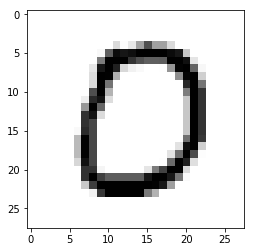

In [9]:
# Evaluate a sample image and display it
import matplotlib.pyplot as plt
from tensorflow.contrib import predictor

%matplotlib inline

image = eval_data[10].reshape(1,28,28,1)

predict_fn = predictor.from_saved_model(export_dir)
predictions = predict_fn(
    {"x": image})

print("Number: ", predictions['classes'][0])

# To interpret the values as a 28x28 image, we need to reshape
# the numpy array, which is one dimensional.
plt.imshow(image.reshape(28, 28), cmap=plt.cm.Greys);